## Our DMR finding process

__Flow:__

1. Create synthetic data containing DMRs

2. Assign all relevant metrics

3. Add significance tests:
    - T-test
    - Wilcoxon rank sum
    - Permutation tests
    
4. Filter and visualise scores for all DMRs in synthetic data


5. Repeat steps 2-4 for real tissue DMBs




In [1]:
import pandas as pd
import numpy as np
import os
import collections
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import sys
from scipy import optimize
import pickle
import time
import random
import itertools
from scipy.stats import ttest_ind, ttest_1samp
import warnings


In [2]:
def plot_dmr_with_highlight2(df, dmr_index, target_tissue, tissue_groups,tg_names=[],bg_names=[], args=None, hypo=True,real_data=False,tissue_id_map={}):
    fig, ax = plt.subplots(figsize=(22, 10))
    colors = itertools.cycle(plt.get_cmap('tab10').colors)
    col_pos = 0

#     print(df.columns)
#     dmr_df = df.filter(regex='|'.join(tissue_groups))

    regex_pattern = '(?i)' + '|'.join(tissue_groups)
    # Filter the DataFrame using the case-insensitive regular expression
    dmr_df = df.filter(regex=regex_pattern)
#     print(dmr_df.columns)
    
    if tg_names:
        tg_names = [u for u in tg_names if u in list(df.columns)]
        bg_names = [u for u in bg_names if u in list(df.columns)]
    else:
        tg_names = [u for u in dmr_df.columns if target_tissue in u]
        bg_names = [u for u in dmr_df.columns if u not in tg_names]
        
    
    
    xticks_positions = []  # List to store the x-axis tick positions
    xticks_labels = []  # List to store the x-axis tick labels

    for tissue in tissue_groups:
        if real_data:
            tissue_columns = [col for col in tissue_id_map[tissue] if col in df.columns]
            meth_ratios_tissue = df.loc[dmr_index, tissue_columns]
        else:
            tissue_columns = [col for col in df.columns if col.startswith(tissue)]
            meth_ratios_tissue = df.loc[dmr_index, tissue_columns]
        
#         print(meth_ratios_tissue)
        x_tissue = np.arange(col_pos, col_pos + len(tissue_columns))
        col_pos += len(tissue_columns)
        
        # Add x-axis tick positions and labels
        xticks_positions.append(np.mean(x_tissue))
        xticks_labels.append(tissue)
        
        if tissue == target_tissue:
            ax.scatter(x_tissue, meth_ratios_tissue, color=next(colors), label=f"{tissue} (DMR)")
        else:
            ax.scatter(x_tissue, meth_ratios_tissue, color=next(colors), label=f"{tissue}")
        

    ax.set_xticks(xticks_positions)
    ax.set_xticklabels(xticks_labels,rotation=90)
    
    
    
    dmr_values = {
    'tg_mean': df.loc[dmr_index, 'tg_mean'],
    'bg_mean': df.loc[dmr_index, 'bg_mean'],
    'delta_means': df.loc[dmr_index, 'delta_means'],
    'tg_quant': df.loc[dmr_index, 'tg_quant'],
    'bg_quant': df.loc[dmr_index, 'bg_quant'],
    'delta_quants': df.loc[dmr_index, 'delta_quants'],
    'meth_quant_thresh': args['meth_quant_thresh'],
    'unmeth_quant_thresh': args['unmeth_quant_thresh']
     }
    
    

    print(f"Target = {tg_names}")
    print(f"Background = {bg_names}")
#     print(dmr_df.columns)
    
    
    # Debugging: Check if dmr_values contain any non-finite values
    if not all(np.isfinite(list(dmr_values.values()))):
        print(f"Warning: dmr_values contain non-finite numbers: {dmr_values}")

    
#     return dmr_df,dmr_values
        
    if args and dmr_values:
        tg_quant = args['tg_quant']
        bg_quant = args['bg_quant']
        target_quantile = 1 - tg_quant if hypo else tg_quant
        background_quantile = bg_quant if hypo else 1 - bg_quant

        tg_percentile = np.percentile(dmr_df.loc[dmr_index, tg_names], target_quantile * 100)
        bg_percentile = np.percentile(dmr_df.loc[dmr_index, bg_names], background_quantile * 100)

        ax.axhline(y=tg_percentile, linestyle='--', color='red', label=f"{target_quantile * 100:.1f}th percentile of target")
        ax.axhline(y=bg_percentile, linestyle='--', color='blue', label=f"{background_quantile * 100:.1f}th percentile of background")
        
        ax.axhline(y=dmr_values["tg_mean"], linestyle=':', color='grey', label=f"tg_mean")
        ax.axhline(y=dmr_values["bg_mean"], linestyle=':', color='grey', label=f"bg_mean")
        
        # Add vertical arrows for delta_quants and delta_means with better spacing
        arrow_x_pos_quants = 0.45
        arrow_x_pos_means = 0.55

        ax.annotate('', xy=(arrow_x_pos_quants, bg_percentile), xytext=(arrow_x_pos_quants, tg_percentile), xycoords=('axes fraction', 'data'), textcoords=('axes fraction', 'data'),
                    arrowprops=dict(arrowstyle='<->', color='black', lw=1.5))
        ax.annotate(f'delta_quants = {dmr_values["delta_quants"]:.2f}', xy=(arrow_x_pos_quants, (tg_percentile + bg_percentile) / 2), xycoords=('axes fraction', 'data'), fontsize=10, va='center', ha='left')
        
        ax.annotate('', xy=(arrow_x_pos_means, dmr_values["bg_mean"]), xytext=(arrow_x_pos_means, dmr_values["tg_mean"]), xycoords=('axes fraction', 'data'), textcoords=('axes fraction', 'data'),
                    arrowprops=dict(arrowstyle='<->', color='purple', lw=1.5))
        ax.annotate(f'delta_means = {dmr_values["delta_means"]:.2f}', xy=(arrow_x_pos_means, (dmr_values["tg_mean"] + dmr_values["bg_mean"]) / 2), xycoords=('axes fraction', 'data'), fontsize=10, va='center', ha='left')
        
        # Annotations for all metrics with explanations
        metric_explanations = {
            'tg_mean': 'Mean of target group',
            'bg_mean': 'Mean of background group',
            'delta_means': 'Difference in means',
            'delta_quants': 'Difference in quantiles',
            # 'tg_quant': 'Quantile value of target group',
            "tg_quant": f"Value of {target_quantile * 100:.1f}th percentile of target",
            'bg_quant': f"Value of {background_quantile * 100:.1f}th percentile of background",
            'delta_maxmin': 'Difference between max of target and min of background',
            'meth_quant_thresh':f'Min value of {background_quantile * 100:.1f}th percentile of methylated bg_group',
            'unmeth_quant_thresh':f'Max value of {target_quantile * 100:.1f}th percentile of unmethylated tg_group',
        }
        for idx, (key, value) in enumerate(dmr_values.items()):
            explanation = metric_explanations.get(key, '')
            ax.annotate(f'{key}: {value:.2f} ({explanation})', xy=(1.02, 1 - idx * 0.07), xycoords='axes fraction',
                        fontsize=10, bbox=dict(facecolor='white', alpha=0.8))
    else:
        ax.set_xticks(range(len(dmr_df.columns)))
        ax.set_xticklabels(dmr_df.columns, rotation=90)
        ax.set_ylabel("Methylation Ratio")
        ax.set_title(f"DMR at {dmr_index}")

    ax.legend(loc='center left', 
              bbox_to_anchor=(1, 0.1),
             ncols=2)
#     ax.legend(loc='lower left', 
#               bbox_to_anchor=(1.05, 1),
#               fontsize='small',
#              ncols=2)
    plt.tight_layout()
    plt.show()
    

### Simulate methylation data containing DMRs

- We'll start with just hypo DMRs

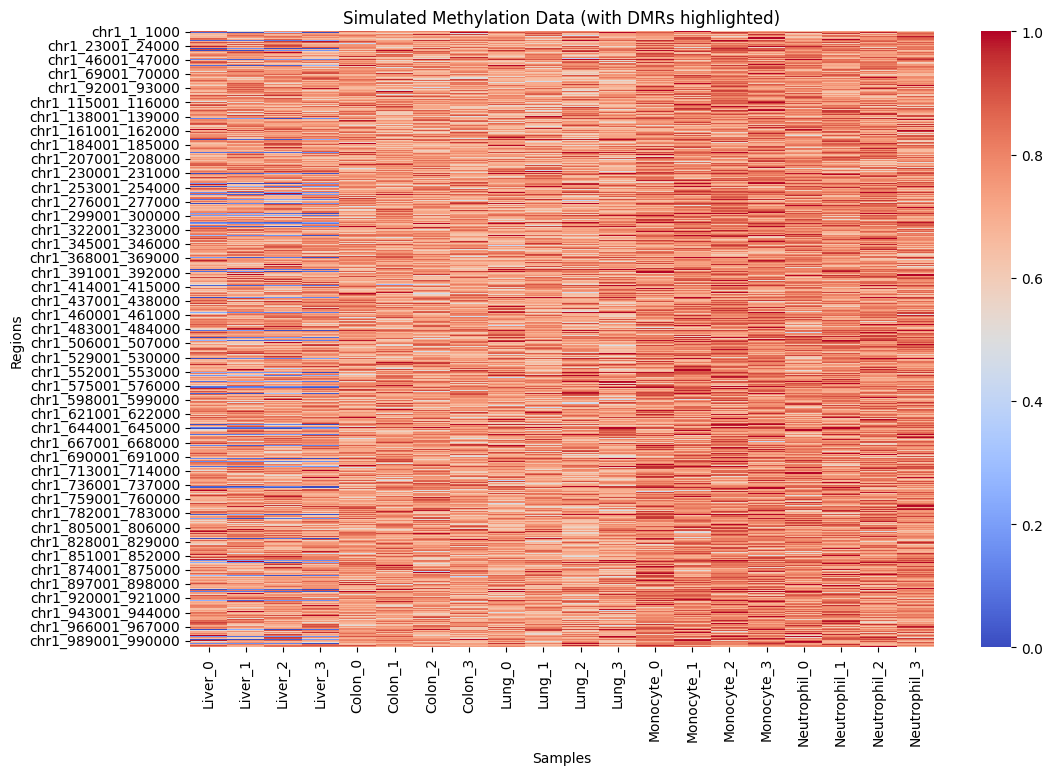

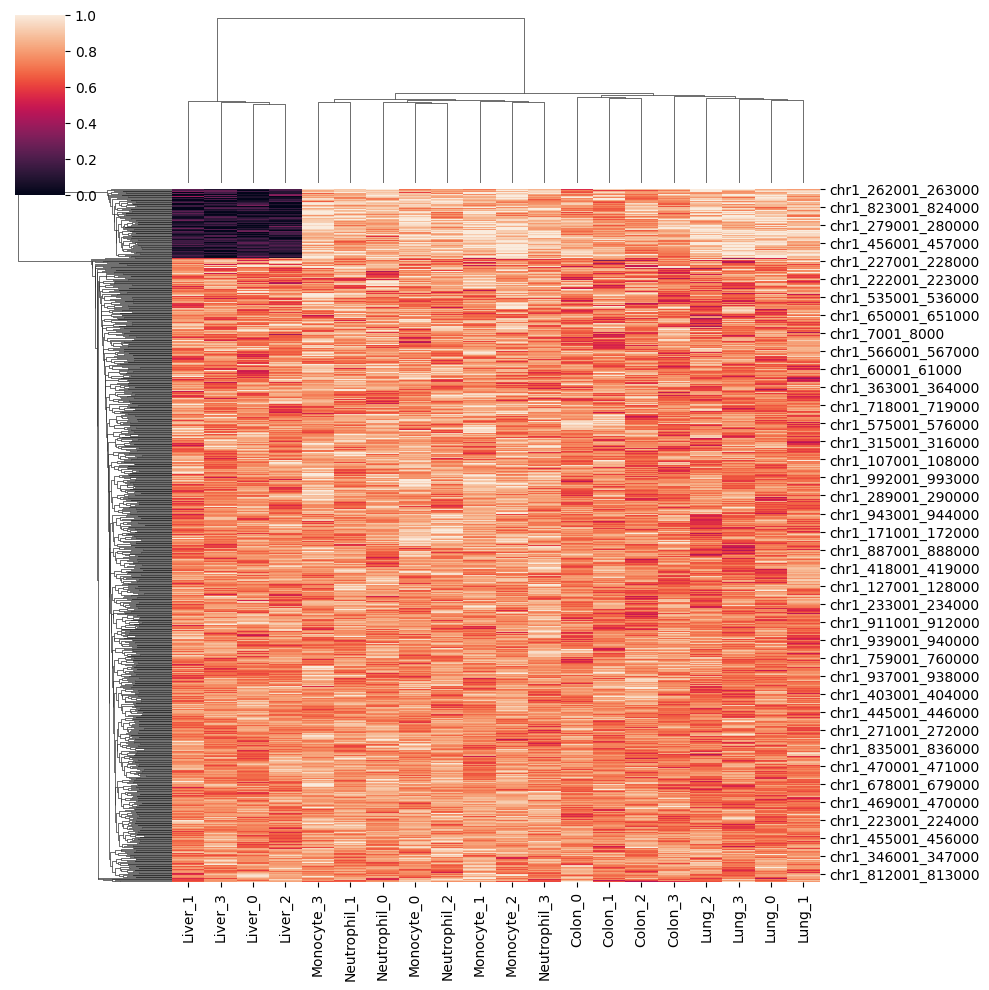

In [3]:
np.random.seed(0)
# Update the function to also return the list of DMR locations
def create_dmr_df_with_background_and_locations(num_regions, num_dmrs, tissue_groups, mean_values_dmr, mean_values_bg,chrom_start="chr1"):

    chr_start_ends = [f'{chrom_start}_{i * 1000 + 1}_{(i + 1) * 1000}' for i in range(num_regions)]
    
    # Initialize an empty dictionary to store the data
    data = {}
    
    # Generate indices for regions with DMRs
    dmr_indices = np.random.choice(range(num_regions), size=num_dmrs, replace=False)
    
    # Generate the list of DMR locations
    dmr_locations = [chr_start_ends[i] for i in dmr_indices]
    
    for t, (mean_val_dmr, mean_val_bg) in zip(tissue_groups, zip(mean_values_dmr, mean_values_bg)):
        for i in range(4):  # Four samples per tissue
            col_name = f'{t}_{i}'
            
            # Generate methylation ratios for DMR regions
            ratios_dmr = np.random.normal(mean_val_dmr, 0.1, num_dmrs)
            ratios_dmr = np.clip(ratios_dmr, 0, 1)
            
            # Generate methylation ratios for background regions
            ratios_bg = np.random.normal(mean_val_bg, 0.1, num_regions - num_dmrs)
            ratios_bg = np.clip(ratios_bg, 0, 1)
            
            # Combine DMR and background ratios
            ratios = np.zeros(num_regions)
            ratios[dmr_indices] = ratios_dmr
            ratios[~np.isin(range(num_regions), dmr_indices)] = ratios_bg
            
            # Add the ratios to the data dictionary
            data[col_name] = ratios
    
    # Create the DataFrame
    dmr_df = pd.DataFrame(data, index=chr_start_ends)
    return dmr_df, dmr_locations

# Parameters for the simulation
num_regions = 1000
num_dmrs = 100  # Number of Liver DMRs
tissue_groups = ['Liver', 'Colon', 'Lung', 'Monocyte', 'Neutrophil']
mean_values_dmr = [0.1, 0.8, 0.9, 0.9, 0.85]  # Mean methylation ratios for Liver DMRs
mean_values_bg = [0.75, 0.74, 0.72, 0.79, 0.78]  # Mean methylation ratios for background regions

# Create the simulated DataFrame and get the DMR locations
df, dmr_locations = create_dmr_df_with_background_and_locations(num_regions, num_dmrs, tissue_groups, mean_values_dmr, mean_values_bg)
df['DMR_label'] = df.index.isin(dmr_locations)
# # Show first few rows of the DataFrame and the DMR locations
# dmr_df_with_bg.head(), dmr_locations[:10]



# Plot heatmap of simulated methylation data, highlighting the DMRs
plt.figure(figsize=(12, 8))
sns.heatmap(df.iloc[:,0:-1], cmap="coolwarm", cbar=True)
plt.title("Simulated Methylation Data (with DMRs highlighted)")
plt.xlabel("Samples")
plt.ylabel("Regions")
plt.show()



sns.clustermap(df.iloc[:,0:-1])


### Step 1. Generate metrics for every region (row)

In [4]:
# df = df.copy()

tissue = 'Liver'
tg_names = [f'{tissue}_{i}' for i in range(4)]
bg_names = [u for u in df.columns if u not in tg_names][0:-1]
# bg_names = [u for u in id_tissue_map.keys() if (u not in tg_names) and (u in tissue_samples_mr.columns)]



args = {
    'tg_names':tg_names,
    'bg_names':bg_names,
    'na_rate_tg': 0.334,
    'na_rate_bg': 0.334,
    'only_hyper': False,
    'only_hypo': False,
#     'delta_means': 0.3,
    'delta_means':0.01, # temporarily setting v easy
    'delta_quants': 0.0,
    'tg_quant': 0.25,
    'bg_quant': 0.025,
    'unmeth_quant_thresh': 1.0,
    'meth_quant_thresh': 0.0,
    'unmeth_mean_thresh': 1.0,
    'meth_mean_thresh': 0.0,
    'pval': 0.05,
    'delta_maxmin': -1,
    'repro':False,
}

tg_names = args['tg_names']
bg_names = args['bg_names']
tg_quant = args['tg_quant']
bg_quant = args['bg_quant']
unmeth_mean_thresh = args['unmeth_mean_thresh']
meth_mean_thresh = args['meth_mean_thresh']
delta_means = args['delta_means']
unmeth_quant_thresh = args['unmeth_quant_thresh']
meth_quant_thresh = args['meth_quant_thresh']
delta_quants = args['delta_quants']
hypo=True
sort_by_delta_quant = True

print(tg_names)
if hypo:
    print(f"Hypo DMRs for {tg_names}, so:")
    target_quantile = 1-tg_quant
    background_quantile = bg_quant

else: # hyper DMRs, so target has high methylation and background has low
    print(f"Hyper DMRs for {tg_names}, so:")

    target_quantile = tg_quant
    background_quantile = 1-bg_quant


print(f"target_quantile: {target_quantile}")
print(f"background_quantile: {background_quantile}")





# ### ------------------------------         Populate metrics          ------------------------------------------------------------

# Compute maxmin
df['delta_maxmin'] = np.abs(df[args['bg_names']].min(axis=1) - df[args['tg_names']].max(axis=1))

# Compute means for target and background
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    df['tg_mean'] = np.nanmean(df[args['tg_names']], axis=1)
    df['bg_mean'] = np.nanmean(df[args['bg_names']], axis=1)


# Change this code to make delta_means always positive for rows containing the target group's DMRs
if hypo:
    df['delta_means'] = df['bg_mean'] - df['tg_mean']
else:
    df['delta_means'] = df['tg_mean'] - df['bg_mean']



# Compute quantiles for target and background - this just computes the values of the quantiles we've set - doesn't do any filtering

df['tg_quant'] = np.nanquantile(df[args['tg_names']], target_quantile, axis=1) # compute quantile, ignoring NaNs
df['bg_quant'] = np.nanquantile(df[args['bg_names']], background_quantile, axis=1)
# df['delta_quants'] = np.abs(df['bg_quant'] - df['tg_quant'])

if hypo:
    df['delta_quants'] = df['bg_quant'] - df['tg_quant'] # if hypo DMR, we expect background methylation to be high and target group methylation to be low
else:
    df['delta_quants'] = df['tg_quant'] - df['bg_quant'] # if hyper DMR, we expect background methylation to be high and target group methylation to be low








['Liver_0', 'Liver_1', 'Liver_2', 'Liver_3']
Hypo DMRs for ['Liver_0', 'Liver_1', 'Liver_2', 'Liver_3'], so:
target_quantile: 0.75
background_quantile: 0.025


In [5]:
df

Liver_0   Liver_1   Liver_2   Liver_3   Colon_0  \
chr1_1_1000          0.888725  0.530459  0.785842  0.805641  0.886703   
chr1_1001_2000       0.064532  0.000000  0.309281  0.000000  0.693223   
chr1_2001_3000       0.668827  0.715389  0.665524  1.000000  0.756449   
chr1_3001_4000       0.664325  0.796749  0.847944  0.727766  0.641078   
chr1_4001_5000       0.792935  0.600921  0.801529  0.633940  0.862427   
...                       ...       ...       ...       ...       ...   
chr1_995001_996000   0.719824  0.808745  0.695818  0.847791  0.667679   
chr1_996001_997000   0.201506  0.072139  0.077698  0.170648  0.664387   
chr1_997001_998000   0.904593  0.712630  0.849586  0.892247  0.912151   
chr1_998001_999000   0.806781  0.693200  0.834140  0.810535  0.784856   
chr1_999001_1000000  0.809485  0.691664  0.670958  0.716946  0.808804   

                      Colon_1   Colon_2   Colon_3    Lung_0    Lung_1  ...  \
chr1_1_1000          0.774782  0.804194  0.850341  0.712177  0.791556  ...   
chr1_1001_2000       0.726917  0.683859  1.000000  0.907048  0.832688  ...   
chr1_2001_3000       0.617129  0.922785  0.976380  0.618796  0.780281  ...   
chr1_3001_4000       0.577073  0.703170  0.482967  0.744340  0.921446  ...   
chr1_4001_5000       0.604439  0.706855  0.779213  0.551700  0.671862  ...   
...                       ...       ...       ...       ...       ...  ...   
chr1_995001_996000   0.799273  0.664245  0.732333  0.735306  0.668616  ...   
chr1_996001_997000   0.742999  0.812611  0.974839  0.732636  0.826460  ...   
chr1_997001_998000   0.786255  0.676554  0.693807  0.743849  0.708219  ...   
chr1_998001_999000   0.699367  0.830474  0.739362  0.804062  0.620281  ...   
chr1_999001_1000000  0.742491  0.681343  0.736364  0.683718  0.678659  ...   

                     Neutrophil_2  Neutrophil_3  DMR_label  delta_maxmin  \
chr1_1_1000              0.753331      0.622695      False      0.266030   
chr1_1001_2000           0.975615      0.823988       True      0.374578   
chr1_2001_3000           0.906376      0.574787      False      0.425213   
chr1_3001_4000           0.628489      0.875694      False      0.364977   
chr1_4001_5000           0.631983      0.933586      False      0.249829   
...                           ...           ...        ...           ...   
chr1_995001_996000       0.659817      0.724143      False      0.217177   
chr1_996001_997000       0.944745      0.763827       True      0.462881   
chr1_997001_998000       0.744888      0.812820      False      0.228039   
chr1_998001_999000       1.000000      0.679099      False      0.213859   
chr1_999001_1000000      0.710380      0.900904      False      0.309624   

                      tg_mean   bg_mean  delta_means  tg_quant  bg_quant  \
chr1_1_1000          0.752667  0.762201     0.009534  0.826412  0.632888   
chr1_1001_2000       0.093453  0.856670     0.763217  0.125719  0.687371   
chr1_2001_3000       0.762435  0.791373     0.028938  0.786542  0.590665   
chr1_3001_4000       0.759196  0.732324    -0.026872  0.809547  0.518257   
chr1_4001_5000       0.707331  0.731013     0.023681  0.795084  0.556887   
...                       ...       ...          ...       ...       ...   
chr1_995001_996000   0.768044  0.757304    -0.010741  0.818506  0.641565   
chr1_996001_997000   0.130498  0.850626     0.720128  0.178362  0.689980   
chr1_997001_998000   0.839764  0.790586    -0.049178  0.895334  0.683024   
chr1_998001_999000   0.786164  0.767998    -0.018166  0.816436  0.626730   
chr1_999001_1000000  0.722263  0.780198     0.057934  0.740081  0.560673   

                     delta_quants  
chr1_1_1000             -0.193524  
chr1_1001_2000           0.561652  
chr1_2001_3000          -0.195876  
chr1_3001_4000          -0.291291  
chr1_4001_5000          -0.238197  
...                           ...  
chr1_995001_996000      -0.176941  
chr1_996001_997000       0.511618  
chr1_997001_998000      -0.212310  
chr1_998001_999000    

Target = ['Liver_0', 'Liver_1', 'Liver_2', 'Liver_3']
Background = ['Colon_0', 'Colon_1', 'Colon_2', 'Colon_3', 'Lung_0', 'Lung_1', 'Lung_2', 'Lung_3', 'Monocyte_0', 'Monocyte_1', 'Monocyte_2', 'Monocyte_3', 'Neutrophil_0', 'Neutrophil_1', 'Neutrophil_2', 'Neutrophil_3']


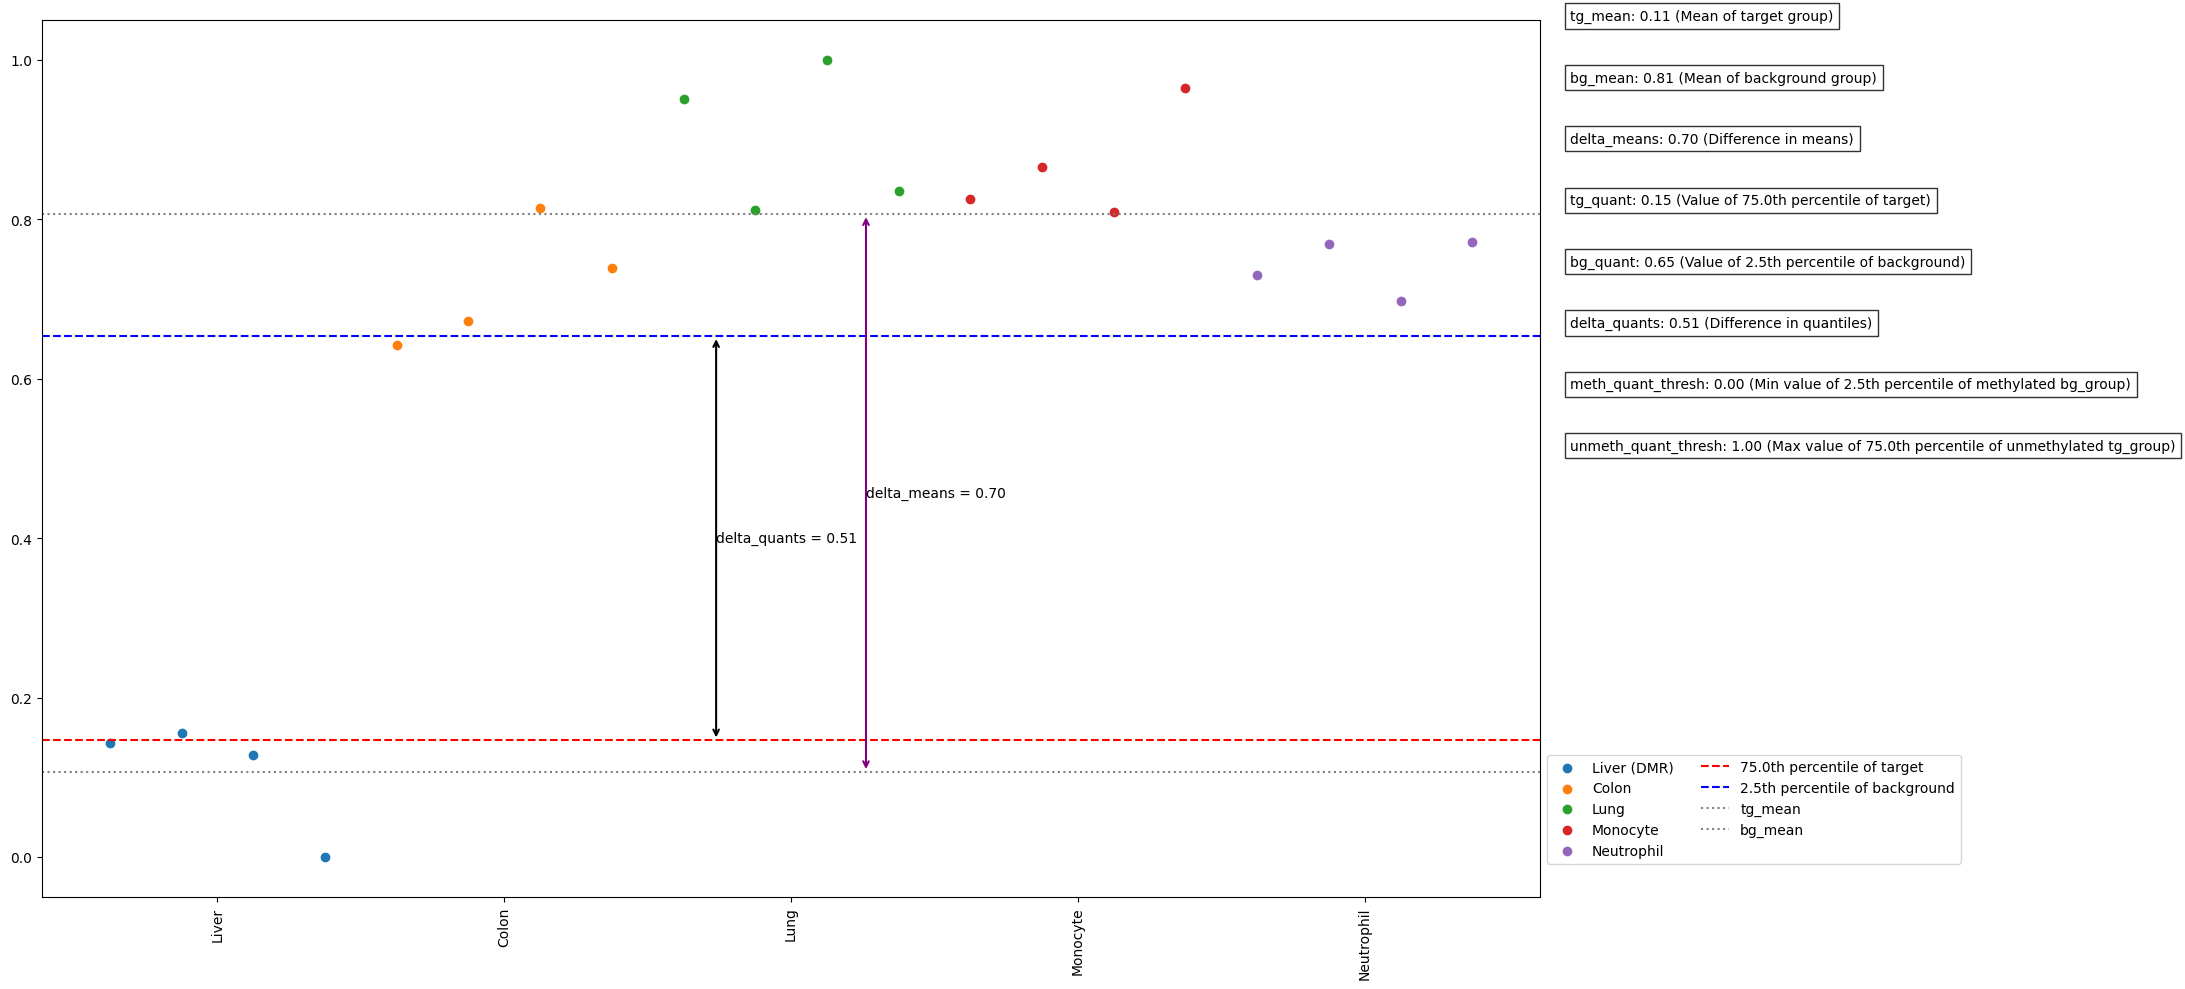

Target = ['Liver_0', 'Liver_1', 'Liver_2', 'Liver_3']
Background = ['Colon_0', 'Colon_1', 'Colon_2', 'Colon_3', 'Lung_0', 'Lung_1', 'Lung_2', 'Lung_3', 'Monocyte_0', 'Monocyte_1', 'Monocyte_2', 'Monocyte_3', 'Neutrophil_0', 'Neutrophil_1', 'Neutrophil_2', 'Neutrophil_3']


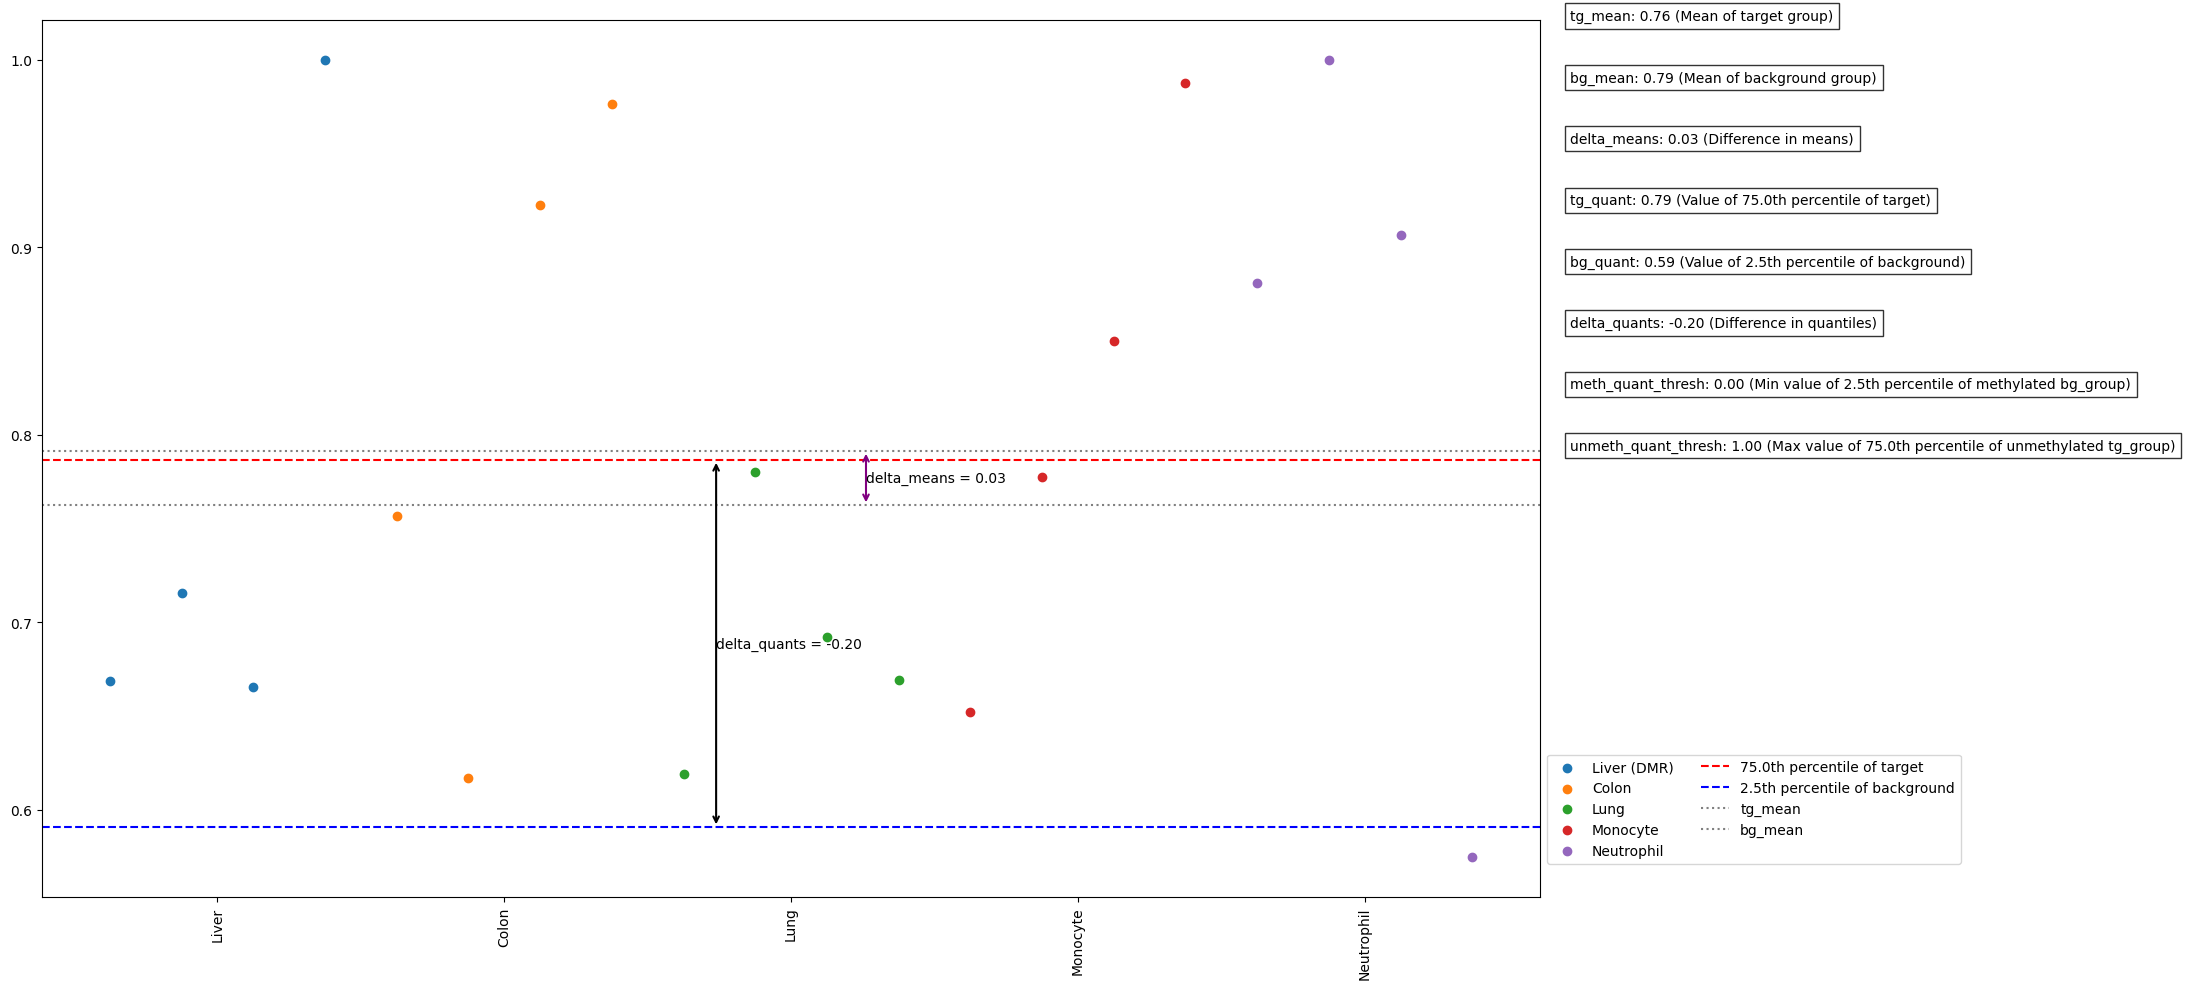

In [6]:
plot_dmr_with_highlight2(df, 'chr1_993001_994000', 'Liver', tissue_groups, args=args)
plot_dmr_with_highlight2(df, 'chr1_2001_3000', 'Liver', tissue_groups, args=args)

In [7]:
df

Liver_0   Liver_1   Liver_2   Liver_3   Colon_0  \
chr1_1_1000          0.888725  0.530459  0.785842  0.805641  0.886703   
chr1_1001_2000       0.064532  0.000000  0.309281  0.000000  0.693223   
chr1_2001_3000       0.668827  0.715389  0.665524  1.000000  0.756449   
chr1_3001_4000       0.664325  0.796749  0.847944  0.727766  0.641078   
chr1_4001_5000       0.792935  0.600921  0.801529  0.633940  0.862427   
...                       ...       ...       ...       ...       ...   
chr1_995001_996000   0.719824  0.808745  0.695818  0.847791  0.667679   
chr1_996001_997000   0.201506  0.072139  0.077698  0.170648  0.664387   
chr1_997001_998000   0.904593  0.712630  0.849586  0.892247  0.912151   
chr1_998001_999000   0.806781  0.693200  0.834140  0.810535  0.784856   
chr1_999001_1000000  0.809485  0.691664  0.670958  0.716946  0.808804   

                      Colon_1   Colon_2   Colon_3    Lung_0    Lung_1  ...  \
chr1_1_1000          0.774782  0.804194  0.850341  0.712177  0.791556  ...   
chr1_1001_2000       0.726917  0.683859  1.000000  0.907048  0.832688  ...   
chr1_2001_3000       0.617129  0.922785  0.976380  0.618796  0.780281  ...   
chr1_3001_4000       0.577073  0.703170  0.482967  0.744340  0.921446  ...   
chr1_4001_5000       0.604439  0.706855  0.779213  0.551700  0.671862  ...   
...                       ...       ...       ...       ...       ...  ...   
chr1_995001_996000   0.799273  0.664245  0.732333  0.735306  0.668616  ...   
chr1_996001_997000   0.742999  0.812611  0.974839  0.732636  0.826460  ...   
chr1_997001_998000   0.786255  0.676554  0.693807  0.743849  0.708219  ...   
chr1_998001_999000   0.699367  0.830474  0.739362  0.804062  0.620281  ...   
chr1_999001_1000000  0.742491  0.681343  0.736364  0.683718  0.678659  ...   

                     Neutrophil_2  Neutrophil_3  DMR_label  delta_maxmin  \
chr1_1_1000              0.753331      0.622695      False      0.266030   
chr1_1001_2000           0.975615      0.823988       True      0.374578   
chr1_2001_3000           0.906376      0.574787      False      0.425213   
chr1_3001_4000           0.628489      0.875694      False      0.364977   
chr1_4001_5000           0.631983      0.933586      False      0.249829   
...                           ...           ...        ...           ...   
chr1_995001_996000       0.659817      0.724143      False      0.217177   
chr1_996001_997000       0.944745      0.763827       True      0.462881   
chr1_997001_998000       0.744888      0.812820      False      0.228039   
chr1_998001_999000       1.000000      0.679099      False      0.213859   
chr1_999001_1000000      0.710380      0.900904      False      0.309624   

                      tg_mean   bg_mean  delta_means  tg_quant  bg_quant  \
chr1_1_1000          0.752667  0.762201     0.009534  0.826412  0.632888   
chr1_1001_2000       0.093453  0.856670     0.763217  0.125719  0.687371   
chr1_2001_3000       0.762435  0.791373     0.028938  0.786542  0.590665   
chr1_3001_4000       0.759196  0.732324    -0.026872  0.809547  0.518257   
chr1_4001_5000       0.707331  0.731013     0.023681  0.795084  0.556887   
...                       ...       ...          ...       ...       ...   
chr1_995001_996000   0.768044  0.757304    -0.010741  0.818506  0.641565   
chr1_996001_997000   0.130498  0.850626     0.720128  0.178362  0.689980   
chr1_997001_998000   0.839764  0.790586    -0.049178  0.895334  0.683024   
chr1_998001_999000   0.786164  0.767998    -0.018166  0.816436  0.626730   
chr1_999001_1000000  0.722263  0.780198     0.057934  0.740081  0.560673   

                     delta_quants  
chr1_1_1000             -0.193524  
chr1_1001_2000           0.561652  
chr1_2001_3000          -0.195876  
chr1_3001_4000          -0.291291  
chr1_4001_5000          -0.238197  
...                           ...  
chr1_995001_996000      -0.176941  
chr1_996001_997000       0.511618  
chr1_997001_998000      -0.212310  
chr1_998001_999000    

Target = ['Liver_0', 'Liver_1', 'Liver_2', 'Liver_3']
Background = ['Colon_0', 'Colon_1', 'Colon_2', 'Colon_3', 'Lung_0', 'Lung_1', 'Lung_2', 'Lung_3', 'Monocyte_0', 'Monocyte_1', 'Monocyte_2', 'Monocyte_3', 'Neutrophil_0', 'Neutrophil_1', 'Neutrophil_2', 'Neutrophil_3']


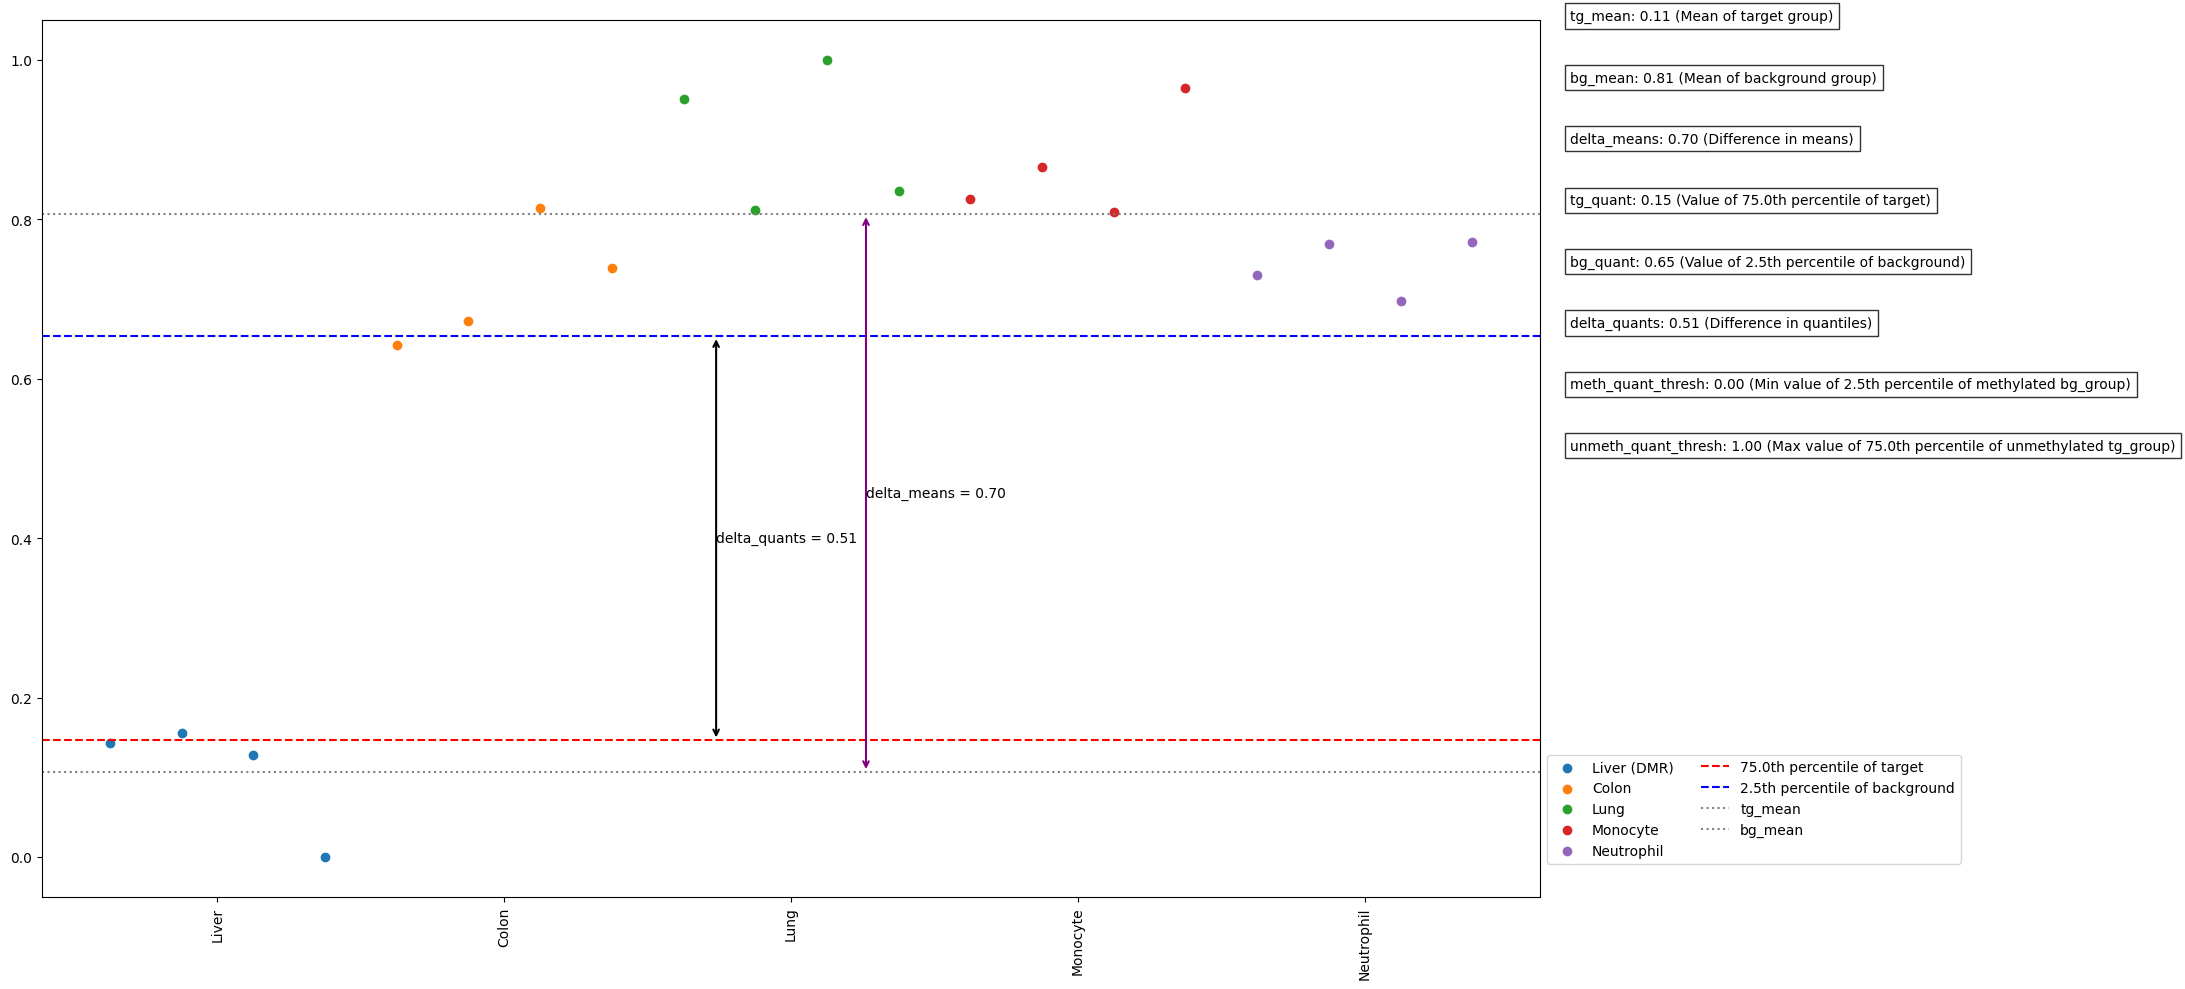

In [8]:
plot_dmr_with_highlight2(df, 'chr1_993001_994000', 'Liver', tissue_groups, args=args)


## Add significance testing

#### T-tests

In [9]:
### Add t-test p-value
pval=0.05
bonferroni_alpha = pval / len(df)

if len(tg_names) == 1:
    print(f"Only one tissue sample in tg_group, so using one-sample independent t-test (two-sided) - comparing mean of bg_group to a single value in tg_group. \nNull hypothesis is expected value (mean) of samples is equal to existing population mean")
    r = ttest_1samp(df[bg_names], df[tg_names].values.flatten(), axis=1, nan_policy='omit')
elif len(bg_names) == 1:
    print(f"Only one tissue sample in bg_group, so using one-sample independent t-test (two-sided) - comparing mean of tg_group to a single value in bg_group")
    r = ttest_1samp(df[tg_names], df[bg_names].values.flatten(), axis=1, nan_policy='omit')
# test for n>1
else:
    print(f"Performing two sample independent t-test (two sided). Null hypothesis is two independent samples have identical means. \n Size of tg_group={len(tg_names)} and size of bg_group={len(bg_names)}")
    r = ttest_ind(df[tg_names], df[bg_names], axis=1, nan_policy='omit')
        
df['ttest'] = r.pvalue
df['significant_dmrs'] = df['ttest'] <= bonferroni_alpha # boolean column to filter by bonferroni corrected p-vals

Performing two sample independent t-test (two sided). Null hypothesis is two independent samples have identical means. 
 Size of tg_group=4 and size of bg_group=16


In [10]:
df

Liver_0   Liver_1   Liver_2   Liver_3   Colon_0  \
chr1_1_1000          0.888725  0.530459  0.785842  0.805641  0.886703   
chr1_1001_2000       0.064532  0.000000  0.309281  0.000000  0.693223   
chr1_2001_3000       0.668827  0.715389  0.665524  1.000000  0.756449   
chr1_3001_4000       0.664325  0.796749  0.847944  0.727766  0.641078   
chr1_4001_5000       0.792935  0.600921  0.801529  0.633940  0.862427   
...                       ...       ...       ...       ...       ...   
chr1_995001_996000   0.719824  0.808745  0.695818  0.847791  0.667679   
chr1_996001_997000   0.201506  0.072139  0.077698  0.170648  0.664387   
chr1_997001_998000   0.904593  0.712630  0.849586  0.892247  0.912151   
chr1_998001_999000   0.806781  0.693200  0.834140  0.810535  0.784856   
chr1_999001_1000000  0.809485  0.691664  0.670958  0.716946  0.808804   

                      Colon_1   Colon_2   Colon_3    Lung_0    Lung_1  ...  \
chr1_1_1000          0.774782  0.804194  0.850341  0.712177  0.791556  ...   
chr1_1001_2000       0.726917  0.683859  1.000000  0.907048  0.832688  ...   
chr1_2001_3000       0.617129  0.922785  0.976380  0.618796  0.780281  ...   
chr1_3001_4000       0.577073  0.703170  0.482967  0.744340  0.921446  ...   
chr1_4001_5000       0.604439  0.706855  0.779213  0.551700  0.671862  ...   
...                       ...       ...       ...       ...       ...  ...   
chr1_995001_996000   0.799273  0.664245  0.732333  0.735306  0.668616  ...   
chr1_996001_997000   0.742999  0.812611  0.974839  0.732636  0.826460  ...   
chr1_997001_998000   0.786255  0.676554  0.693807  0.743849  0.708219  ...   
chr1_998001_999000   0.699367  0.830474  0.739362  0.804062  0.620281  ...   
chr1_999001_1000000  0.742491  0.681343  0.736364  0.683718  0.678659  ...   

                     DMR_label  delta_maxmin   tg_mean   bg_mean  delta_means  \
chr1_1_1000              False      0.266030  0.752667  0.762201     0.009534   
chr1_1001_2000            True      0.374578  0.093453  0.856670     0.763217   
chr1_2001_3000           False      0.425213  0.762435  0.791373     0.028938   
chr1_3001_4000           False      0.364977  0.759196  0.732324    -0.026872   
chr1_4001_5000           False      0.249829  0.707331  0.731013     0.023681   
...                        ...           ...       ...       ...          ...   
chr1_995001_996000       False      0.217177  0.768044  0.757304    -0.010741   
chr1_996001_997000        True      0.462881  0.130498  0.850626     0.720128   
chr1_997001_998000       False      0.228039  0.839764  0.790586    -0.049178   
chr1_998001_999000       False      0.213859  0.786164  0.767998    -0.018166   
chr1_999001_1000000      False      0.309624  0.722263  0.780198     0.057934   

                     tg_quant  bg_quant  delta_quants         ttest  \
chr1_1_1000          0.826412  0.632888     -0.193524  8.775529e-01   
chr1_1001_2000       0.125719  0.687371      0.561652  3.715151e-10   
chr1_2001_3000       0.786542  0.590665     -0.195876  7.284848e-01   
chr1_3001_4000       0.809547  0.518257     -0.291291  7.021414e-01   
chr1_4001_5000       0.795084  0.556887     -0.238197  7.192364e-01   
...                       ...       ...           ...           ...   
chr1_995001_996000   0.818506  0.641565     -0.176941  8.335701e-01   
chr1_996001_997000   0.178362  0.689980      0.511618  8.644355e-11   
chr1_997001_998000   0.895334  0.683024     -0.212310  3.522788e-01   
chr1_998001_999000   0.816436  0.626730     -0.189706  7.377162e-01   
chr1_999001_1000000  0.740081  0.560673     -0.179408  4.062318e-01   

                     significant_dmrs  
chr1_1_1000                     False  
chr1_1001_2000                   True  
chr1_2001_3000                  False  
chr1_3001_4000                  False  
chr1_4001_5000                  False  
...                               ...  
chr1_995001_996000              False  
chr1_996001_997000               True  
chr1_997001_998000    

### Wilcoxon rank sum test

In [11]:
from scipy.stats import ranksums


def apply_ranksums(row):
    group1 = row[tg_names].dropna()  
    group2 = row[bg_names].dropna()  
    statistic, p_value = ranksums(group1, group2)
    return p_value


def dmr_wilcoxon(dmr_df, tg_names, bg_names, pval):
    # Apply Wilcoxon rank-sum test
    dmr_df['wilcoxon'] = dmr_df.apply(apply_ranksums, axis=1)
    
    # Bonferroni correction
    bonferroni_alpha = pval / len(dmr_df)
    dmr_df['significant_wilcoxon'] = dmr_df['wilcoxon'] <= bonferroni_alpha
    
    return dmr_df


df = dmr_wilcoxon(df, tg_names, bg_names, 0.05)

df.head()


Liver_0   Liver_1   Liver_2   Liver_3   Colon_0   Colon_1  \
chr1_1_1000     0.888725  0.530459  0.785842  0.805641  0.886703  0.774782   
chr1_1001_2000  0.064532  0.000000  0.309281  0.000000  0.693223  0.726917   
chr1_2001_3000  0.668827  0.715389  0.665524  1.000000  0.756449  0.617129   
chr1_3001_4000  0.664325  0.796749  0.847944  0.727766  0.641078  0.577073   
chr1_4001_5000  0.792935  0.600921  0.801529  0.633940  0.862427  0.604439   

                 Colon_2   Colon_3    Lung_0    Lung_1  ...   tg_mean  \
chr1_1_1000     0.804194  0.850341  0.712177  0.791556  ...  0.752667   
chr1_1001_2000  0.683859  1.000000  0.907048  0.832688  ...  0.093453   
chr1_2001_3000  0.922785  0.976380  0.618796  0.780281  ...  0.762435   
chr1_3001_4000  0.703170  0.482967  0.744340  0.921446  ...  0.759196   
chr1_4001_5000  0.706855  0.779213  0.551700  0.671862  ...  0.707331   

                 bg_mean  delta_means  tg_quant  bg_quant  delta_quants  \
chr1_1_1000     0.762201     0.009534  0.826412  0.632888     -0.193524   
chr1_1001_2000  0.856670     0.763217  0.125719  0.687371      0.561652   
chr1_2001_3000  0.791373     0.028938  0.786542  0.590665     -0.195876   
chr1_3001_4000  0.732324    -0.026872  0.809547  0.518257     -0.291291   
chr1_4001_5000  0.731013     0.023681  0.795084  0.556887     -0.238197   

                       ttest  significant_dmrs  wilcoxon  significant_wilcoxon  
chr1_1_1000     8.775529e-01             False  0.636602                 False  
chr1_1001_2000  3.715151e-10              True  0.002497                 False  
chr1_2001_3000  7.284848e-01             False  0.813256                 False  
chr1_3001_4000  7.021414e-01             False  0.705457                 False  
chr1_4001_5000  7.192364e-01             False  0.705457                 False  

[5 rows x 32 columns]

## Permutation testing to get significance for delta quants

Idea here:

- run many permutations of shuffled labels
- calculate tg_quant for the target group and bg_quant for the background group each time
- use that to calculate delta_quant for each permutation

These permutations will give us a distribution of expected delta quants under the null hypothesis.
We then compare these to our observed delta quant values, to get the probability of observing the delta_quant we observe, given the null hypothesis ==> definition of a p-value.


__Problem__:

Because we use quantiles, each time we shuffle labels, we don't observe a normal distribution of delta quants. We instead a bimodal distribution - generally the delta quant is very high, but occasionally very low, depending entirely on which samples are shuffled into each group. The 2.5th percentile of the background group will always still be high, but will the 75th percentile of the target group always still be low (?)

### How should permutation testing be done?


We basically want a distribution of delta_quants given the null hypothesis, so we can then compare this to delta_quants for DMRs.

- Should we randomly permute labels for a single region, recalculating delta_quants for each shuffle? If so, do not take absolute value of delta_quants

- Alternatively, should we calculate delta_quants across all regions at the start to get a distribution, then use that?

- Third option, calculate for each region, randomly select tg_group and bg_group, and calculate delta_quants for this random selection. So we have one estimate per region. Could do this on real data.

In [12]:
df

Liver_0   Liver_1   Liver_2   Liver_3   Colon_0  \
chr1_1_1000          0.888725  0.530459  0.785842  0.805641  0.886703   
chr1_1001_2000       0.064532  0.000000  0.309281  0.000000  0.693223   
chr1_2001_3000       0.668827  0.715389  0.665524  1.000000  0.756449   
chr1_3001_4000       0.664325  0.796749  0.847944  0.727766  0.641078   
chr1_4001_5000       0.792935  0.600921  0.801529  0.633940  0.862427   
...                       ...       ...       ...       ...       ...   
chr1_995001_996000   0.719824  0.808745  0.695818  0.847791  0.667679   
chr1_996001_997000   0.201506  0.072139  0.077698  0.170648  0.664387   
chr1_997001_998000   0.904593  0.712630  0.849586  0.892247  0.912151   
chr1_998001_999000   0.806781  0.693200  0.834140  0.810535  0.784856   
chr1_999001_1000000  0.809485  0.691664  0.670958  0.716946  0.808804   

                      Colon_1   Colon_2   Colon_3    Lung_0    Lung_1  ...  \
chr1_1_1000          0.774782  0.804194  0.850341  0.712177  0.791556  ...   
chr1_1001_2000       0.726917  0.683859  1.000000  0.907048  0.832688  ...   
chr1_2001_3000       0.617129  0.922785  0.976380  0.618796  0.780281  ...   
chr1_3001_4000       0.577073  0.703170  0.482967  0.744340  0.921446  ...   
chr1_4001_5000       0.604439  0.706855  0.779213  0.551700  0.671862  ...   
...                       ...       ...       ...       ...       ...  ...   
chr1_995001_996000   0.799273  0.664245  0.732333  0.735306  0.668616  ...   
chr1_996001_997000   0.742999  0.812611  0.974839  0.732636  0.826460  ...   
chr1_997001_998000   0.786255  0.676554  0.693807  0.743849  0.708219  ...   
chr1_998001_999000   0.699367  0.830474  0.739362  0.804062  0.620281  ...   
chr1_999001_1000000  0.742491  0.681343  0.736364  0.683718  0.678659  ...   

                      tg_mean   bg_mean  delta_means  tg_quant  bg_quant  \
chr1_1_1000          0.752667  0.762201     0.009534  0.826412  0.632888   
chr1_1001_2000       0.093453  0.856670     0.763217  0.125719  0.687371   
chr1_2001_3000       0.762435  0.791373     0.028938  0.786542  0.590665   
chr1_3001_4000       0.759196  0.732324    -0.026872  0.809547  0.518257   
chr1_4001_5000       0.707331  0.731013     0.023681  0.795084  0.556887   
...                       ...       ...          ...       ...       ...   
chr1_995001_996000   0.768044  0.757304    -0.010741  0.818506  0.641565   
chr1_996001_997000   0.130498  0.850626     0.720128  0.178362  0.689980   
chr1_997001_998000   0.839764  0.790586    -0.049178  0.895334  0.683024   
chr1_998001_999000   0.786164  0.767998    -0.018166  0.816436  0.626730   
chr1_999001_1000000  0.722263  0.780198     0.057934  0.740081  0.560673   

                     delta_quants         ttest  significant_dmrs  wilcoxon  \
chr1_1_1000             -0.193524  8.775529e-01             False  0.636602   
chr1_1001_2000           0.561652  3.715151e-10              True  0.002497   
chr1_2001_3000          -0.195876  7.284848e-01             False  0.813256   
chr1_3001_4000          -0.291291  7.021414e-01             False  0.705457   
chr1_4001_5000          -0.238197  7.192364e-01             False  0.705457   
...                           ...           ...               ...       ...   
chr1_995001_996000      -0.176941  8.335701e-01             False  0.850107   
chr1_996001_997000       0.511618  8.644355e-11              True  0.002497   
chr1_997001_998000      -0.212310  3.522788e-01             False  0.256839   
chr1_998001_999000      -0.189706  7.377162e-01             False  0.705457   
chr1_999001_1000000     -0.179408  4.062318e-01             False  0.395092   

                     significant_wilcoxon  
chr1_1_1000                         False  
chr1_1001_2000                      False  
chr1_2001_3000                      False  
chr1_3001_4000                      False  
chr1_4001_5000                      False  
...                                   ...  
chr1_995001_996000                  Fa

In [13]:
random_region_name = "chr1_993001_994000"
dmr_index = random_region_name
target_data = df.loc[dmr_index, tg_names].values
background_data = df.loc[dmr_index, bg_names].values

Target = ['Liver_0', 'Liver_1', 'Liver_2', 'Liver_3']
Background = ['Colon_0', 'Colon_1', 'Colon_2', 'Colon_3', 'Lung_0', 'Lung_1', 'Lung_2', 'Lung_3', 'Monocyte_0', 'Monocyte_1', 'Monocyte_2', 'Monocyte_3', 'Neutrophil_0', 'Neutrophil_1', 'Neutrophil_2', 'Neutrophil_3']


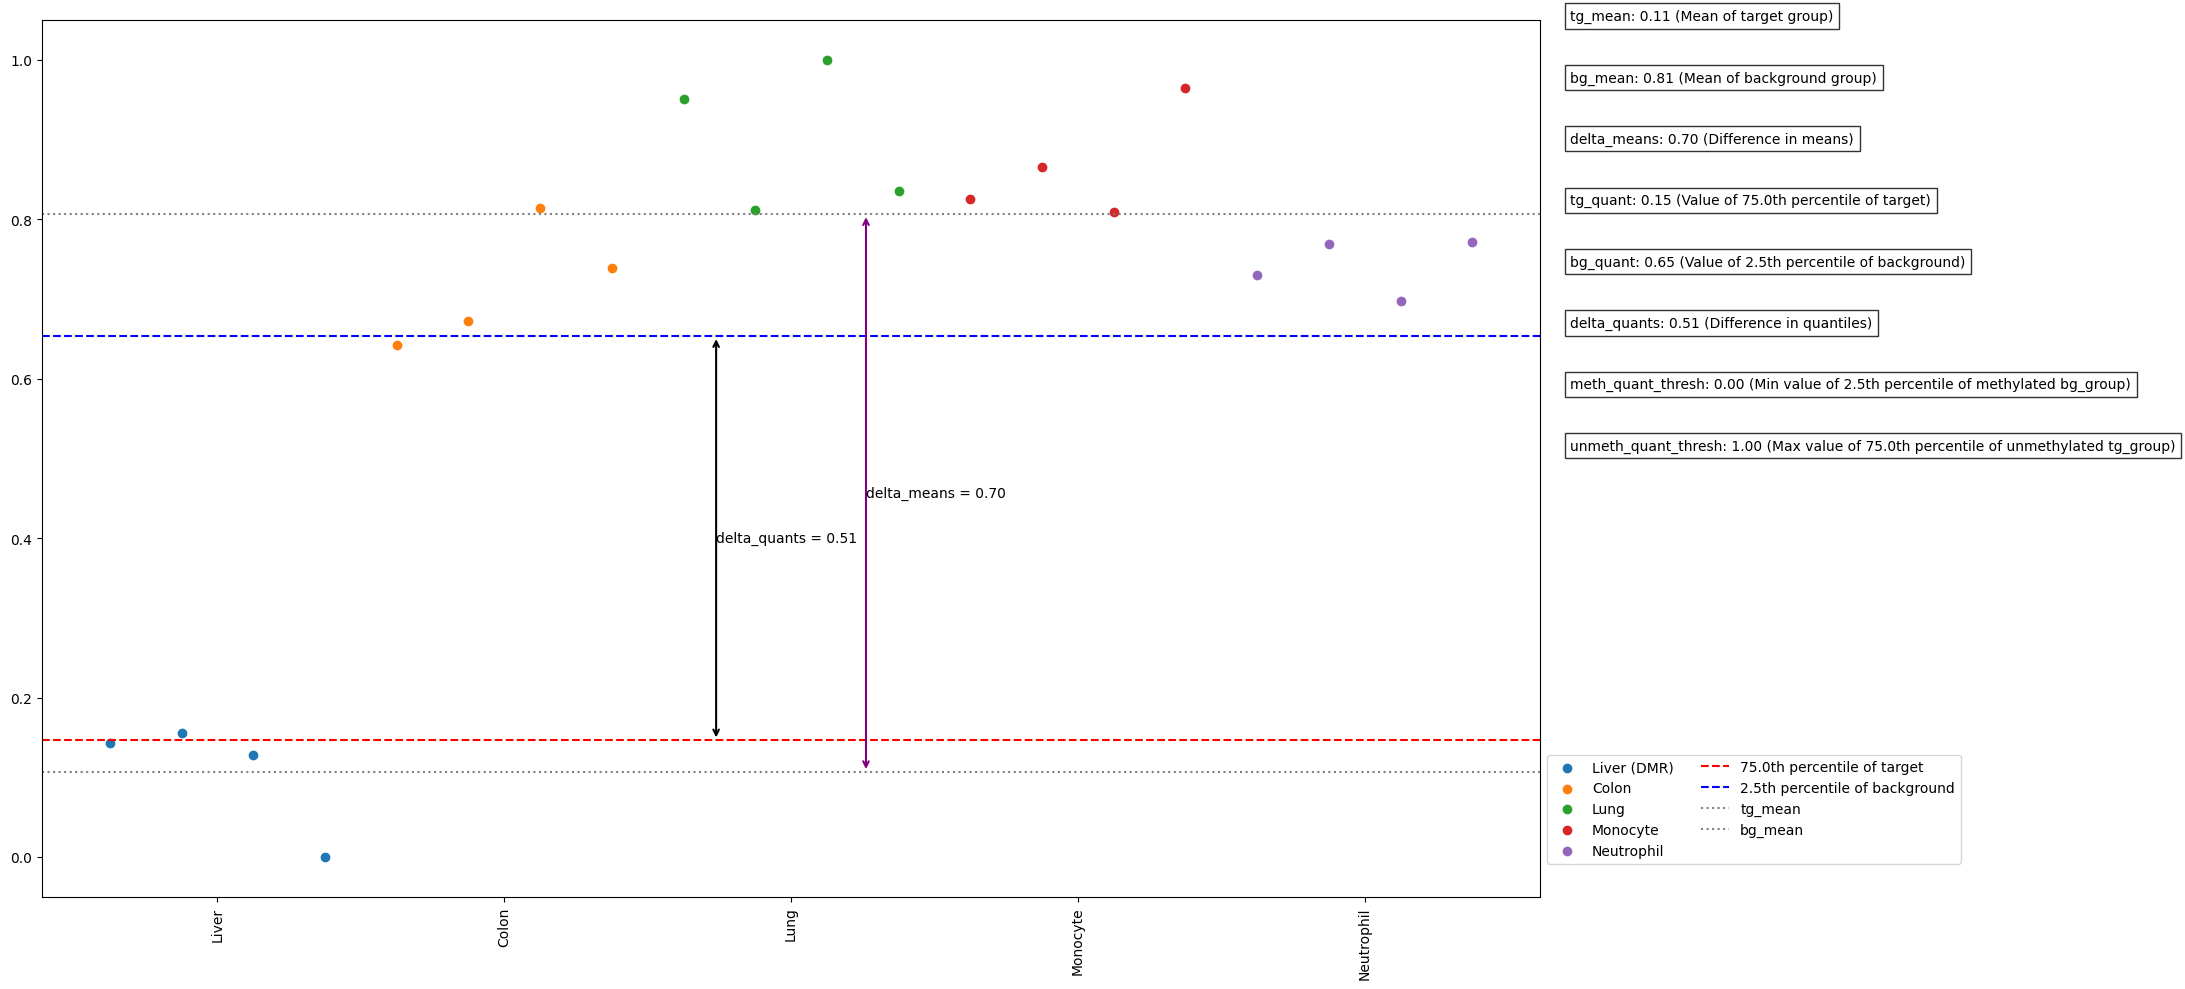

In [14]:
plot_dmr_with_highlight2(df, random_region_name, 'Liver', tissue_groups, args=args)


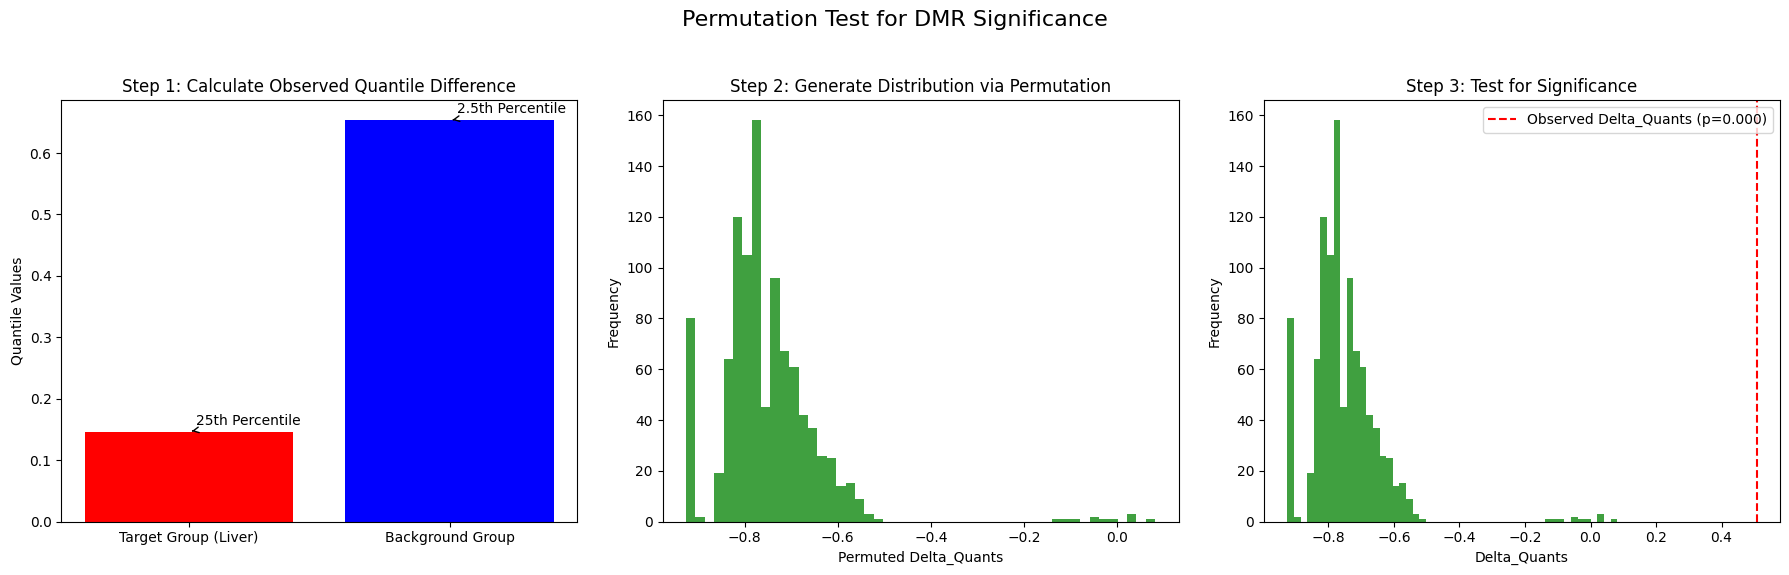

In [15]:
# Function to perform permutation test
def permutation_test(df, dmr_index, tg_names, bg_names, target_quantile=0.75,background_quantile=0.025,n_permutations=1000):
    # Ensure that the data only contains numeric values
    target_data = df.loc[dmr_index, tg_names].dropna().values.astype(float)
    background_data = df.loc[dmr_index, bg_names].dropna().values.astype(float)
    
    # Calculate the observed delta_quants
    observed_delta_quants = np.nanquantile(background_data, background_quantile) - np.nanquantile(target_data, target_quantile)
    
    # Initialize an array to store the permuted delta_quants
    permuted_delta_quants = np.zeros(n_permutations)
    
    for i in range(n_permutations):
        # Concatenate and shuffle the data
        combined_data = np.concatenate([target_data, background_data])
        np.random.shuffle(combined_data)
        
        # Split the shuffled data back into two groups of the original sizes
        perm_target_data = combined_data[:len(target_data)]
        perm_background_data = combined_data[len(target_data):]
        
        # Calculate and store the permuted delta_quants
        permuted_delta_quants[i] = np.nanquantile(perm_background_data, background_quantile) - np.nanquantile(perm_target_data, target_quantile)
    
    # Calculate p-value
    p_value = np.sum(permuted_delta_quants >= observed_delta_quants) / n_permutations
    
    return observed_delta_quants, permuted_delta_quants, p_value

# Execute permutation test
observed_delta_quants, permuted_delta_quants, p_value = permutation_test(df, random_region_name, tg_names, bg_names)


target_quantile=0.75
background_quantile=0.025

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle("Permutation Test for DMR Significance", fontsize=16)

# Plot 1: Illustration of Permutation Test
axes[0].bar([0, 1], [np.nanquantile(df.loc[random_region_name, tg_names].values, target_quantile), 
                     np.nanquantile(df.loc[random_region_name, bg_names].values, background_quantile)], color=['red', 'blue'])
axes[0].set_xticks([0, 1])
axes[0].set_xticklabels(['Target Group (Liver)', 'Background Group'])
axes[0].set_ylabel("Quantile Values")
axes[0].set_title("Step 1: Calculate Observed Quantile Difference")
axes[0].annotate('25th Percentile', xy=(0, np.nanquantile(df.loc[random_region_name, tg_names].values, target_quantile)), xytext=(5, 5), textcoords='offset points', arrowprops=dict(facecolor='black', arrowstyle='->'))
axes[0].annotate('2.5th Percentile', xy=(1, np.nanquantile(df.loc[random_region_name, bg_names].values, background_quantile)), xytext=(5, 5), textcoords='offset points', arrowprops=dict(facecolor='black', arrowstyle='->'))




# Plot 2: Distribution of permuted delta_quants
axes[1].hist(permuted_delta_quants, bins=50, alpha=0.75, color='green')
axes[1].set_xlabel("Permuted Delta_Quants")
axes[1].set_ylabel("Frequency")
axes[1].set_title("Step 2: Generate Distribution via Permutation")

# Plot 3: Observed delta_quants significance
axes[2].hist(permuted_delta_quants, bins=50, alpha=0.75, color='green')
axes[2].axvline(x=observed_delta_quants, color='red', linestyle='dashed', linewidth=1.5, label=f'Observed Delta_Quants (p={p_value:.3f})')
axes[2].legend(loc='upper right')
axes[2].set_xlabel("Delta_Quants")
axes[2].set_ylabel("Frequency")
axes[2].set_title("Step 3: Test for Significance")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


In [16]:
df

Liver_0   Liver_1   Liver_2   Liver_3   Colon_0  \
chr1_1_1000          0.888725  0.530459  0.785842  0.805641  0.886703   
chr1_1001_2000       0.064532  0.000000  0.309281  0.000000  0.693223   
chr1_2001_3000       0.668827  0.715389  0.665524  1.000000  0.756449   
chr1_3001_4000       0.664325  0.796749  0.847944  0.727766  0.641078   
chr1_4001_5000       0.792935  0.600921  0.801529  0.633940  0.862427   
...                       ...       ...       ...       ...       ...   
chr1_995001_996000   0.719824  0.808745  0.695818  0.847791  0.667679   
chr1_996001_997000   0.201506  0.072139  0.077698  0.170648  0.664387   
chr1_997001_998000   0.904593  0.712630  0.849586  0.892247  0.912151   
chr1_998001_999000   0.806781  0.693200  0.834140  0.810535  0.784856   
chr1_999001_1000000  0.809485  0.691664  0.670958  0.716946  0.808804   

                      Colon_1   Colon_2   Colon_3    Lung_0    Lung_1  ...  \
chr1_1_1000          0.774782  0.804194  0.850341  0.712177  0.791556  ...   
chr1_1001_2000       0.726917  0.683859  1.000000  0.907048  0.832688  ...   
chr1_2001_3000       0.617129  0.922785  0.976380  0.618796  0.780281  ...   
chr1_3001_4000       0.577073  0.703170  0.482967  0.744340  0.921446  ...   
chr1_4001_5000       0.604439  0.706855  0.779213  0.551700  0.671862  ...   
...                       ...       ...       ...       ...       ...  ...   
chr1_995001_996000   0.799273  0.664245  0.732333  0.735306  0.668616  ...   
chr1_996001_997000   0.742999  0.812611  0.974839  0.732636  0.826460  ...   
chr1_997001_998000   0.786255  0.676554  0.693807  0.743849  0.708219  ...   
chr1_998001_999000   0.699367  0.830474  0.739362  0.804062  0.620281  ...   
chr1_999001_1000000  0.742491  0.681343  0.736364  0.683718  0.678659  ...   

                      tg_mean   bg_mean  delta_means  tg_quant  bg_quant  \
chr1_1_1000          0.752667  0.762201     0.009534  0.826412  0.632888   
chr1_1001_2000       0.093453  0.856670     0.763217  0.125719  0.687371   
chr1_2001_3000       0.762435  0.791373     0.028938  0.786542  0.590665   
chr1_3001_4000       0.759196  0.732324    -0.026872  0.809547  0.518257   
chr1_4001_5000       0.707331  0.731013     0.023681  0.795084  0.556887   
...                       ...       ...          ...       ...       ...   
chr1_995001_996000   0.768044  0.757304    -0.010741  0.818506  0.641565   
chr1_996001_997000   0.130498  0.850626     0.720128  0.178362  0.689980   
chr1_997001_998000   0.839764  0.790586    -0.049178  0.895334  0.683024   
chr1_998001_999000   0.786164  0.767998    -0.018166  0.816436  0.626730   
chr1_999001_1000000  0.722263  0.780198     0.057934  0.740081  0.560673   

                     delta_quants         ttest  significant_dmrs  wilcoxon  \
chr1_1_1000             -0.193524  8.775529e-01             False  0.636602   
chr1_1001_2000           0.561652  3.715151e-10              True  0.002497   
chr1_2001_3000          -0.195876  7.284848e-01             False  0.813256   
chr1_3001_4000          -0.291291  7.021414e-01             False  0.705457   
chr1_4001_5000          -0.238197  7.192364e-01             False  0.705457   
...                           ...           ...               ...       ...   
chr1_995001_996000      -0.176941  8.335701e-01             False  0.850107   
chr1_996001_997000       0.511618  8.644355e-11              True  0.002497   
chr1_997001_998000      -0.212310  3.522788e-01             False  0.256839   
chr1_998001_999000      -0.189706  7.377162e-01             False  0.705457   
chr1_999001_1000000     -0.179408  4.062318e-01             False  0.395092   

                     significant_wilcoxon  
chr1_1_1000                         False  
chr1_1001_2000                      False  
chr1_2001_3000                      False  
chr1_3001_4000                      False  
chr1_4001_5000                      False  
...                                   ...  
chr1_995001_996000                  Fa

### Vectorised permutation test

In [17]:
def vectorized_permutation_test(df, dmr_index, tg_names, bg_names, target_quantile=0.75, background_quantile=0.025, n_permutations=500):
    # Get the target and background data and convert to float
    print(f"Target = {tg_names}")
    print(f"Background = {bg_names}")
    
    target_data = df.loc[dmr_index, tg_names].dropna().values.astype(float)
    background_data = df.loc[dmr_index, bg_names].dropna().values.astype(float)
    
    # Skip if either target or background data is empty
    if len(target_data) == 0 or len(background_data) == 0:
        return np.nan, np.nan
    
    # Calculate the observed delta_quants
    observed_delta_quants = np.nanquantile(background_data, background_quantile) - np.nanquantile(target_data, target_quantile)
    print(f"Calculating delta_quants between target and background using: background_quantile - target_quantile")
    print(f"Background quantile = {np.nanquantile(background_data, background_quantile)}")
    print(f"Target quantile = {np.nanquantile(target_data, target_quantile)}")
    print(f"observed_delta_quants = {observed_delta_quants}")
    # Create a 2D array to hold all permutations
    n_target = len(target_data)
    n_background = len(background_data)
    all_data = np.concatenate([target_data, background_data])
    
    # Generate all permuted datasets in a single step
    permuted_data = np.zeros((n_permutations, n_target + n_background))
    for i in range(n_permutations):
        np.random.shuffle(all_data)  # Shuffle in each iteration
        permuted_data[i, :] = all_data
    
    # Calculate permuted delta_quants in a vectorized manner
    perm_target_data = permuted_data[:, :n_target]
    perm_background_data = permuted_data[:, n_target:]
    
    print(f"perm_target_data shape is {perm_target_data.shape}")
    print(f"perm_background_data shape is {perm_background_data.shape}")
    permuted_delta_quants = np.nanquantile(perm_background_data, background_quantile, axis=1) - np.nanquantile(perm_target_data, target_quantile, axis=1)
    
    # Calculate p-value
    p_value = np.sum(permuted_delta_quants >= observed_delta_quants) / n_permutations
    
    return observed_delta_quants, p_value, permuted_delta_quants

chr1_993001_994000
Target = ['Liver_0', 'Liver_1', 'Liver_2', 'Liver_3']
Background = ['Colon_0', 'Colon_1', 'Colon_2', 'Colon_3', 'Lung_0', 'Lung_1', 'Lung_2', 'Lung_3', 'Monocyte_0', 'Monocyte_1', 'Monocyte_2', 'Monocyte_3', 'Neutrophil_0', 'Neutrophil_1', 'Neutrophil_2', 'Neutrophil_3']


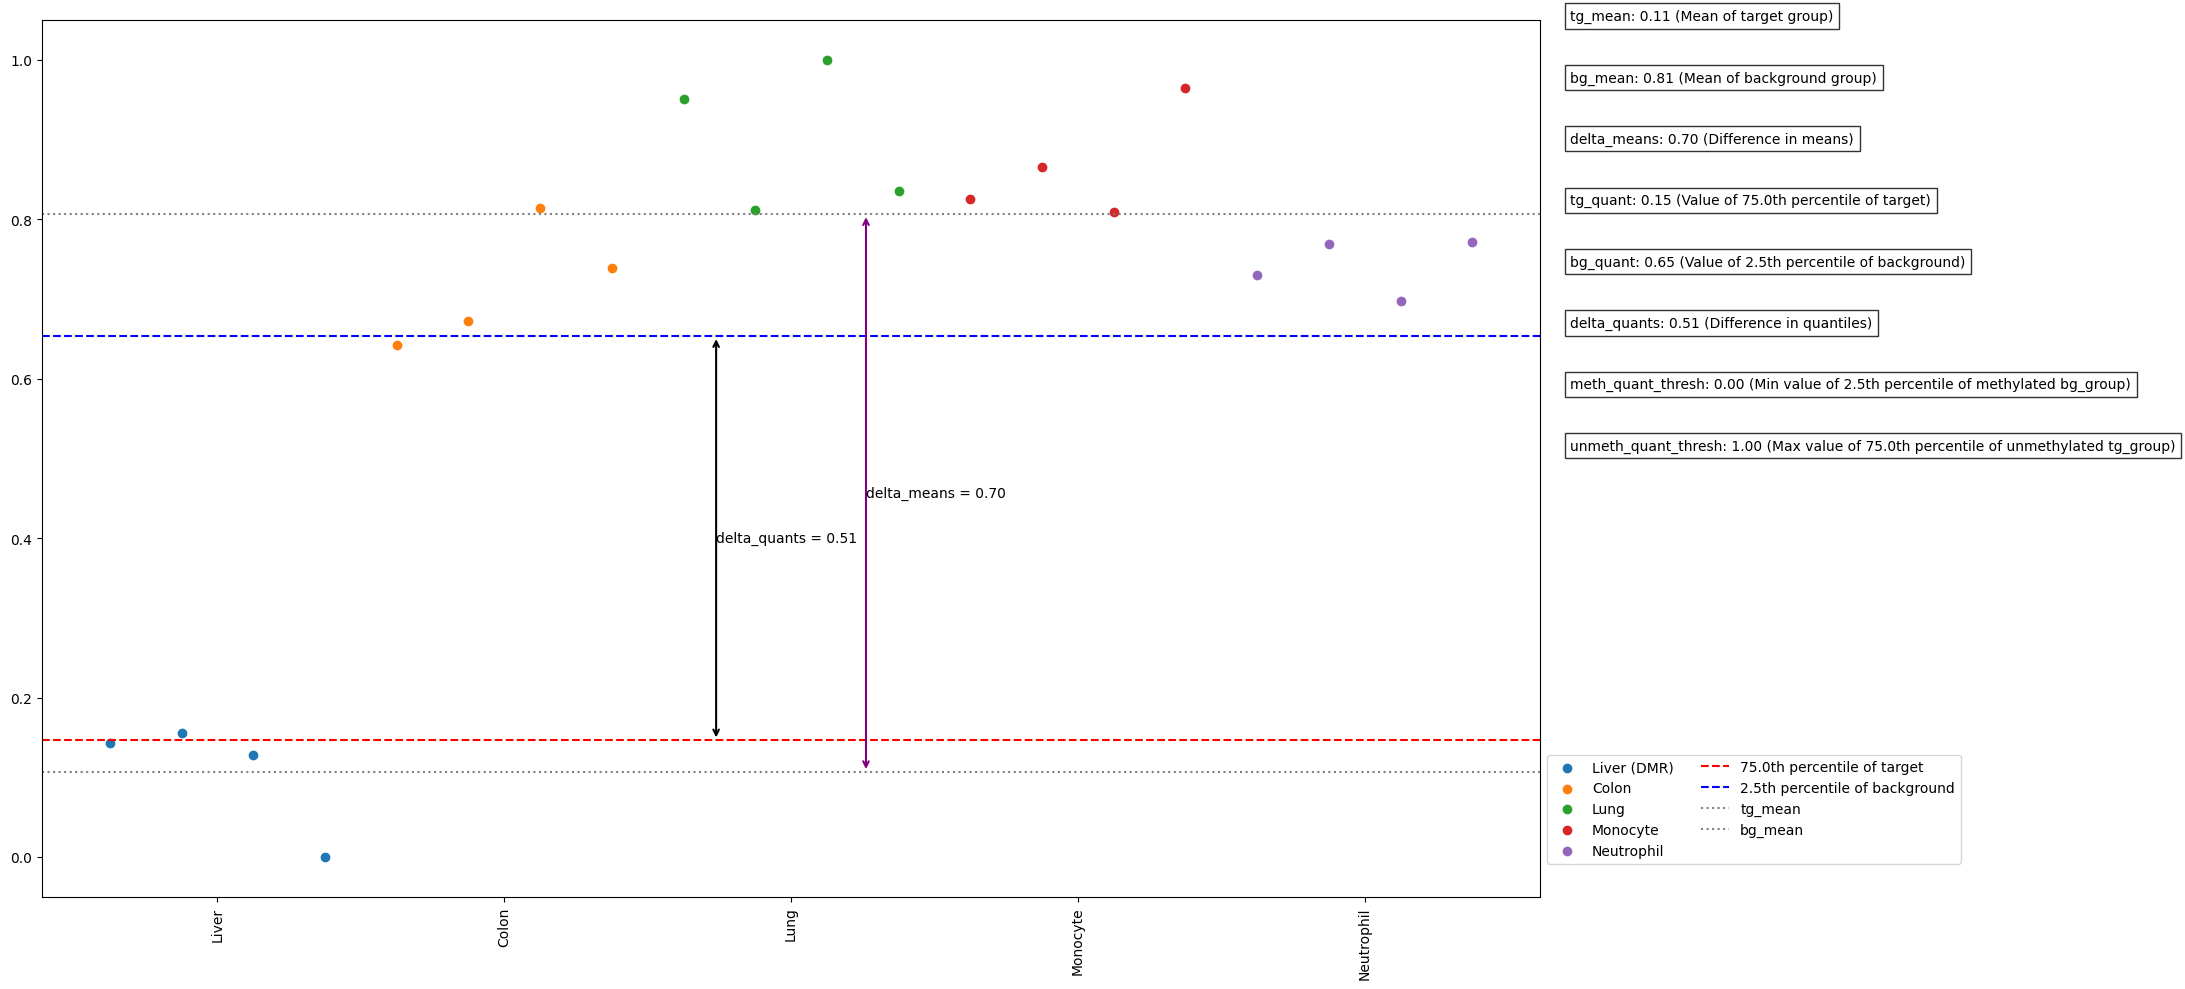

In [18]:
print(random_region_name)
plot_dmr_with_highlight2(df, random_region_name, 'Liver', tissue_groups, args=args)

Target = ['Liver_0', 'Liver_1', 'Liver_2', 'Liver_3']
Background = ['Colon_0', 'Colon_1', 'Colon_2', 'Colon_3', 'Lung_0', 'Lung_1', 'Lung_2', 'Lung_3', 'Monocyte_0', 'Monocyte_1', 'Monocyte_2', 'Monocyte_3', 'Neutrophil_0', 'Neutrophil_1', 'Neutrophil_2', 'Neutrophil_3']
Calculating delta_quants between target and background using: background_quantile - target_quantile
Background quantile = 0.6532131301868032
Target quantile = 0.146384130433534
observed_delta_quants = 0.5068289997532691
perm_target_data shape is (500, 4)
perm_background_data shape is (500, 16)


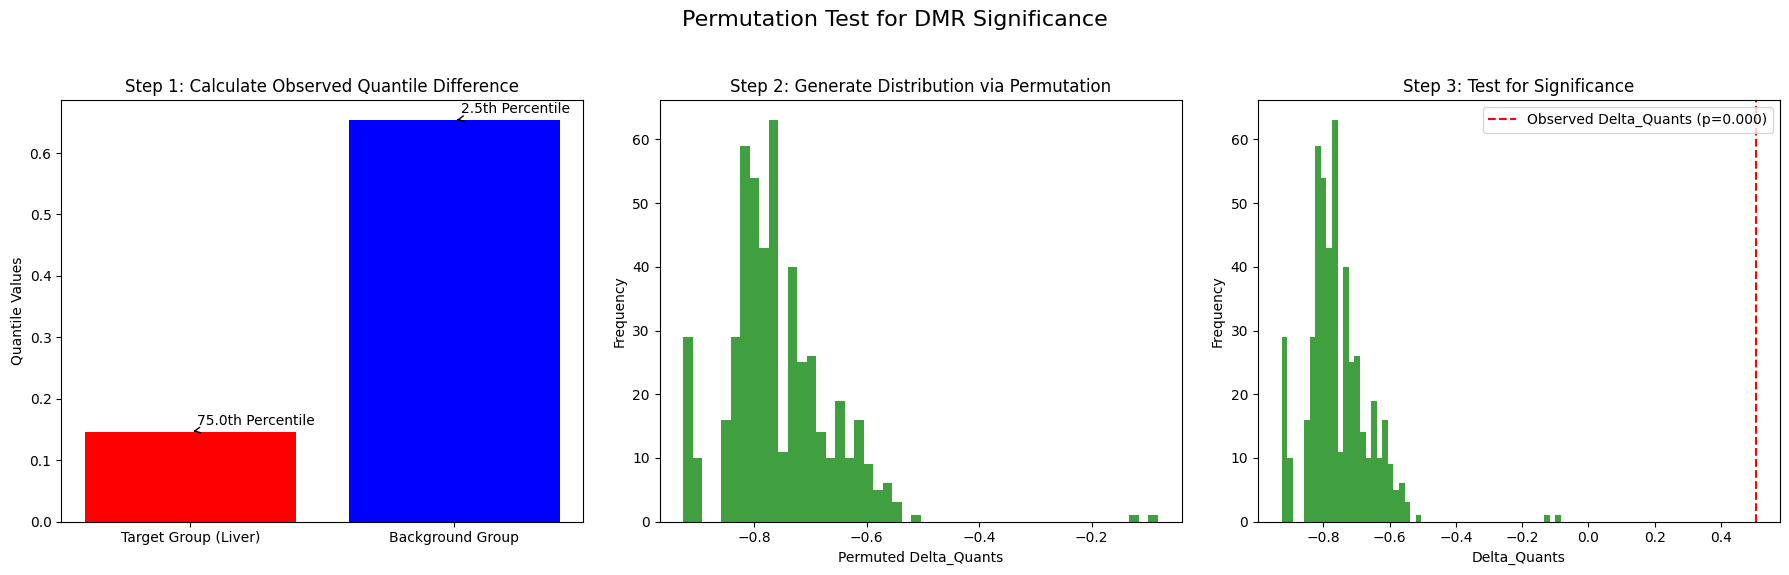

In [19]:
# Execute permutation test
observed_delta_quants, p_value, permuted_delta_quants = vectorized_permutation_test(df, 
                                                                                    random_region_name,
                                                                                    tg_names,
                                                                                    bg_names,
                                                                                   target_quantile=0.75,
                                                                                    background_quantile=0.025)





fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle("Permutation Test for DMR Significance", fontsize=16)

# Plot 1: Illustration of Permutation Test
axes[0].bar([0, 1], [np.nanquantile(df.loc[random_region_name, tg_names].values, target_quantile), 
                     np.nanquantile(df.loc[random_region_name, bg_names].values, background_quantile)], color=['red', 'blue'])
axes[0].set_xticks([0, 1])
axes[0].set_xticklabels(['Target Group (Liver)', 'Background Group'])
axes[0].set_ylabel("Quantile Values")
axes[0].set_title("Step 1: Calculate Observed Quantile Difference")
axes[0].annotate(f'{target_quantile*100}th Percentile', xy=(0, np.nanquantile(df.loc[random_region_name, tg_names].values, target_quantile)), xytext=(5, 5), textcoords='offset points', arrowprops=dict(facecolor='black', arrowstyle='->'))
axes[0].annotate(f'{background_quantile*100}th Percentile', xy=(1, np.nanquantile(df.loc[random_region_name, bg_names].values, background_quantile)), xytext=(5, 5), textcoords='offset points', arrowprops=dict(facecolor='black', arrowstyle='->'))




# Plot 2: Distribution of permuted delta_quants
axes[1].hist(permuted_delta_quants, bins=50, alpha=0.75, color='green')
axes[1].set_xlabel("Permuted Delta_Quants")
axes[1].set_ylabel("Frequency")
axes[1].set_title("Step 2: Generate Distribution via Permutation")

# Plot 3: Observed delta_quants significance
axes[2].hist(permuted_delta_quants, bins=50, alpha=0.75, color='green')
axes[2].axvline(x=observed_delta_quants, color='red', linestyle='dashed', linewidth=1.5, label=f'Observed Delta_Quants (p={p_value:.3f})')
axes[2].legend(loc='upper right')
axes[2].set_xlabel("Delta_Quants")
axes[2].set_ylabel("Frequency")
axes[2].set_title("Step 3: Test for Significance")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### Testing on real data

TAPSbeta_hmm.healthy_high_cov_samples.test5_2hiddenstates_mincov3_astair_snp_filter.Filtered_blocks.large_blocks_4cpg
CAPS_hmm.healthy_high_cov_samples.test5_2hiddenstates_mincov3_astair_snp_filter.Filtered_blocks.large_blocks_4cpg
TAPSbeta_hmm.tumour_samples.test5_2hiddenstates_mincov3_astair_snp_filter.Filtered_blocks.large_blocks_4cpg
CAPS_hmm.tumour_samples.test5_2hiddenstates_mincov3_astair_snp_filter.Filtered_blocks.large_blocks_4cpg
TAPSbeta_hmm.all_samples.test5_2hiddenstates_mincov3_astair_snp_filter.Filtered_blocks.large_blocks_4cpg
CAPS_hmm.all_samples.test5_2hiddenstates_mincov3_astair_snp_filter.Filtered_blocks.large_blocks_4cpg
TAPSbeta_hmm.healthy_high_cov_samples.test6_2hiddenstates_astair_snp_filter.Filtered_blocks.large_blocks_4cpg
CAPS_hmm.healthy_high_cov_samples.test6_2hiddenstates_astair_snp_filter.Filtered_blocks.large_blocks_4cpg
TAPSbeta_hmm.tumour_samples.test6_2hiddenstates_astair_snp_filter.Filtered_blocks.large_blocks_4cpg
CAPS_hmm.tumour_samples.test6_2hid

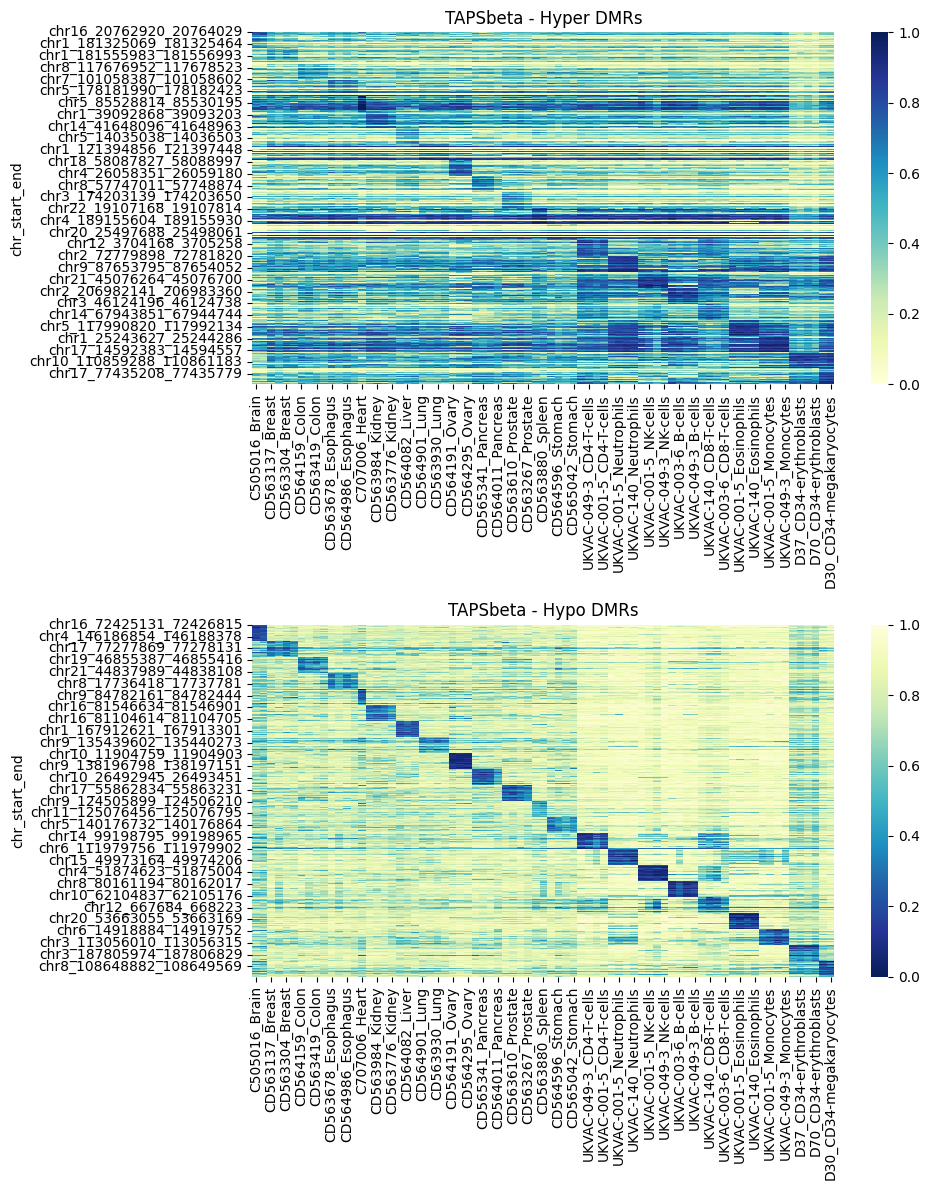

In [20]:
with open('/well/ludwig/users/dyp502/tissue_atlas_v3/metadata/Atlas_V3_Metadata_New.pickle', 'rb') as f:
    project_metadata = pickle.load(f)

# Load all the variables into memory    
project_dir = project_metadata['project_dir']
atlas_dir = project_metadata['atlas_dir'] 
metadata_dir = project_metadata['metadata_dir']
gene_exp_dir = project_metadata['gene_exp_dir']
intersections_dir = project_metadata['intersections_dir']
id_tissue_map = project_metadata["id_tissue_map"]
tissue_id_map = project_metadata["tissue_id_map"]
blood_cell_types = project_metadata["blood_cell_types"]
somatic_tissue_types = project_metadata["somatic_tissue_types"]
healthy_tissue_types = project_metadata["healthy_tissue_types"]
cancer_tissue_types = project_metadata["cancer_tissue_types"]
diseased_tissue_types = project_metadata["diseased_tissue_types"]
tissues_with_tumour = project_metadata["tissues_with_tumour"]
tissue_order = project_metadata["tissue_order"]
genomic_features = project_metadata["genomic_features"]
sample_outliers = project_metadata["sample_outliers"]
healthy_high_cov_samples = project_metadata["healthy_high_cov_samples"]
genomic_feature_colnames = project_metadata["genomic_feature_colnames"]
genomic_regions_dir = project_metadata['genomic_regions_dir']
    
healthy_high_cov_samples += tissue_id_map['Erythroblasts']
healthy_high_cov_samples += tissue_id_map['Megakaryocytes']

healthy_tissue_types = [u for u in healthy_tissue_types if u not in ['Bone-Marrow','Thymus']]



healthy_high_cov_samples = []
for tissue in tissue_id_map:
    if (tissue in healthy_tissue_types):
        for sample in tissue_id_map[tissue]:
            if (sample not in sample_outliers):
                healthy_high_cov_samples.append(sample)

tumour_samples = [sample for tissue in cancer_tissue_types for sample in tissue_id_map[tissue]]
all_samples = [sample for tissue in tissue_id_map.keys() for sample in tissue_id_map[tissue]]
all_samples = [u for u in all_samples if u not in sample_outliers]

sample_list_dict = {'healthy_high_cov_samples':healthy_high_cov_samples,
                    'tumour_samples':tumour_samples,
                    'all_samples':all_samples,
                    }

tissue_types_dict = {'healthy_high_cov_samples':healthy_tissue_types,
                    'tumour_samples':cancer_tissue_types,
                    'all_samples':tissue_order,
                    }

# test_name = "test3_fixed_state"

test_name = f"test5_2hiddenstates_mincov3_astair_snp_filter"
# test_name = f"test6_2hiddenstates_astair_snp_filter"

block_suffixes = []
# for filter_name in ['Grail_filtering_criteria','relaxed_filter_2cpg']:
for test_name in [f"test5_2hiddenstates_mincov3_astair_snp_filter","test6_2hiddenstates_astair_snp_filter"]:
    for filter_name in ["large_blocks_4cpg"]:
        for sample_grouping in sample_list_dict.keys():
                for exp in ["TAPSbeta","CAPS"]:
                    suffix = f"{exp}_hmm.{sample_grouping}.{test_name}.Filtered_blocks.{filter_name}"
                    print(suffix)
                    block_suffixes.append(suffix)



test_name = "test5_2hiddenstates_mincov3_astair_snp_filter"
# test_name = f"test6_2hiddenstates_astair_snp_filter"
filter_name = "large_blocks_4cpg"
# filter_name = "relaxed_filter_2cpg"
sample_grouping = list(sample_list_dict.keys())[0]




dmr_dir  = "/well/ludwig/users/dyp502/tissue_atlas_v3/dmr/"



segment_method = "hmm"

for samples_exp in ['TAPSbeta','CAPS'][0:1]:
    dmbs = pd.read_csv(dmr_dir +  f"{samples_exp}_samples.{sample_grouping}.{samples_exp}_{segment_method}.{sample_grouping}.{test_name}.Filtered_blocks.{filter_name}.Top300_block_DMBs.csv", sep='\t')    

    # Set 'chr_start_end' as the index of the DataFrame
    dmbs.set_index('chr_start_end', inplace=True)

    # Split the data into hyper and hypo
    hyper_dmbs = dmbs.loc[dmbs['Hyper_or_Hypo']=='Hyper'].dropna()
    hypo_dmbs = dmbs.loc[dmbs['Hyper_or_Hypo']=='Hypo'].dropna()
    hyper_df = hyper_dmbs[[u for u in hyper_dmbs.columns if u in list(id_tissue_map.keys())]]
    hypo_df = hypo_dmbs[[u for u in hypo_dmbs.columns if u in list(id_tissue_map.keys())]]
    tissue_sample_order = []
    for tissue in healthy_tissue_types:
        tissue_sample_order.extend([u for u in tissue_id_map[tissue] if u in hyper_dmbs.columns])

    fig, axs = plt.subplots(2, 1, figsize=(10, 12))
    sns.heatmap(hyper_df[tissue_sample_order], cmap='YlGnBu', ax=axs[0])
    axs[0].set_title(f'{samples_exp} - Hyper DMRs')

    sns.heatmap(hypo_df[tissue_sample_order], cmap='YlGnBu_r', ax=axs[1])
    axs[1].set_title(f'{samples_exp} - Hypo DMRs')


    # Show the plot
    plt.tight_layout()
    plt.show()


In [21]:
hypo_dmbs.loc[hypo_dmbs['selected_tissue']=="Pancreas"]

CD564159_Colon  CD563663_Colon  CD563419_Colon  \
chr_start_end                                                               
chr10_97787438_97788510          0.876500        0.823417        0.865667   
chr5_1702135_1702354             0.825071        0.858857        0.799357   
chr16_25217304_25217429          0.696000        0.785714        0.801000   
chr9_133065193_133066286         0.875714        0.861643        0.871679   
chr1_180254217_180254342         0.844333        0.879000        0.846833   
...                                   ...             ...             ...   
chr10_116652484_116652943        0.755000        0.805200        0.749400   
chr16_25218378_25218826          0.784375        0.797875        0.815750   
chr6_113643783_113644194         0.759417        0.795583        0.780333   
chr7_98212452_98212551           0.775000        0.896667        0.933333   
chr22_50483648_50484444          0.687167        0.648375        0.715625   

                           CD565189_Colon  CD564242_Prostate  \
chr_start_end                                                  
chr10_97787438_97788510          0.828583           0.835667   
chr5_1702135_1702354             0.850071           0.865643   
chr16_25217304_25217429          0.784286           0.785714   
chr9_133065193_133066286         0.836571           0.907714   
chr1_180254217_180254342         0.827167           0.816000   
...                                   ...                ...   
chr10_116652484_116652943        0.809000           0.837600   
chr16_25218378_25218826          0.694250           0.762375   
chr6_113643783_113644194         0.668250           0.830417   
chr7_98212452_98212551           0.866667           0.694500   
chr22_50483648_50484444          0.677750           0.815375   

                           CD563610_Prostate  CD563685_Prostate  \
chr_start_end                                                     
chr10_97787438_97788510             0.861333           0.890083   
chr5_1702135_1702354                0.874429           0.918286   
chr16_25217304_25217429             0.787000           0.912429   
chr9_133065193_133066286            0.910679           0.933964   
chr1_180254217_180254342            0.872833           0.848167   
...                                      ...                ...   
chr10_116652484_116652943           0.884000           0.904200   
chr16_25218378_25218826             0.744250           0.823875   
chr6_113643783_113644194            0.813167           0.798583   
chr7_98212452_98212551              0.696333           0.900667   
chr22_50483648_50484444             0.798208           0.853917   

                           CD563267_Prostate  CD565017_Spleen  \
chr_start_end                                                   
chr10_97787438_97788510             0.848250         0.837083   
chr5_1702135_1702354                0.838214         0.726286   
chr16_25217304_25217429             0.769286         0.866857   
chr9_133065193_133066286            0.885286         0.898250   
chr1_180254217_180254342            0.849333         0.844833   
...                                      ...              ...   
chr10_116652484_116652943           0.859400         0.847600   
chr16_25218378_25218826             0.802000         0.832000   
chr6_113643783_113644194            0.832667         0.855000   
chr7_98212452_98212551              0.333167         0.333333   
chr22_50483648_50484444             0.835500         0.861417   

                           CD563880_Spleen  ...   tg_mean   bg_mean  \
chr_start_end                               ...                       
chr10_97787438_97788510           0.862833  ...  0.238333  0.849763   
chr5_1702135_1702354              0.739000  ...  0.197875  0.843411   
chr16_25217304_25217429           0.889429  ...  0.255929  0.849575   
chr9_133065193_133066286          0.875750  ...  0.305250  0.880681   
chr1_180254217_180254342          0.786000  ... 

### Make demo plot

Target = ['CD564797_Liver', 'CD564082_Liver', 'CD563257_Liver']
Background = ['C505016_Brain', 'C707004_Brain', 'CD563137_Breast', 'CD564068_Breast', 'CD563304_Breast', 'CD564368_Breast', 'CD564159_Colon', 'CD563663_Colon', 'CD563419_Colon', 'CD565189_Colon', 'CD563678_Esophagus', 'CD565252_Esophagus', 'CD564986_Esophagus', 'CD565136_Esophagus', 'C707006_Heart', 'CD564241_Kidney', 'CD563984_Kidney', 'CD563778_Kidney', 'CD563776_Kidney', 'CD564901_Lung', 'CD564511_Lung', 'CD563930_Lung', 'CD563854_Lung', 'CD564191_Ovary', 'CD563544_Ovary', 'CD564295_Ovary', 'CD564404_Pancreas', 'CD565341_Pancreas', 'CD564844_Pancreas', 'CD564011_Pancreas', 'CD564242_Prostate', 'CD563610_Prostate', 'CD563685_Prostate', 'CD563267_Prostate', 'CD565017_Spleen', 'CD563880_Spleen', 'CD563430_Stomach', 'CD564596_Stomach', 'CD563162_Stomach', 'CD565042_Stomach', 'UKVAC-140_CD4-T-cells', 'UKVAC-049-3_CD4-T-cells', 'UKVAC-003-6_CD4-T-cells', 'UKVAC-001-5_CD4-T-cells', 'UKVAC-049-3_Neutrophils', 'UKVAC-001-5_Neutr

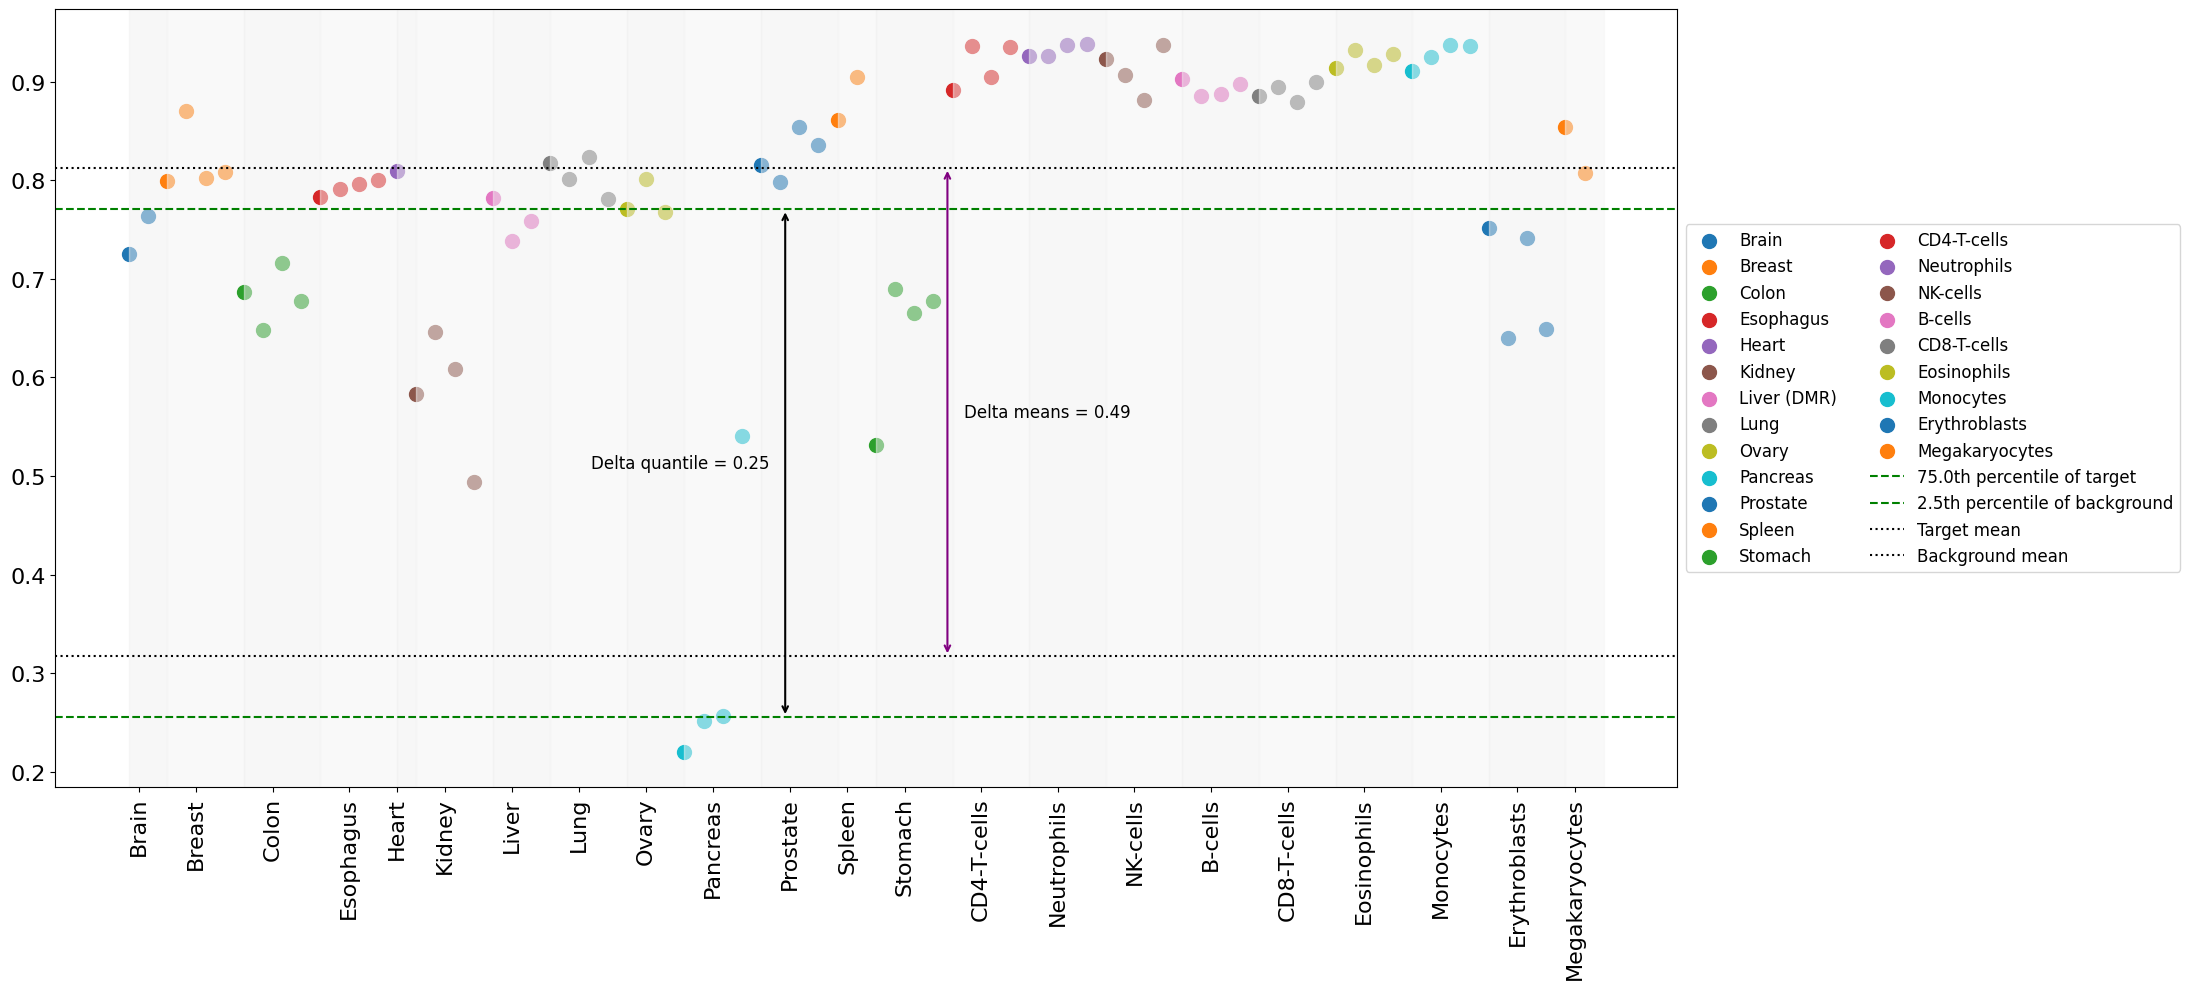

In [51]:
# dmr_df = hypo_dmbs#[tissue_sample_order]
real_target_names = [u for u in tissue_id_map['Liver'] if u in dmr_df.columns]
real_background_names = [u for u in tissue_sample_order if u not in real_target_names]

df = hypo_dmbs
target_tissue = "Liver"
tissue_groups = healthy_tissue_types
tg_names=real_target_names
bg_names=real_background_names
args=args
hypo=True,
real_data=True,
tissue_id_map=tissue_id_map
dmr_index = "chr22_50483648_50484444"
    


    
    
tick_labelsize = 16  # Adjust as needed for xtick and ytick labels
annotation_fontsize = 12  # Adjust as needed for annotations
legend_fontsize = 12  # Adjust as needed for legend
marker_size=100
    
    
fig, ax = plt.subplots(figsize=(22, 10))
colors = itertools.cycle(plt.get_cmap('tab10').colors)
col_pos = 0

#     print(df.columns)
#     dmr_df = df.filter(regex='|'.join(tissue_groups))

regex_pattern = '(?i)' + '|'.join(tissue_groups)
# Filter the DataFrame using the case-insensitive regular expression
dmr_df = df.filter(regex=regex_pattern)
#     print(dmr_df.columns)

if tg_names:
    tg_names = [u for u in tg_names if u in list(df.columns)]
    bg_names = [u for u in bg_names if u in list(df.columns)]
else:
    tg_names = [u for u in dmr_df.columns if target_tissue in u]
    bg_names = [u for u in dmr_df.columns if u not in tg_names]



# Define two light colors for shading
light_color1 = '#f0f0f0'  # Light grey
# light_color2 = '#ffe6e6'  # Even lighter grey
light_color2 = '#f5f5f5'  # A slightly different very light grey
col_pos = 0
previous_col_pos = 0  # To keep track of the start of each tissue group
use_first_color = True  # Flag to alternate colors

xticks_positions = []  # List to store the x-axis tick positions
xticks_labels = []  # List to store the x-axis tick labels

for tissue in tissue_groups:
    if real_data:
        tissue_columns = [col for col in tissue_id_map[tissue] if col in df.columns]
        meth_ratios_tissue = df.loc[dmr_index, tissue_columns]
    else:
        tissue_columns = [col for col in df.columns if col.startswith(tissue)]
        meth_ratios_tissue = df.loc[dmr_index, tissue_columns]

#         print(meth_ratios_tissue)
    x_tissue = np.arange(col_pos, col_pos + len(tissue_columns))
    col_pos += len(tissue_columns)

    # Add x-axis tick positions and labels
    xticks_positions.append(np.mean(x_tissue))
    xticks_labels.append(tissue)

    if tissue == target_tissue:
        ax.scatter(x_tissue, meth_ratios_tissue, color=next(colors), label=f"{tissue} (DMR)",s=marker_size)
    else:
        ax.scatter(x_tissue, meth_ratios_tissue, color=next(colors), label=f"{tissue}",s=marker_size)

        
  # Add vertical shading for each tissue group
    if use_first_color:
        ax.axvspan(previous_col_pos, col_pos, color=light_color1, alpha=0.5)
        use_first_color = False
    else:
        ax.axvspan(previous_col_pos, col_pos, color=light_color2, alpha=0.5)
        use_first_color = True
    
    previous_col_pos = col_pos  # Update the start position for the next group


ax.set_xticks(xticks_positions)
ax.set_xticklabels(xticks_labels,rotation=90,fontsize=tick_labelsize)
ax.tick_params(axis='y', labelsize=tick_labelsize) 


dmr_values = {
'tg_mean': df.loc[dmr_index, 'tg_mean'],
'bg_mean': df.loc[dmr_index, 'bg_mean'],
'delta_means': df.loc[dmr_index, 'delta_means'],
'tg_quant': df.loc[dmr_index, 'tg_quant'],
'bg_quant': df.loc[dmr_index, 'bg_quant'],
'delta_quants': df.loc[dmr_index, 'delta_quants'],
'meth_quant_thresh': args['meth_quant_thresh'],
'unmeth_quant_thresh': args['unmeth_quant_thresh']
 }



print(f"Target = {tg_names}")
print(f"Background = {bg_names}")
#     print(dmr_df.columns)


# Debugging: Check if dmr_values contain any non-finite values
if not all(np.isfinite(list(dmr_values.values()))):
    print(f"Warning: dmr_values contain non-finite numbers: {dmr_values}")


#     return dmr_df,dmr_values

if args and dmr_values:
    tg_quant = args['tg_quant']
    bg_quant = args['bg_quant']
    target_quantile = 1 - tg_quant if hypo else tg_quant
    background_quantile = bg_quant if hypo else 1 - bg_quant

    tg_percentile = np.percentile(dmr_df.loc[dmr_index, tg_names], target_quantile * 100)
    bg_percentile = np.percentile(dmr_df.loc[dmr_index, bg_names], background_quantile * 100)

    ax.axhline(y=tg_percentile, linestyle='--', color='green', label=f"{target_quantile * 100:.1f}th percentile of target")
    ax.axhline(y=bg_percentile, linestyle='--', color='green', label=f"{background_quantile * 100:.1f}th percentile of background")

    ax.axhline(y=dmr_values["tg_mean"], linestyle=':', color='black', label=f"Target mean")
    ax.axhline(y=dmr_values["bg_mean"], linestyle=':', color='black', label=f"Background mean")

    # Add vertical arrows for delta_quants and delta_means with better spacing
    arrow_x_pos_quants = 0.45
    arrow_x_pos_means = 0.55

    ax.annotate('', xy=(arrow_x_pos_quants, bg_percentile), xytext=(arrow_x_pos_quants, tg_percentile), xycoords=('axes fraction', 'data'), textcoords=('axes fraction', 'data'),
                arrowprops=dict(arrowstyle='<->', color='black', lw=1.5))
    ax.annotate(f'Delta quantile = {dmr_values["delta_quants"]:.2f}', xy=(arrow_x_pos_quants-0.12, (tg_percentile + bg_percentile) / 2), xycoords=('axes fraction', 'data'), fontsize=annotation_fontsize, va='center', ha='left')

    ax.annotate('', xy=(arrow_x_pos_means, dmr_values["bg_mean"]), xytext=(arrow_x_pos_means, dmr_values["tg_mean"]), xycoords=('axes fraction', 'data'), textcoords=('axes fraction', 'data'),
                arrowprops=dict(arrowstyle='<->', color='purple', lw=1.5))
    ax.annotate(f'Delta means = {dmr_values["delta_means"]:.2f}', xy=(arrow_x_pos_means+0.01, (dmr_values["tg_mean"] + dmr_values["bg_mean"]) / 2), xycoords=('axes fraction', 'data'), fontsize=annotation_fontsize, va='center', ha='left')

#     # Annotations for all metrics with explanations
#     metric_explanations = {
#         'tg_mean': 'Mean of target group',
#         'bg_mean': 'Mean of background group',
#         'delta_means': 'Difference in means',
#         'delta_quants': 'Difference in quantiles',
#         # 'tg_quant': 'Quantile value of target group',
#         "tg_quant": f"Value of {target_quantile * 100:.1f}th percentile of target",
#         'bg_quant': f"Value of {background_quantile * 100:.1f}th percentile of background",
#         'delta_maxmin': 'Difference between max of target and min of background',
#         'meth_quant_thresh':f'Min value of {background_quantile * 100:.1f}th percentile of methylated bg_group',
#         'unmeth_quant_thresh':f'Max value of {target_quantile * 100:.1f}th percentile of unmethylated tg_group',
#     }
#     for idx, (key, value) in enumerate(dmr_values.items()):
#         explanation = metric_explanations.get(key, '')
#         ax.annotate(f'{key}: {value:.2f} ({explanation})', xy=(1.02, 1 - idx * 0.07), xycoords='axes fraction',
#                     fontsize=10, bbox=dict(facecolor='white', alpha=0.8))
else:
    ax.set_xticks(range(len(dmr_df.columns)))
    ax.set_xticklabels(dmr_df.columns, rotation=90)
    ax.set_ylabel("Methylation Ratio")
    ax.set_title(f"DMR at {dmr_index}")

ax.legend(loc='center left', 
          bbox_to_anchor=(1, 0.5),
         ncols=2,fontsize=12)
#     ax.legend(loc='lower left', 
#               bbox_to_anchor=(1.05, 1),
#               fontsize='small',
#              ncols=2)
plt.tight_layout()
# plt.show()

savedir = "/well/ludwig/users/dyp502/thesis/thesis_figures/taps_atlas/"
# plt.savefig(savedir + f'taps_atlas.DMR_schematic.pancreas.png')


Target = ['CD564797_Liver', 'CD564082_Liver', 'CD563257_Liver']
Background = ['C505016_Brain', 'C707004_Brain', 'CD563137_Breast', 'CD564068_Breast', 'CD563304_Breast', 'CD564368_Breast', 'CD564159_Colon', 'CD563663_Colon', 'CD563419_Colon', 'CD565189_Colon', 'CD563678_Esophagus', 'CD565252_Esophagus', 'CD564986_Esophagus', 'CD565136_Esophagus', 'C707006_Heart', 'CD564241_Kidney', 'CD563984_Kidney', 'CD563778_Kidney', 'CD563776_Kidney', 'CD564901_Lung', 'CD564511_Lung', 'CD563930_Lung', 'CD563854_Lung', 'CD564191_Ovary', 'CD563544_Ovary', 'CD564295_Ovary', 'CD564404_Pancreas', 'CD565341_Pancreas', 'CD564844_Pancreas', 'CD564011_Pancreas', 'CD564242_Prostate', 'CD563610_Prostate', 'CD563685_Prostate', 'CD563267_Prostate', 'CD565017_Spleen', 'CD563880_Spleen', 'CD563430_Stomach', 'CD564596_Stomach', 'CD563162_Stomach', 'CD565042_Stomach', 'UKVAC-140_CD4-T-cells', 'UKVAC-049-3_CD4-T-cells', 'UKVAC-003-6_CD4-T-cells', 'UKVAC-001-5_CD4-T-cells', 'UKVAC-049-3_Neutrophils', 'UKVAC-001-5_Neutr

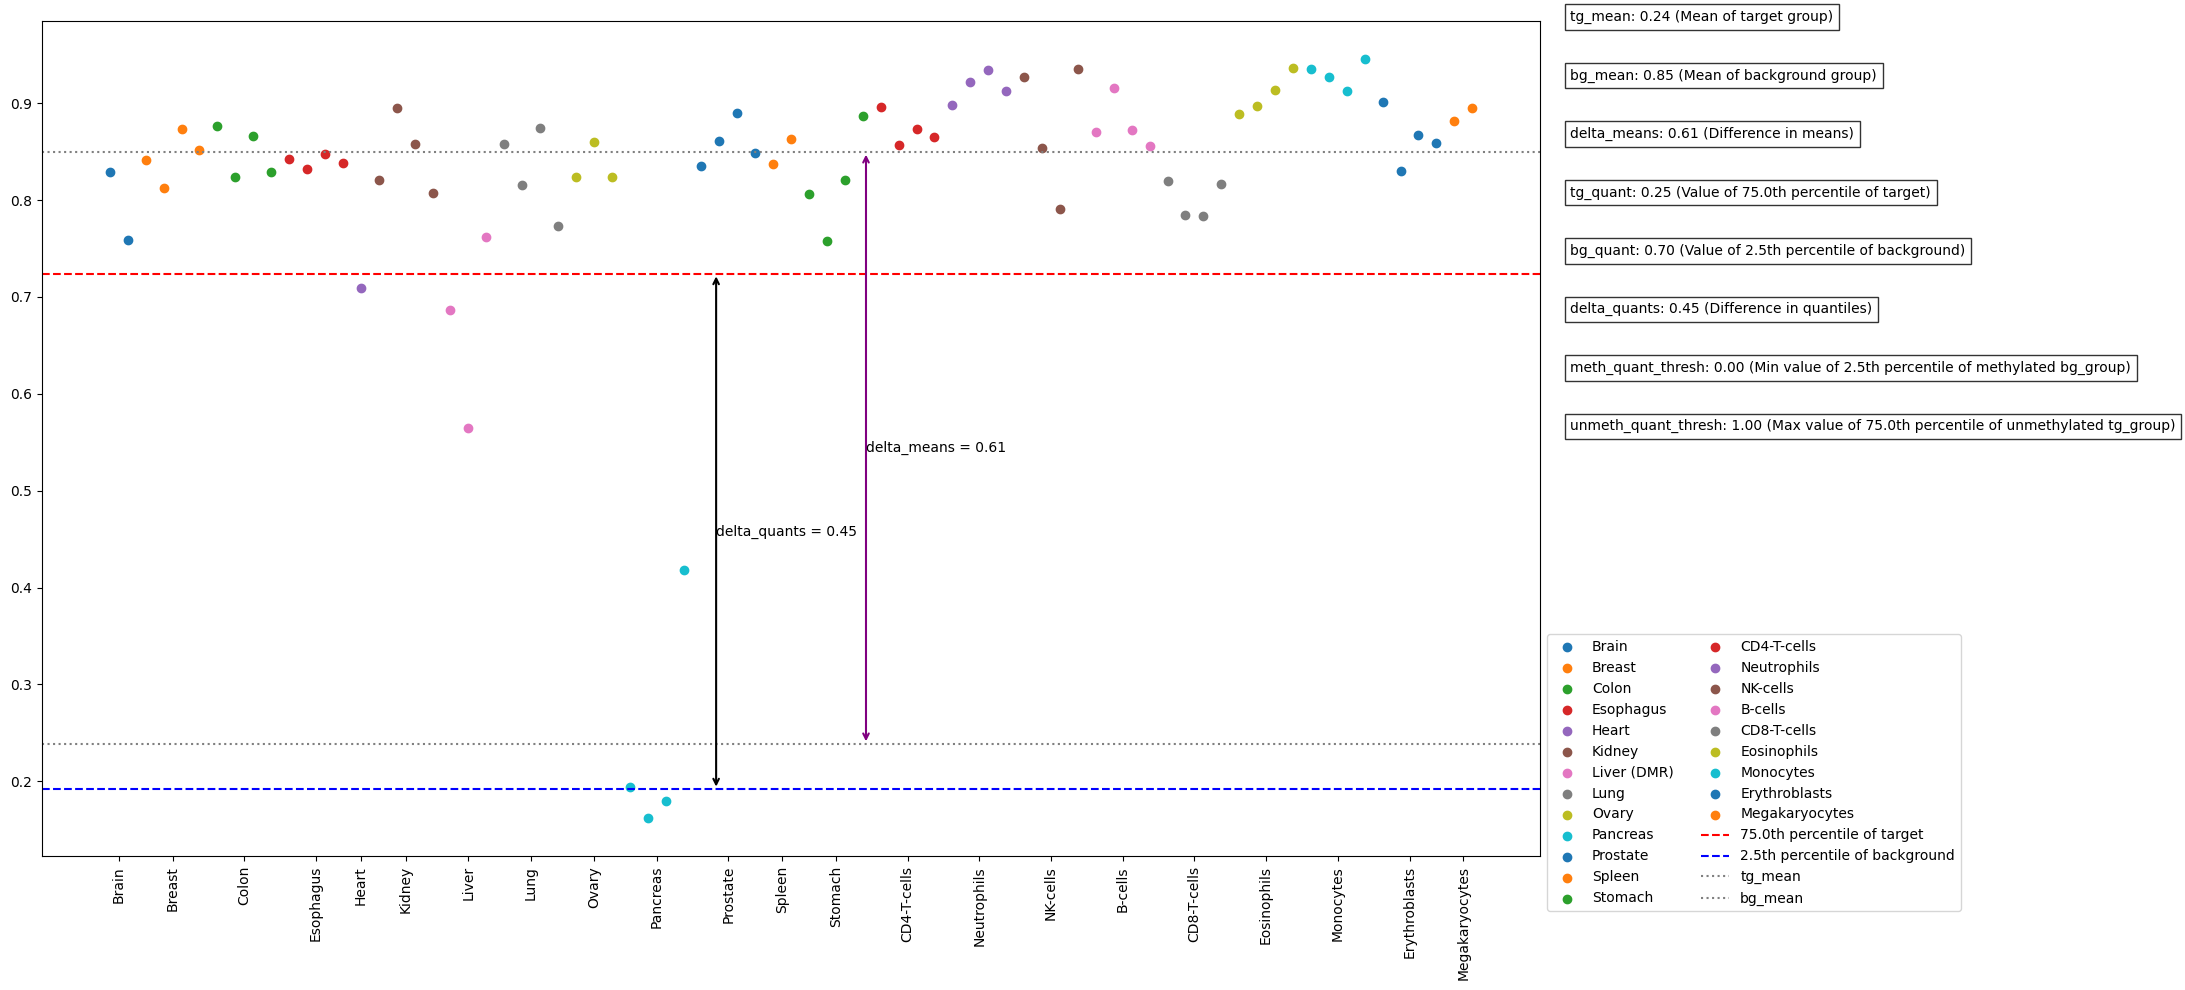

In [27]:
dmr_index = "chr10_97787438_97788510"
dmr_df = hypo_dmbs#[tissue_sample_order]
real_target_names = [u for u in tissue_id_map['Liver'] if u in dmr_df.columns]
real_background_names = [u for u in tissue_sample_order if u not in real_target_names]

plot_dmr_with_highlight2(dmr_df,
                         dmr_index,
                         'Liver', 
                         healthy_tissue_types,
                         tg_names = real_target_names,
                         bg_names = real_background_names,
                         args=args,
                        real_data=True,
                               tissue_id_map=tissue_id_map
                        )

Target = ['CD564797_Liver', 'CD564082_Liver', 'CD563257_Liver']
Background = ['C505016_Brain', 'C707004_Brain', 'CD563137_Breast', 'CD564068_Breast', 'CD563304_Breast', 'CD564368_Breast', 'CD564159_Colon', 'CD563663_Colon', 'CD563419_Colon', 'CD565189_Colon', 'CD563678_Esophagus', 'CD565252_Esophagus', 'CD564986_Esophagus', 'CD565136_Esophagus', 'C707006_Heart', 'CD564241_Kidney', 'CD563984_Kidney', 'CD563778_Kidney', 'CD563776_Kidney', 'CD564901_Lung', 'CD564511_Lung', 'CD563930_Lung', 'CD563854_Lung', 'CD564191_Ovary', 'CD563544_Ovary', 'CD564295_Ovary', 'CD564404_Pancreas', 'CD565341_Pancreas', 'CD564844_Pancreas', 'CD564011_Pancreas', 'CD564242_Prostate', 'CD563610_Prostate', 'CD563685_Prostate', 'CD563267_Prostate', 'CD565017_Spleen', 'CD563880_Spleen', 'CD563430_Stomach', 'CD564596_Stomach', 'CD563162_Stomach', 'CD565042_Stomach', 'UKVAC-140_CD4-T-cells', 'UKVAC-049-3_CD4-T-cells', 'UKVAC-003-6_CD4-T-cells', 'UKVAC-001-5_CD4-T-cells', 'UKVAC-049-3_Neutrophils', 'UKVAC-001-5_Neutr

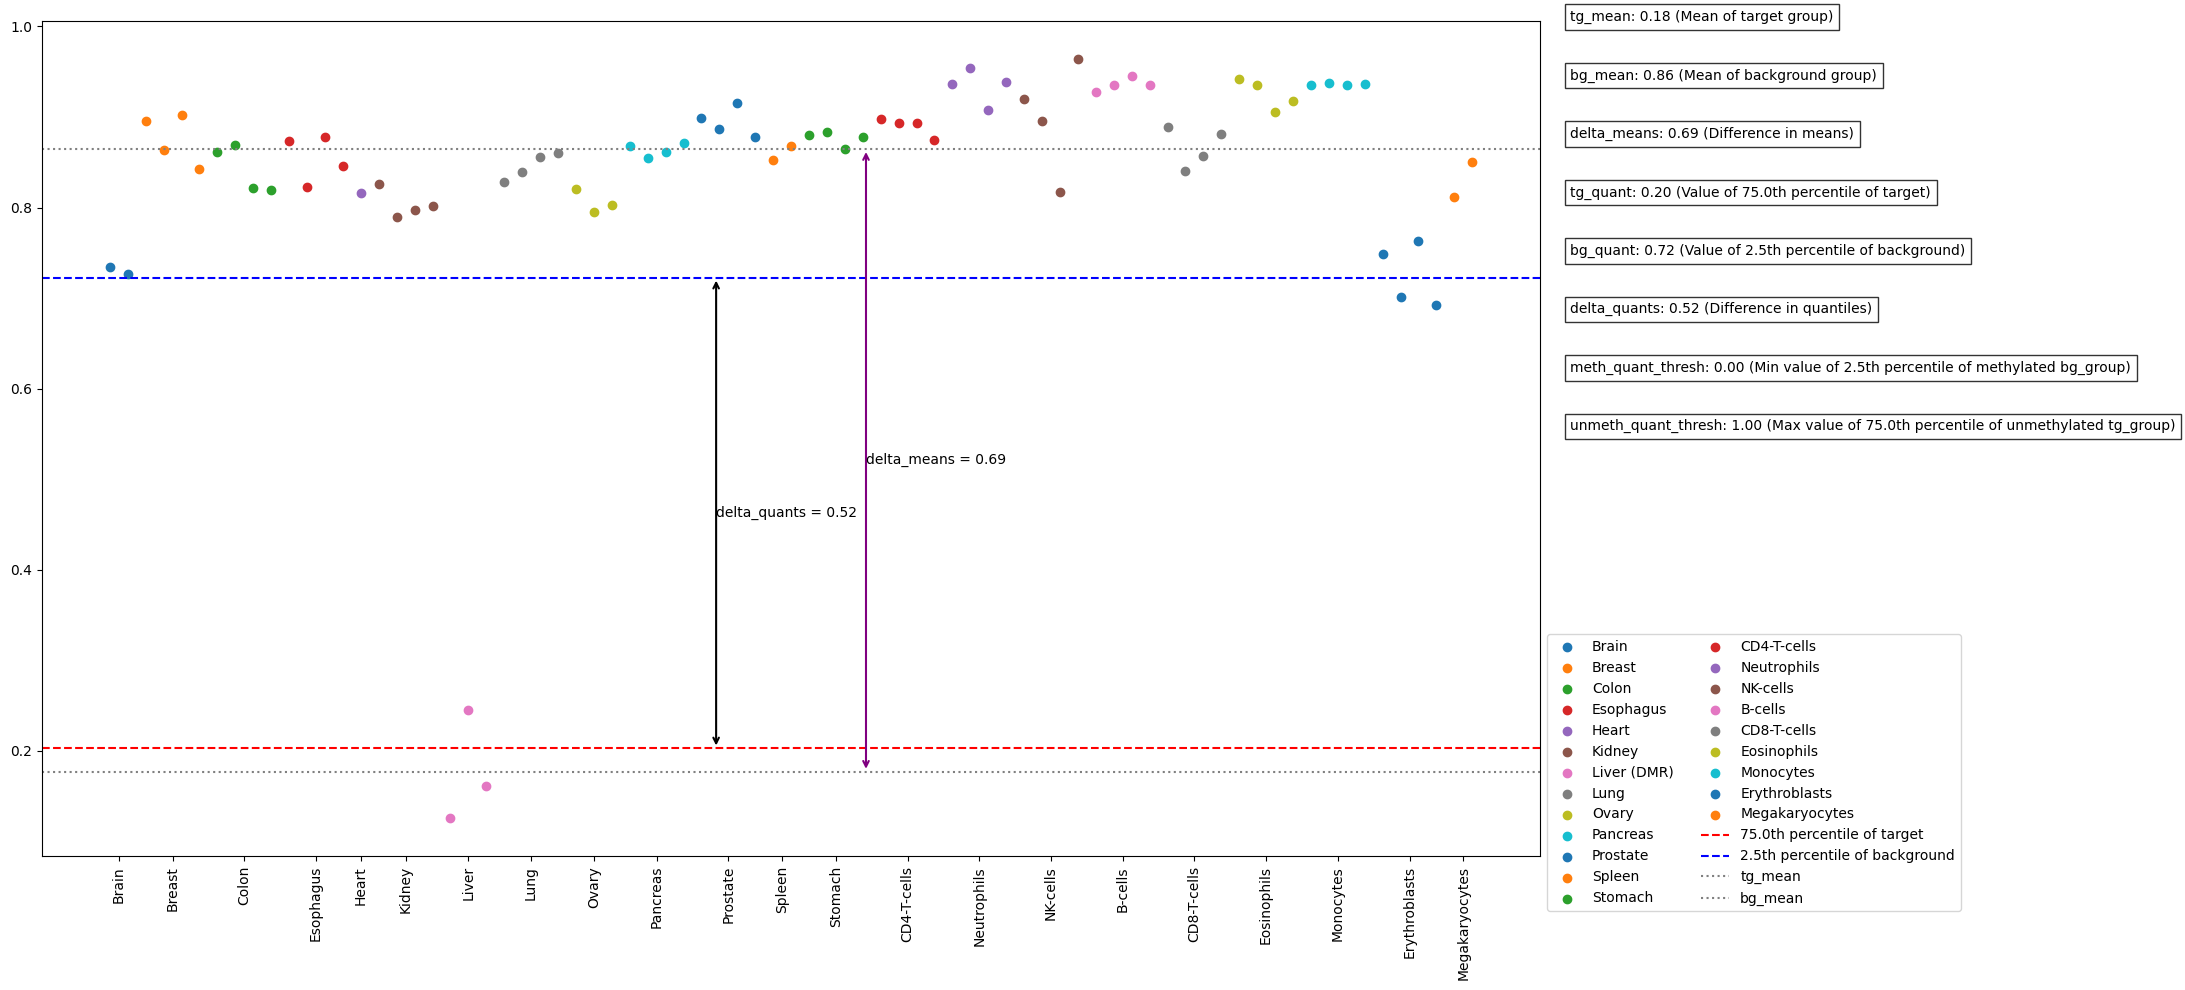

In [33]:
dmr_index = "chr1_11046392_11047248"
dmr_df = hypo_dmbs#[tissue_sample_order]
real_target_names = [u for u in tissue_id_map['Liver'] if u in dmr_df.columns]
real_background_names = [u for u in tissue_sample_order if u not in real_target_names]

plot_dmr_with_highlight2(dmr_df,
                         dmr_index,
                         'Liver', 
                         healthy_tissue_types,
                         tg_names = real_target_names,
                         bg_names = real_background_names,
                         args=args,
                        real_data=True,
                               tissue_id_map=tissue_id_map
                        )

Target = ['CD564797_Liver', 'CD564082_Liver', 'CD563257_Liver']
Background = ['C505016_Brain', 'C707004_Brain', 'CD563137_Breast', 'CD564068_Breast', 'CD563304_Breast', 'CD564368_Breast', 'CD564159_Colon', 'CD563663_Colon', 'CD563419_Colon', 'CD565189_Colon', 'CD563678_Esophagus', 'CD565252_Esophagus', 'CD564986_Esophagus', 'CD565136_Esophagus', 'C707006_Heart', 'CD564241_Kidney', 'CD563984_Kidney', 'CD563778_Kidney', 'CD563776_Kidney', 'CD564901_Lung', 'CD564511_Lung', 'CD563930_Lung', 'CD563854_Lung', 'CD564191_Ovary', 'CD563544_Ovary', 'CD564295_Ovary', 'CD564404_Pancreas', 'CD565341_Pancreas', 'CD564844_Pancreas', 'CD564011_Pancreas', 'CD564242_Prostate', 'CD563610_Prostate', 'CD563685_Prostate', 'CD563267_Prostate', 'CD565017_Spleen', 'CD563880_Spleen', 'CD563430_Stomach', 'CD564596_Stomach', 'CD563162_Stomach', 'CD565042_Stomach', 'UKVAC-140_CD4-T-cells', 'UKVAC-049-3_CD4-T-cells', 'UKVAC-003-6_CD4-T-cells', 'UKVAC-001-5_CD4-T-cells', 'UKVAC-049-3_Neutrophils', 'UKVAC-001-5_Neutr

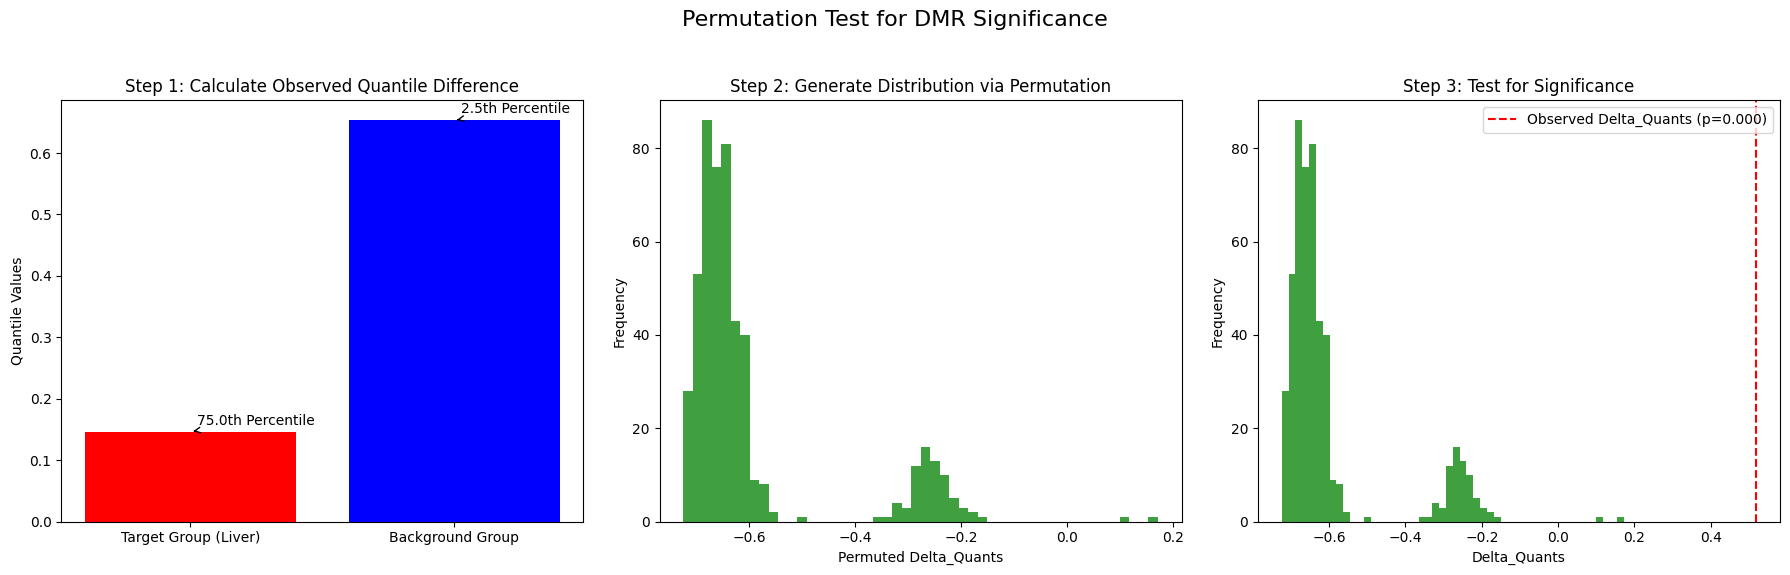

In [35]:


# Execute permutation test
observed_delta_quants, p_value, permuted_delta_quants = vectorized_permutation_test(dmr_df, 
                                                                                    dmr_index,
                                                                                    tg_names = real_target_names,
                                                                                     bg_names = real_background_names,
                                                                                   target_quantile=0.75,
                                                                                    background_quantile=0.025)





fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle("Permutation Test for DMR Significance", fontsize=16)

# Plot 1: Illustration of Permutation Test
axes[0].bar([0, 1], [np.nanquantile(df.loc[random_region_name, tg_names].values, target_quantile), 
                     np.nanquantile(df.loc[random_region_name, bg_names].values, background_quantile)], color=['red', 'blue'])
axes[0].set_xticks([0, 1])
axes[0].set_xticklabels(['Target Group (Liver)', 'Background Group'])
axes[0].set_ylabel("Quantile Values")
axes[0].set_title("Step 1: Calculate Observed Quantile Difference")
axes[0].annotate(f'{target_quantile*100}th Percentile', xy=(0, np.nanquantile(df.loc[random_region_name, tg_names].values, target_quantile)), xytext=(5, 5), textcoords='offset points', arrowprops=dict(facecolor='black', arrowstyle='->'))
axes[0].annotate(f'{background_quantile*100}th Percentile', xy=(1, np.nanquantile(df.loc[random_region_name, bg_names].values, background_quantile)), xytext=(5, 5), textcoords='offset points', arrowprops=dict(facecolor='black', arrowstyle='->'))




# Plot 2: Distribution of permuted delta_quants
axes[1].hist(permuted_delta_quants, bins=50, alpha=0.75, color='green')
axes[1].set_xlabel("Permuted Delta_Quants")
axes[1].set_ylabel("Frequency")
axes[1].set_title("Step 2: Generate Distribution via Permutation")

# Plot 3: Observed delta_quants significance
axes[2].hist(permuted_delta_quants, bins=50, alpha=0.75, color='green')
axes[2].axvline(x=observed_delta_quants, color='red', linestyle='dashed', linewidth=1.5, label=f'Observed Delta_Quants (p={p_value:.3f})')
axes[2].legend(loc='upper right')
axes[2].set_xlabel("Delta_Quants")
axes[2].set_ylabel("Frequency")
axes[2].set_title("Step 3: Test for Significance")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### How do significance tests relate to delta_quants

/tmp/slurm-32262486/ipykernel_98586/126511628.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot['-log10_wilcoxon'] = -np.log10(df_plot['wilcoxon'])
/tmp/slurm-32262486/ipykernel_98586/126511628.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot['-log10_ttest'] = -np.log10(df_plot['ttest'])
/gpfs2/well/ludwig/users/dyp502/miniconda3/envs/tissue_atlas_env3/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc,

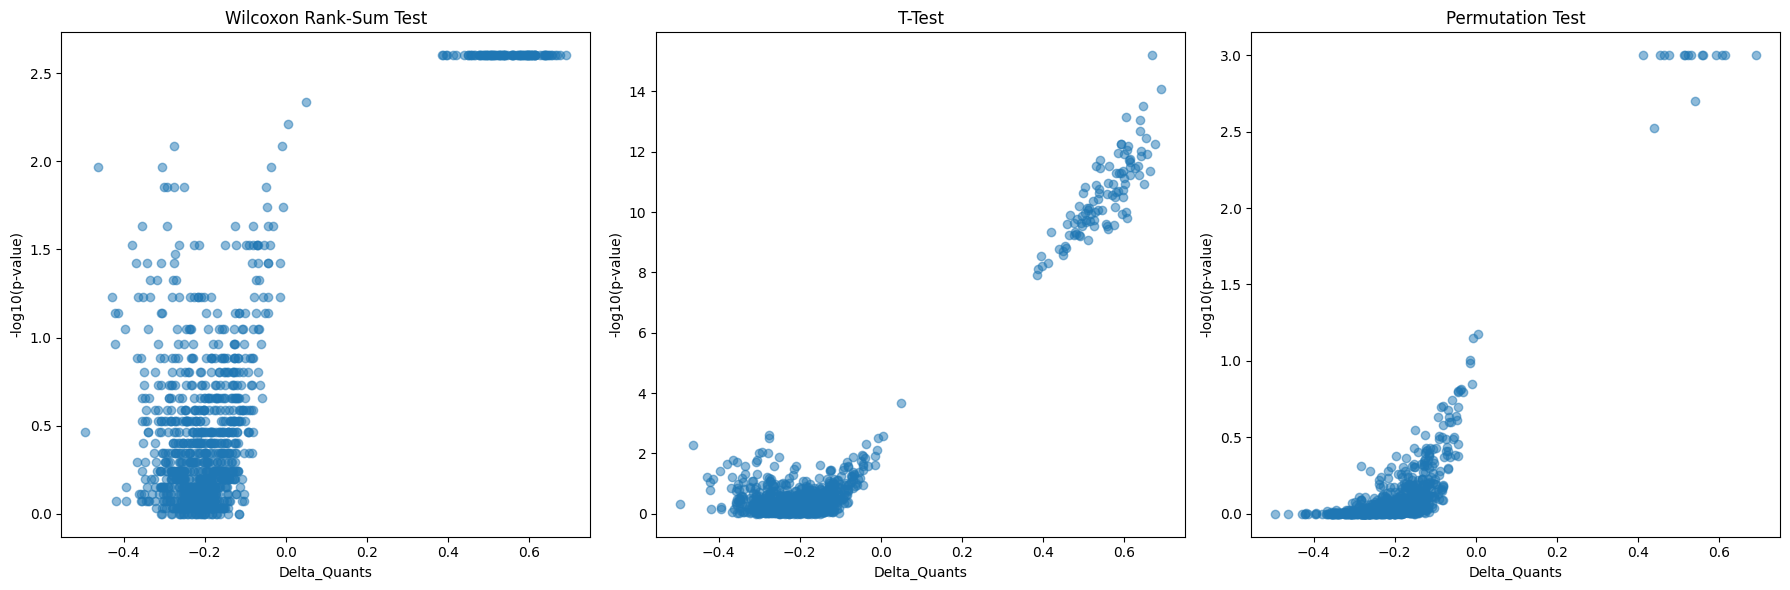

In [17]:


# Extract the relevant columns
df_plot = df[['delta_quants', 'wilcoxon', 'ttest', 'permutation_pvalue']]

# Calculate -log10 of p-values
df_plot['-log10_wilcoxon'] = -np.log10(df_plot['wilcoxon'])
df_plot['-log10_ttest'] = -np.log10(df_plot['ttest'])
df_plot['-log10_permutation'] = -np.log10(df_plot['permutation_pvalue'])

# Create scatter plots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Wilcoxon
axes[0].scatter(df_plot['delta_quants'], df_plot['-log10_wilcoxon'], alpha=0.5)
axes[0].set_title('Wilcoxon Rank-Sum Test')
axes[0].set_xlabel('Delta_Quants')
axes[0].set_ylabel('-log10(p-value)')

# t-test
axes[1].scatter(df_plot['delta_quants'], df_plot['-log10_ttest'], alpha=0.5)
axes[1].set_title('T-Test')
axes[1].set_xlabel('Delta_Quants')
axes[1].set_ylabel('-log10(p-value)')

# Permutation Test
axes[2].scatter(df_plot['delta_quants'], df_plot['-log10_permutation'], alpha=0.5)
axes[2].set_title('Permutation Test')
axes[2].set_xlabel('Delta_Quants')
axes[2].set_ylabel('-log10(p-value)')

plt.tight_layout()
plt.show()


### Hypo DMRs for multiple tissues

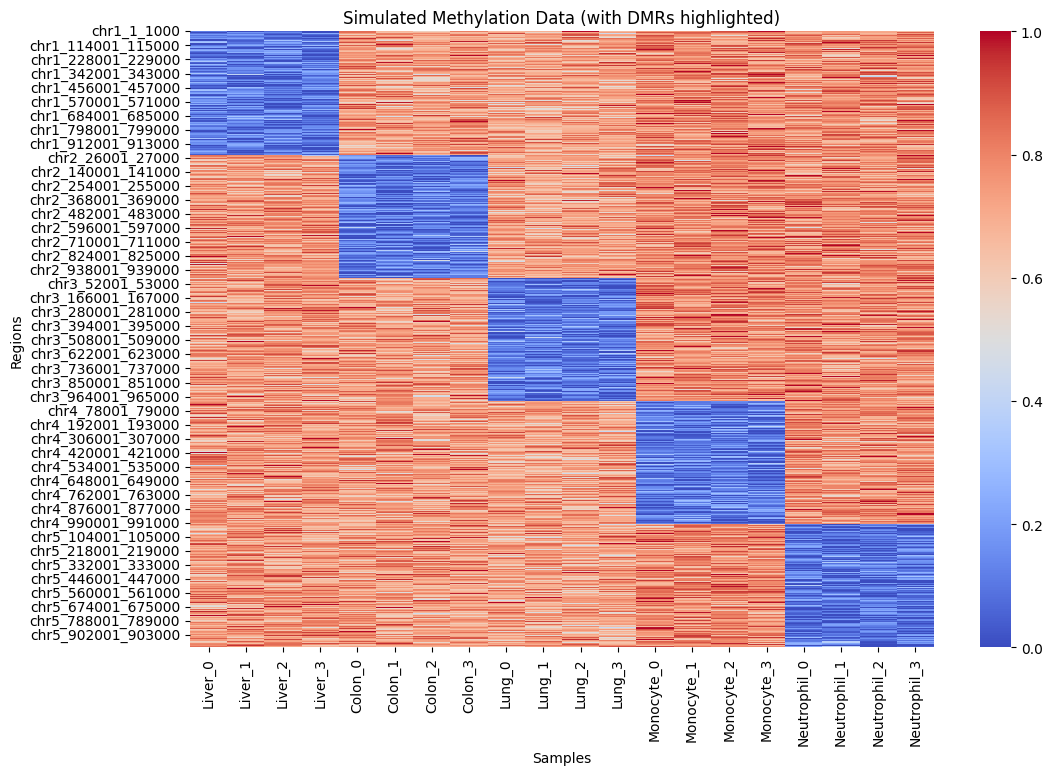

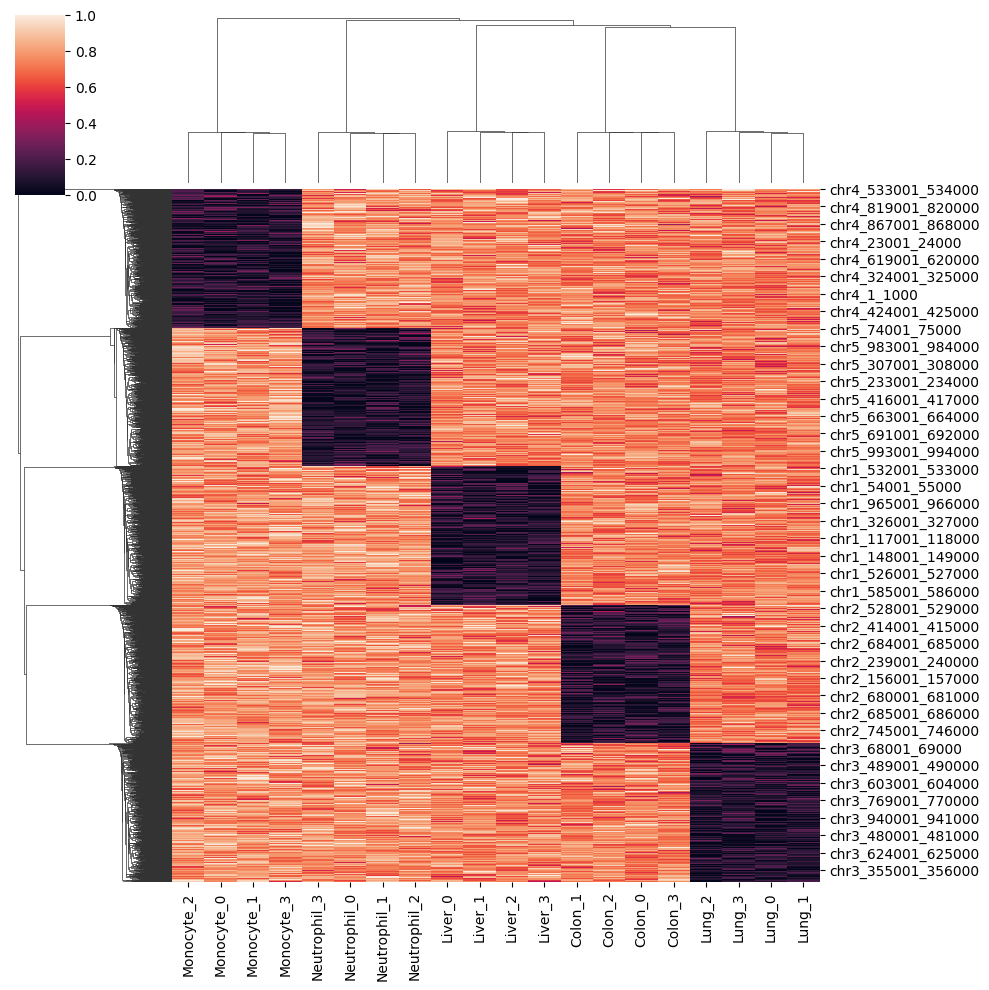

In [39]:
# Parameters for the simulation
num_regions = 1000
num_dmrs = 100  # Number of Liver DMRs
tissue_groups = ['Liver', 'Colon', 'Lung', 'Monocyte', 'Neutrophil']
# mean_values_dmr = [0.1, 0.8, 0.9, 0.9, 0.85]  # Mean methylation ratios for Liver DMRs
mean_values_bg = [0.75, 0.74, 0.72, 0.79, 0.80]  # Mean methylation ratios for background regions

dmr_value = 0.1
mean_values_dmr = mean_values_bg
all_dmrs = []
for k,toi in enumerate(tissue_groups): ## Make each tissue in turn a DMR
    mean_values_bg = [0.75, 0.74, 0.72, 0.79, 0.78] 
    mean_values_dmr = mean_values_bg
    mean_values_dmr[k] = dmr_value
    

    # Create the simulated DataFrame and get the DMR locations
    df, dmr_locations = create_dmr_df_with_background_and_locations(num_regions, 
                                                                    num_dmrs,
                                                                    tissue_groups,
                                                                    mean_values_dmr,
                                                                    mean_values_bg,
                                                                    chrom_start=f"chr{k+1}"
                                                                   )
    df['DMR_label'] = df.index.isin(dmr_locations)
    
    all_dmrs.append(df)
    
    # # Show first few rows of the DataFrame and the DMR locations
    # dmr_df_with_bg.head(), dmr_locations[:10]


    
df = pd.concat(all_dmrs)

all_tissue_names = df.columns[0:-1]
# Plot heatmap of simulated methylation data, highlighting the DMRs
plt.figure(figsize=(12, 8))
sns.heatmap(df.iloc[:,0:-1], cmap="coolwarm", cbar=True)
plt.title("Simulated Methylation Data (with DMRs highlighted)")
plt.xlabel("Samples")
plt.ylabel("Regions")
plt.show()



sns.clustermap(df.iloc[:,0:-1])


In [40]:
# df = df.copy()


# for k,toi in enumerate(tissue_groups):

toi = "Liver"
tissue = toi
df['selected_tissue'] = tissue
tg_names = [f'{tissue}_{i}' for i in range(4)]
bg_names = [u for u in all_tissue_names if u not in tg_names]
# bg_names = [u for u in id_tissue_map.keys() if (u not in tg_names) and (u in tissue_samples_mr.columns)]



args = {
    'tg_names':tg_names,
    'bg_names':bg_names,
    'na_rate_tg': 0.334,
    'na_rate_bg': 0.334,
    'only_hyper': False,
    'only_hypo': False,
#     'delta_means': 0.3,
    'delta_means':0.01, # temporarily setting v easy
    'delta_quants': 0.0,
    'tg_quant': 0.25,
    'bg_quant': 0.025,
    'unmeth_quant_thresh': 1.0,
    'meth_quant_thresh': 0.0,
    'unmeth_mean_thresh': 1.0,
    'meth_mean_thresh': 0.0,
    'pval': 0.05,
    'delta_maxmin': -1,
    'repro':False,
}

tg_names = args['tg_names']
bg_names = args['bg_names']
tg_quant = args['tg_quant']
bg_quant = args['bg_quant']
unmeth_mean_thresh = args['unmeth_mean_thresh']
meth_mean_thresh = args['meth_mean_thresh']
delta_means = args['delta_means']
unmeth_quant_thresh = args['unmeth_quant_thresh']
meth_quant_thresh = args['meth_quant_thresh']
delta_quants = args['delta_quants']
hypo=True
sort_by_delta_quant = True

print(tg_names)
if hypo:
    print(f"Hypo DMRs for {tg_names}, so:")
    target_quantile = 1-tg_quant
    background_quantile = bg_quant

else: # hyper DMRs, so target has high methylation and background has low
    print(f"Hyper DMRs for {tg_names}, so:")

    target_quantile = tg_quant
    background_quantile = 1-bg_quant


print(f"target_quantile: {target_quantile}")
print(f"background_quantile: {background_quantile}")





# ### ------------------------------         Populate metrics          ------------------------------------------------------------

# Compute maxmin
df['delta_maxmin'] = np.abs(df[args['bg_names']].min(axis=1) - df[args['tg_names']].max(axis=1))

# Compute means for target and background
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    df['tg_mean'] = np.nanmean(df[args['tg_names']], axis=1)
    df['bg_mean'] = np.nanmean(df[args['bg_names']], axis=1)


# Change this code to make delta_means always positive for rows containing the target group's DMRs
if hypo:
    df['delta_means'] = df['bg_mean'] - df['tg_mean']
else:
    df['delta_means'] = df['tg_mean'] - df['bg_mean']



# Compute quantiles for target and background - this just computes the values of the quantiles we've set - doesn't do any filtering

df['tg_quant'] = np.nanquantile(df[args['tg_names']], target_quantile, axis=1) # compute quantile, ignoring NaNs
df['bg_quant'] = np.nanquantile(df[args['bg_names']], background_quantile, axis=1)
# df['delta_quants'] = np.abs(df['bg_quant'] - df['tg_quant'])

if hypo:
    df['delta_quants'] = df['bg_quant'] - df['tg_quant'] # if hypo DMR, we expect background methylation to be high and target group methylation to be low
else:
    df['delta_quants'] = df['tg_quant'] - df['bg_quant'] # if hyper DMR, we expect background methylation to be high and target group methylation to be low




['Liver_0', 'Liver_1', 'Liver_2', 'Liver_3']
Hypo DMRs for ['Liver_0', 'Liver_1', 'Liver_2', 'Liver_3'], so:
target_quantile: 0.75
background_quantile: 0.025


In [41]:
df

Liver_0   Liver_1   Liver_2   Liver_3   Colon_0  \
chr1_1_1000          0.123105  0.075401  0.120607  0.119466  0.804162   
chr1_1001_2000       0.112758  0.000000  0.064560  0.000000  0.854204   
chr1_2001_3000       0.210614  0.112468  0.000000  0.000000  0.688191   
chr1_3001_4000       0.132710  0.011792  0.000000  0.019679  0.632037   
chr1_4001_5000       0.016372  0.000000  0.090421  0.208392  0.869818   
...                       ...       ...       ...       ...       ...   
chr5_995001_996000   0.812368  0.829469  0.743860  0.748512  0.739784   
chr5_996001_997000   0.618953  0.821232  0.756447  0.641618  0.579108   
chr5_997001_998000   0.762292  0.797188  0.822210  0.767960  0.612881   
chr5_998001_999000   0.838796  0.723525  0.664500  0.636301  0.746759   
chr5_999001_1000000  0.750031  0.756163  0.623015  0.515100  0.692694   

                      Colon_1   Colon_2   Colon_3    Lung_0    Lung_1  ...  \
chr1_1_1000          0.667237  0.666065  0.807377  0.896002  0.711449  ...   
chr1_1001_2000       0.665751  0.574845  0.809879  0.666577  0.687016  ...   
chr1_2001_3000       0.618293  0.763991  0.671643  0.826525  0.831011  ...   
chr1_3001_4000       0.761070  0.610968  0.724961  0.774342  0.685154  ...   
chr1_4001_5000       0.864055  0.576736  0.673196  0.718805  0.804652  ...   
...                       ...       ...       ...       ...       ...  ...   
chr5_995001_996000   0.820536  0.574905  0.691451  0.717154  0.928037  ...   
chr5_996001_997000   0.847267  0.771363  0.702128  0.632310  0.757248  ...   
chr5_997001_998000   0.832021  0.779816  0.820003  0.812718  0.564925  ...   
chr5_998001_999000   0.635132  0.789578  0.638034  0.588215  0.763026  ...   
chr5_999001_1000000  0.627962  0.768777  0.694333  0.688544  0.867247  ...   

                     Neutrophil_3  DMR_label  selected_tissue  delta_maxmin  \
chr1_1_1000              0.863962      False            Liver      0.470276   
chr1_1001_2000           0.649657      False            Liver      0.462087   
chr1_2001_3000           0.739743      False            Liver      0.403724   
chr1_3001_4000           0.816241      False            Liver      0.465014   
chr1_4001_5000           0.648475      False            Liver      0.368344   
...                           ...        ...              ...           ...   
chr5_995001_996000       0.089478      False            Liver      0.786635   
chr5_996001_997000       0.024041      False            Liver      0.797191   
chr5_997001_998000       0.000000      False            Liver      0.822210   
chr5_998001_999000       0.000000      False            Liver      0.838796   
chr5_999001_1000000      0.196887      False            Liver      0.664208   

                      tg_mean   bg_mean  delta_means  tg_quant  bg_quant  \
chr1_1_1000          0.109645  0.756387     0.646742  0.121232  0.613048   
chr1_1001_2000       0.044329  0.763187     0.718858  0.076609  0.602899   
chr1_2001_3000       0.080770  0.754892     0.674122  0.137005  0.615821   
chr1_3001_4000       0.041045  0.759217     0.718172  0.047937  0.602691   
chr1_4001_5000       0.078796  0.744047     0.665250  0.119914  0.598157   
...                       ...       ...          ...       ...       ...   
chr5_995001_996000   0.783552  0.595272    -0.188281  0.816643  0.060325   
chr5_996001_997000   0.709562  0.564078    -0.145484  0.772643  0.036846   
chr5_997001_998000   0.787413  0.587525    -0.199887  0.803444  0.031408   
chr5_998001_999000   0.715781  0.567397    -0.148383  0.752343  0.000000   
chr5_999001_1000000  0.661077  0.613014    -0.048063  0.751564  0.127129   

                     delta_quants  
chr1_1_1000              0.491816  
chr1_1001_2000           0.526290  
chr1_2001_3000           0.478817  
chr1_3001_4000           0.554754  
chr1_4001_5000           0.478243  
...                           ...  
chr5_995001_996000      -0.756318  
chr5_996001_997000      -0.735797  
chr5_997001_998000    

### Add t-test and wilcoxon p-value

In [42]:

pval=0.05
bonferroni_alpha = pval / len(df)

if len(tg_names) == 1:
    print(f"Only one tissue sample in tg_group, so using one-sample independent t-test (two-sided) - comparing mean of bg_group to a single value in tg_group. \nNull hypothesis is expected value (mean) of samples is equal to existing population mean")
    r = ttest_1samp(df[bg_names], df[tg_names].values.flatten(), axis=1, nan_policy='omit')
elif len(bg_names) == 1:
    print(f"Only one tissue sample in bg_group, so using one-sample independent t-test (two-sided) - comparing mean of tg_group to a single value in bg_group")
    r = ttest_1samp(df[tg_names], df[bg_names].values.flatten(), axis=1, nan_policy='omit')
# test for n>1
else:
    print(f"Performing two sample independent t-test (two sided). Null hypothesis is two independent samples have identical means. \n Size of tg_group={len(tg_names)} and size of bg_group={len(bg_names)}")
    r = ttest_ind(df[tg_names], df[bg_names], axis=1, nan_policy='omit')
        
df['ttest'] = r.pvalue
df['significant_dmrs'] = df['ttest'] <= bonferroni_alpha # boolean column to filter by bonferroni corrected p-vals





df_wilcoxon = dmr_wilcoxon(df, tg_names, bg_names, 0.05)

Performing two sample independent t-test (two sided). Null hypothesis is two independent samples have identical means. 
 Size of tg_group=4 and size of bg_group=16


In [43]:
df

Liver_0   Liver_1   Liver_2   Liver_3   Colon_0  \
chr1_1_1000          0.123105  0.075401  0.120607  0.119466  0.804162   
chr1_1001_2000       0.112758  0.000000  0.064560  0.000000  0.854204   
chr1_2001_3000       0.210614  0.112468  0.000000  0.000000  0.688191   
chr1_3001_4000       0.132710  0.011792  0.000000  0.019679  0.632037   
chr1_4001_5000       0.016372  0.000000  0.090421  0.208392  0.869818   
...                       ...       ...       ...       ...       ...   
chr5_995001_996000   0.812368  0.829469  0.743860  0.748512  0.739784   
chr5_996001_997000   0.618953  0.821232  0.756447  0.641618  0.579108   
chr5_997001_998000   0.762292  0.797188  0.822210  0.767960  0.612881   
chr5_998001_999000   0.838796  0.723525  0.664500  0.636301  0.746759   
chr5_999001_1000000  0.750031  0.756163  0.623015  0.515100  0.692694   

                      Colon_1   Colon_2   Colon_3    Lung_0    Lung_1  ...  \
chr1_1_1000          0.667237  0.666065  0.807377  0.896002  0.711449  ...   
chr1_1001_2000       0.665751  0.574845  0.809879  0.666577  0.687016  ...   
chr1_2001_3000       0.618293  0.763991  0.671643  0.826525  0.831011  ...   
chr1_3001_4000       0.761070  0.610968  0.724961  0.774342  0.685154  ...   
chr1_4001_5000       0.864055  0.576736  0.673196  0.718805  0.804652  ...   
...                       ...       ...       ...       ...       ...  ...   
chr5_995001_996000   0.820536  0.574905  0.691451  0.717154  0.928037  ...   
chr5_996001_997000   0.847267  0.771363  0.702128  0.632310  0.757248  ...   
chr5_997001_998000   0.832021  0.779816  0.820003  0.812718  0.564925  ...   
chr5_998001_999000   0.635132  0.789578  0.638034  0.588215  0.763026  ...   
chr5_999001_1000000  0.627962  0.768777  0.694333  0.688544  0.867247  ...   

                      tg_mean   bg_mean  delta_means  tg_quant  bg_quant  \
chr1_1_1000          0.109645  0.756387     0.646742  0.121232  0.613048   
chr1_1001_2000       0.044329  0.763187     0.718858  0.076609  0.602899   
chr1_2001_3000       0.080770  0.754892     0.674122  0.137005  0.615821   
chr1_3001_4000       0.041045  0.759217     0.718172  0.047937  0.602691   
chr1_4001_5000       0.078796  0.744047     0.665250  0.119914  0.598157   
...                       ...       ...          ...       ...       ...   
chr5_995001_996000   0.783552  0.595272    -0.188281  0.816643  0.060325   
chr5_996001_997000   0.709562  0.564078    -0.145484  0.772643  0.036846   
chr5_997001_998000   0.787413  0.587525    -0.199887  0.803444  0.031408   
chr5_998001_999000   0.715781  0.567397    -0.148383  0.752343  0.000000   
chr5_999001_1000000  0.661077  0.613014    -0.048063  0.751564  0.127129   

                     delta_quants         ttest  significant_dmrs  wilcoxon  \
chr1_1_1000              0.491816  8.894993e-11              True  0.002497   
chr1_1001_2000           0.526290  1.675255e-09              True  0.002497   
chr1_2001_3000           0.478817  1.247326e-10              True  0.002497   
chr1_3001_4000           0.554754  1.472771e-10              True  0.002497   
chr1_4001_5000           0.478243  1.167524e-10              True  0.002497   
...                           ...           ...               ...       ...   
chr5_995001_996000      -0.756318  2.244846e-01             False  0.108197   
chr5_996001_997000      -0.735797  3.486554e-01             False  0.636602   
chr5_997001_998000      -0.772035  1.994457e-01             False  0.344704   
chr5_998001_999000      -0.752343  3.283222e-01             False  0.508332   
chr5_999001_1000000     -0.624435  7.251503e-01             False  0.850107   

                     significant_wilcoxon  
chr1_1_1000                         False  
chr1_1001_2000                      False  
chr1_2001_3000                      False  
chr1_3001_4000                      False  
chr1_4001_5000                      False  
...                                   ...  
chr5_995001_996000                  Fa

### Permutation test

In [49]:
df

Liver_0   Liver_1   Liver_2   Liver_3   Colon_0  \
chr1_1_1000          0.123105  0.075401  0.120607  0.119466  0.804162   
chr1_1001_2000       0.112758  0.000000  0.064560  0.000000  0.854204   
chr1_2001_3000       0.210614  0.112468  0.000000  0.000000  0.688191   
chr1_3001_4000       0.132710  0.011792  0.000000  0.019679  0.632037   
chr1_4001_5000       0.016372  0.000000  0.090421  0.208392  0.869818   
...                       ...       ...       ...       ...       ...   
chr5_995001_996000   0.812368  0.829469  0.743860  0.748512  0.739784   
chr5_996001_997000   0.618953  0.821232  0.756447  0.641618  0.579108   
chr5_997001_998000   0.762292  0.797188  0.822210  0.767960  0.612881   
chr5_998001_999000   0.838796  0.723525  0.664500  0.636301  0.746759   
chr5_999001_1000000  0.750031  0.756163  0.623015  0.515100  0.692694   

                      Colon_1   Colon_2   Colon_3    Lung_0    Lung_1  ...  \
chr1_1_1000          0.667237  0.666065  0.807377  0.896002  0.711449  ...   
chr1_1001_2000       0.665751  0.574845  0.809879  0.666577  0.687016  ...   
chr1_2001_3000       0.618293  0.763991  0.671643  0.826525  0.831011  ...   
chr1_3001_4000       0.761070  0.610968  0.724961  0.774342  0.685154  ...   
chr1_4001_5000       0.864055  0.576736  0.673196  0.718805  0.804652  ...   
...                       ...       ...       ...       ...       ...  ...   
chr5_995001_996000   0.820536  0.574905  0.691451  0.717154  0.928037  ...   
chr5_996001_997000   0.847267  0.771363  0.702128  0.632310  0.757248  ...   
chr5_997001_998000   0.832021  0.779816  0.820003  0.812718  0.564925  ...   
chr5_998001_999000   0.635132  0.789578  0.638034  0.588215  0.763026  ...   
chr5_999001_1000000  0.627962  0.768777  0.694333  0.688544  0.867247  ...   

                     delta_means  tg_quant  bg_quant  delta_quants  \
chr1_1_1000             0.646742  0.121232  0.613048      0.491816   
chr1_1001_2000          0.718858  0.076609  0.602899      0.526290   
chr1_2001_3000          0.674122  0.137005  0.615821      0.478817   
chr1_3001_4000          0.718172  0.047937  0.602691      0.554754   
chr1_4001_5000          0.665250  0.119914  0.598157      0.478243   
...                          ...       ...       ...           ...   
chr5_995001_996000     -0.188281  0.816643  0.060325     -0.756318   
chr5_996001_997000     -0.145484  0.772643  0.036846     -0.735797   
chr5_997001_998000     -0.199887  0.803444  0.031408     -0.772035   
chr5_998001_999000     -0.148383  0.752343  0.000000     -0.752343   
chr5_999001_1000000    -0.048063  0.751564  0.127129     -0.624435   

                            ttest  significant_dmrs  wilcoxon  \
chr1_1_1000          8.894993e-11              True  0.002497   
chr1_1001_2000       1.675255e-09              True  0.002497   
chr1_2001_3000       1.247326e-10              True  0.002497   
chr1_3001_4000       1.472771e-10              True  0.002497   
chr1_4001_5000       1.167524e-10              True  0.002497   
...                           ...               ...       ...   
chr5_995001_996000   2.244846e-01             False  0.108197   
chr5_996001_997000   3.486554e-01             False  0.636602   
chr5_997001_998000   1.994457e-01             False  0.344704   
chr5_998001_999000   3.283222e-01             False  0.508332   
chr5_999001_1000000  7.251503e-01             False  0.850107   

                     significant_wilcoxon  permutation_delta_quants  \
chr1_1_1000                         False                  0.491816   
chr1_1001_2000                      False                  0.526290   
chr1_2001_3000                      False                  0.478817   
chr1_3001_4000                      False                  0.554754   
chr1_4001_5000                      False                  0.478243   
...                                   ...                       ...   
chr5_995001_996000                  False                 -0.756318   
chr5_996001_997000

In [45]:

observed_delta_quants_list = []
p_values_list = []
for dmr_index,row in df.iterrows():
#     print(dmr_index)
    observed_delta_quants, permuted_delta_quants, p_value = permutation_test(df, dmr_index, tg_names, bg_names)

    observed_delta_quants_list.append(observed_delta_quants)
    p_values_list.append(p_value)
    


In [46]:
df['permutation_delta_quants'] = observed_delta_quants_list
df['permutation_pvalue'] = p_values_list

In [48]:
df

Liver_0   Liver_1   Liver_2   Liver_3   Colon_0  \
chr1_1_1000          0.123105  0.075401  0.120607  0.119466  0.804162   
chr1_1001_2000       0.112758  0.000000  0.064560  0.000000  0.854204   
chr1_2001_3000       0.210614  0.112468  0.000000  0.000000  0.688191   
chr1_3001_4000       0.132710  0.011792  0.000000  0.019679  0.632037   
chr1_4001_5000       0.016372  0.000000  0.090421  0.208392  0.869818   
...                       ...       ...       ...       ...       ...   
chr5_995001_996000   0.812368  0.829469  0.743860  0.748512  0.739784   
chr5_996001_997000   0.618953  0.821232  0.756447  0.641618  0.579108   
chr5_997001_998000   0.762292  0.797188  0.822210  0.767960  0.612881   
chr5_998001_999000   0.838796  0.723525  0.664500  0.636301  0.746759   
chr5_999001_1000000  0.750031  0.756163  0.623015  0.515100  0.692694   

                      Colon_1   Colon_2   Colon_3    Lung_0    Lung_1  ...  \
chr1_1_1000          0.667237  0.666065  0.807377  0.896002  0.711449  ...   
chr1_1001_2000       0.665751  0.574845  0.809879  0.666577  0.687016  ...   
chr1_2001_3000       0.618293  0.763991  0.671643  0.826525  0.831011  ...   
chr1_3001_4000       0.761070  0.610968  0.724961  0.774342  0.685154  ...   
chr1_4001_5000       0.864055  0.576736  0.673196  0.718805  0.804652  ...   
...                       ...       ...       ...       ...       ...  ...   
chr5_995001_996000   0.820536  0.574905  0.691451  0.717154  0.928037  ...   
chr5_996001_997000   0.847267  0.771363  0.702128  0.632310  0.757248  ...   
chr5_997001_998000   0.832021  0.779816  0.820003  0.812718  0.564925  ...   
chr5_998001_999000   0.635132  0.789578  0.638034  0.588215  0.763026  ...   
chr5_999001_1000000  0.627962  0.768777  0.694333  0.688544  0.867247  ...   

                     delta_means  tg_quant  bg_quant  delta_quants  \
chr1_1_1000             0.646742  0.121232  0.613048      0.491816   
chr1_1001_2000          0.718858  0.076609  0.602899      0.526290   
chr1_2001_3000          0.674122  0.137005  0.615821      0.478817   
chr1_3001_4000          0.718172  0.047937  0.602691      0.554754   
chr1_4001_5000          0.665250  0.119914  0.598157      0.478243   
...                          ...       ...       ...           ...   
chr5_995001_996000     -0.188281  0.816643  0.060325     -0.756318   
chr5_996001_997000     -0.145484  0.772643  0.036846     -0.735797   
chr5_997001_998000     -0.199887  0.803444  0.031408     -0.772035   
chr5_998001_999000     -0.148383  0.752343  0.000000     -0.752343   
chr5_999001_1000000    -0.048063  0.751564  0.127129     -0.624435   

                            ttest  significant_dmrs  wilcoxon  \
chr1_1_1000          8.894993e-11              True  0.002497   
chr1_1001_2000       1.675255e-09              True  0.002497   
chr1_2001_3000       1.247326e-10              True  0.002497   
chr1_3001_4000       1.472771e-10              True  0.002497   
chr1_4001_5000       1.167524e-10              True  0.002497   
...                           ...               ...       ...   
chr5_995001_996000   2.244846e-01             False  0.108197   
chr5_996001_997000   3.486554e-01             False  0.636602   
chr5_997001_998000   1.994457e-01             False  0.344704   
chr5_998001_999000   3.283222e-01             False  0.508332   
chr5_999001_1000000  7.251503e-01             False  0.850107   

                     significant_wilcoxon  permutation_delta_quants  \
chr1_1_1000                         False                  0.491816   
chr1_1001_2000                      False                  0.526290   
chr1_2001_3000                      False                  0.478817   
chr1_3001_4000                      False                  0.554754   
chr1_4001_5000                      False                  0.478243   
...                                   ...                       ...   
chr5_995001_996000                  False                 -0.756318   
chr5_996001_997000

### Load in real tissue data

In [18]:

import pandas as pd
import numpy as np
import os
import collections
import time
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import sys
from scipy import optimize
import pickle
# import plotly.express as px
from random import randrange
from tqdm import tqdm
from typing import List

import warnings
warnings.filterwarnings('ignore')

sys.path.append('/well/ludwig/users/dyp502/code/taps_tissue_atlas_Nov2022/')
# from taps_tissue_atlas_functions import make_tissue_average_df, meth_atlas_dmrs, new_meth_atlas_dmrs, merge_filter_tissue_samples, merge_filter_caps_tissue_samples
from taps_tissue_atlas_functions import grail_find_markers_copy, get_grail_dmrs



with open('/well/ludwig/users/dyp502/tissue_atlas_v3/metadata/Atlas_V3_Metadata_New.pickle', 'rb') as f:
    project_metadata = pickle.load(f)

# Load all the variables into memory    
project_dir = project_metadata['project_dir']
atlas_dir = project_metadata['atlas_dir'] 
metadata_dir = project_metadata['metadata_dir']
gene_exp_dir = project_metadata['gene_exp_dir']
intersections_dir = project_metadata['intersections_dir']
id_tissue_map = project_metadata["id_tissue_map"]
tissue_id_map = project_metadata["tissue_id_map"]
blood_cell_types = project_metadata["blood_cell_types"]
somatic_tissue_types = project_metadata["somatic_tissue_types"]
healthy_tissue_types = project_metadata["healthy_tissue_types"]
cancer_tissue_types = project_metadata["cancer_tissue_types"]
diseased_tissue_types = project_metadata["diseased_tissue_types"]
tissues_with_tumour = project_metadata["tissues_with_tumour"]
tissue_order = project_metadata["tissue_order"]
genomic_features = project_metadata["genomic_features"]
sample_outliers = project_metadata["sample_outliers"]
# healthy_high_cov_samples = project_metadata["healthy_high_cov_samples"]
genomic_feature_colnames = project_metadata["genomic_feature_colnames"]
genomic_regions_dir = project_metadata['genomic_regions_dir']









### Get feature names

healthy_high_cov_samples = []
for tissue in tissue_id_map:
    if (tissue in healthy_tissue_types):
        for sample in tissue_id_map[tissue]:
            if (sample not in sample_outliers):
                healthy_high_cov_samples.append(sample)

tumour_samples = [sample for tissue in cancer_tissue_types for sample in tissue_id_map[tissue]]
all_samples = [sample for tissue in tissue_id_map.keys() for sample in tissue_id_map[tissue]]
all_samples = [u for u in all_samples if u not in sample_outliers]

sample_list_dict = {'healthy_high_cov_samples':healthy_high_cov_samples,
                    'tumour_samples':tumour_samples,
                    'all_samples':all_samples,
                    }

tissue_types_dict = {'healthy_high_cov_samples':healthy_tissue_types,
                    'tumour_samples':cancer_tissue_types,
                    'all_samples':tissue_order,
                    }

test_name = "test3_fixed_state"

block_suffixes = []
for filter_name in ['Grail_filtering_criteria','relaxed_filter_2cpg']:
    for sample_grouping in sample_list_dict.keys():
            for exp in ["TAPSbeta","CAPS"]:
                block_suffixes.append(f"{exp}_hmm.{sample_grouping}.{test_name}.Filtered_blocks.{filter_name}")
                

In [19]:
atlas_save_dir = "/well/ludwig/users/dyp502/tissue_atlas_v3/segment/block_atlas/"
mr_filename = "TAPSbeta_Atlas.healthy_high_cov_samples.CpG.merged.filtered.TAPSbeta_hmm.healthy_high_cov_samples.test3_fixed_state.Filtered_blocks.Grail_filtering_criteria.rC.csv"
df = pd.read_csv(atlas_save_dir + mr_filename,
                sep='\t').set_index("chr_start_end")


In [20]:
df

CD564159_Colon  CD563663_Colon  CD563419_Colon  \
chr_start_end                                                               
chr10_100000287_100001679       86.211765       83.576471       65.694118   
chr10_100005684_100006585       60.562500       55.612500       37.175000   
chr10_100006585_100007070       64.200000       71.714286       60.557143   
chr10_100008953_100010416        0.616129        0.913710        0.316935   
chr10_100011399_100012266       82.278788       88.127273       82.469697   
...                                   ...             ...             ...   
chr9_99906266_99907398           0.559091        0.663636        0.775000   
chr9_9991184_9991813            84.033333       81.133333       87.716667   
chr9_9992391_9993342            83.471429       87.728571       90.600000   
chr9_999890_1000381             86.600000       84.450000       89.950000   
chr9_99994034_99994556          93.771429       94.885714       92.428571   

                           CD565189_Colon  CD564242_Prostate  \
chr_start_end                                                  
chr10_100000287_100001679       65.847059          86.711765   
chr10_100005684_100006585       30.625000          63.200000   
chr10_100006585_100007070       50.385714          74.185714   
chr10_100008953_100010416        0.395161           0.389516   
chr10_100011399_100012266       80.009091          85.984848   
...                                   ...                ...   
chr9_99906266_99907398           0.794318           0.471591   
chr9_9991184_9991813            85.233333          86.900000   
chr9_9992391_9993342            85.757143          89.285714   
chr9_999890_1000381             79.750000          84.510000   
chr9_99994034_99994556          85.114286          94.528571   

                           CD563610_Prostate  CD563685_Prostate  \
chr_start_end                                                     
chr10_100000287_100001679          88.888235          88.041176   
chr10_100005684_100006585          54.012500          55.775000   
chr10_100006585_100007070          73.571429          81.585714   
chr10_100008953_100010416           0.418548           0.436290   
chr10_100011399_100012266          87.621212          85.421212   
...                                      ...                ...   
chr9_99906266_99907398              0.193182           0.478409   
chr9_9991184_9991813               76.083333          90.416667   
chr9_9992391_9993342               86.957143          91.700000   
chr9_999890_1000381                86.410000          87.800000   
chr9_99994034_99994556             82.857143          86.914286   

                           CD563267_Prostate  CD565017_Spleen  \
chr_start_end                                                   
chr10_100000287_100001679          88.670588        88.241176   
chr10_100005684_100006585          52.975000        50.275000   
chr10_100006585_100007070          75.571429        82.985714   
chr10_100008953_100010416           0.454032         0.843548   
chr10_100011399_100012266          82.400000        89.603030   
...                                      ...              ...   
chr9_99906266_99907398              0.723864         0.951136   
chr9_9991184_9991813               84.783333        77.983333   
chr9_9992391_9993342               91.500000        85.200000   
chr9_999890_1000381                86.110000        69.530000   
chr9_99994034_99994556             89.571429        92.057143   

                           CD563880_Spleen  ...  UKVAC-003-6_Monocytes  \
chr_start_end                               ...                          
chr10_100000287_100001679        80.764706  ...              94.182353   
chr10_100005684_100006585        46.537500  ...              75.362500   
chr10_100006585_100007070        69.014286  ...              84.571429   
chr10_100008953_100010416         0.890323  ...               0.787097   
chr10_100011399_100012266     

In [21]:
# for k,toi in enumerate(tissue_groups):

toi = "Liver"
tissue = toi
tissue_samples_in_this_df = list(df.columns)
# df = tissue_samples_mr[tissue_samples_in_this_df].dropna()
# for tissue in tissue_groups:
# for tissue in ['Liver']:
tg_names = [u for u in tissue_id_map[tissue] if u in tissue_samples_in_this_df]
bg_names = [u for u in tissue_samples_in_this_df if u not in tg_names]
# bg_names = [u for u in id_tissue_map.keys() if (u not in tg_names) and (u in tissue_samples_mr.columns)]


# df['selected_tissue'] = tissue
args = {
    'tg_names':tg_names,
    'bg_names':bg_names,
    'na_rate_tg': 0.334,
    'na_rate_bg': 0.334,
    'only_hyper': False,
    'only_hypo': False,
#     'delta_means': 0.3,
    'delta_means':0.01, # temporarily setting v easy
    'delta_quants': 0.0,
    'tg_quant': 0.25,
    'bg_quant': 0.025,
    'unmeth_quant_thresh': 1.0,
    'meth_quant_thresh': 0.0,
    'unmeth_mean_thresh': 1.0,
    'meth_mean_thresh': 0.0,
    'pval': 0.05,
    'delta_maxmin': -1,
    'repro':False,
}

tg_names = args['tg_names']
bg_names = args['bg_names']
tg_quant = args['tg_quant']
bg_quant = args['bg_quant']
unmeth_mean_thresh = args['unmeth_mean_thresh']
meth_mean_thresh = args['meth_mean_thresh']
delta_means = args['delta_means']
unmeth_quant_thresh = args['unmeth_quant_thresh']
meth_quant_thresh = args['meth_quant_thresh']
delta_quants = args['delta_quants']
hypo=True
sort_by_delta_quant = True

print(tg_names)
if hypo:
    print(f"Hypo DMRs for {tg_names}, so:")
    target_quantile = 1-tg_quant
    background_quantile = bg_quant

else: # hyper DMRs, so target has high methylation and background has low
    print(f"Hyper DMRs for {tg_names}, so:")

    target_quantile = tg_quant
    background_quantile = 1-bg_quant


print(f"target_quantile: {target_quantile}")
print(f"background_quantile: {background_quantile}")





# ### ------------------------------         Populate metrics          ------------------------------------------------------------

# Compute maxmin
df['delta_maxmin'] = np.abs(df[args['bg_names']].min(axis=1) - df[args['tg_names']].max(axis=1))

# Compute means for target and background
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    df['tg_mean'] = np.nanmean(df[args['tg_names']], axis=1)
    df['bg_mean'] = np.nanmean(df[args['bg_names']], axis=1)


# Change this code to make delta_means always positive for rows containing the target group's DMRs
if hypo:
    df['delta_means'] = df['bg_mean'] - df['tg_mean']
else:
    df['delta_means'] = df['tg_mean'] - df['bg_mean']



# Compute quantiles for target and background - this just computes the values of the quantiles we've set - doesn't do any filtering

df['tg_quant'] = np.nanquantile(df[args['tg_names']], target_quantile, axis=1) # compute quantile, ignoring NaNs
df['bg_quant'] = np.nanquantile(df[args['bg_names']], background_quantile, axis=1)
# df['delta_quants'] = np.abs(df['bg_quant'] - df['tg_quant'])

if hypo:
    df['delta_quants'] = df['bg_quant'] - df['tg_quant'] # if hypo DMR, we expect background methylation to be high and target group methylation to be low
else:
    df['delta_quants'] = df['tg_quant'] - df['bg_quant'] # if hyper DMR, we expect background methylation to be high and target group methylation to be low


['CD564797_Liver', 'CD564082_Liver', 'CD563257_Liver']
Hypo DMRs for ['CD564797_Liver', 'CD564082_Liver', 'CD563257_Liver'], so:
target_quantile: 0.75
background_quantile: 0.025


In [22]:


    
    
### Add t-test and wilcoxon p-value
    

pval=0.05
bonferroni_alpha = pval / len(df)

if len(tg_names) == 1:
    print(f"Only one tissue sample in tg_group, so using one-sample independent t-test (two-sided) - comparing mean of bg_group to a single value in tg_group. \nNull hypothesis is expected value (mean) of samples is equal to existing population mean")
    r = ttest_1samp(df[bg_names], df[tg_names].values.flatten(), axis=1, nan_policy='omit')
elif len(bg_names) == 1:
    print(f"Only one tissue sample in bg_group, so using one-sample independent t-test (two-sided) - comparing mean of tg_group to a single value in bg_group")
    r = ttest_1samp(df[tg_names], df[bg_names].values.flatten(), axis=1, nan_policy='omit')
# test for n>1
else:
    print(f"Performing two sample independent t-test (two sided). Null hypothesis is two independent samples have identical means. \n Size of tg_group={len(tg_names)} and size of bg_group={len(bg_names)}")
    r = ttest_ind(df[tg_names], df[bg_names], axis=1, nan_policy='omit')
        
df['ttest'] = r.pvalue
df['significant_dmrs'] = df['ttest'] <= bonferroni_alpha # boolean column to filter by bonferroni corrected p-vals





df_wilcoxon = dmr_wilcoxon(df, tg_names, bg_names, 0.05)


Performing two sample independent t-test (two sided). Null hypothesis is two independent samples have identical means. 
 Size of tg_group=3 and size of bg_group=74


In [27]:
df

CD564159_Colon  CD563663_Colon  CD563419_Colon  \
chr_start_end                                                               
chr10_100000287_100001679       86.211765       83.576471       65.694118   
chr10_100005684_100006585       60.562500       55.612500       37.175000   
chr10_100006585_100007070       64.200000       71.714286       60.557143   
chr10_100008953_100010416        0.616129        0.913710        0.316935   
chr10_100011399_100012266       82.278788       88.127273       82.469697   
...                                   ...             ...             ...   
chr9_99906266_99907398           0.559091        0.663636        0.775000   
chr9_9991184_9991813            84.033333       81.133333       87.716667   
chr9_9992391_9993342            83.471429       87.728571       90.600000   
chr9_999890_1000381             86.600000       84.450000       89.950000   
chr9_99994034_99994556          93.771429       94.885714       92.428571   

                           CD565189_Colon  CD564242_Prostate  \
chr_start_end                                                  
chr10_100000287_100001679       65.847059          86.711765   
chr10_100005684_100006585       30.625000          63.200000   
chr10_100006585_100007070       50.385714          74.185714   
chr10_100008953_100010416        0.395161           0.389516   
chr10_100011399_100012266       80.009091          85.984848   
...                                   ...                ...   
chr9_99906266_99907398           0.794318           0.471591   
chr9_9991184_9991813            85.233333          86.900000   
chr9_9992391_9993342            85.757143          89.285714   
chr9_999890_1000381             79.750000          84.510000   
chr9_99994034_99994556          85.114286          94.528571   

                           CD563610_Prostate  CD563685_Prostate  \
chr_start_end                                                     
chr10_100000287_100001679          88.888235          88.041176   
chr10_100005684_100006585          54.012500          55.775000   
chr10_100006585_100007070          73.571429          81.585714   
chr10_100008953_100010416           0.418548           0.436290   
chr10_100011399_100012266          87.621212          85.421212   
...                                      ...                ...   
chr9_99906266_99907398              0.193182           0.478409   
chr9_9991184_9991813               76.083333          90.416667   
chr9_9992391_9993342               86.957143          91.700000   
chr9_999890_1000381                86.410000          87.800000   
chr9_99994034_99994556             82.857143          86.914286   

                           CD563267_Prostate  CD565017_Spleen  \
chr_start_end                                                   
chr10_100000287_100001679          88.670588        88.241176   
chr10_100005684_100006585          52.975000        50.275000   
chr10_100006585_100007070          75.571429        82.985714   
chr10_100008953_100010416           0.454032         0.843548   
chr10_100011399_100012266          82.400000        89.603030   
...                                      ...              ...   
chr9_99906266_99907398              0.723864         0.951136   
chr9_9991184_9991813               84.783333        77.983333   
chr9_9992391_9993342               91.500000        85.200000   
chr9_999890_1000381                86.110000        69.530000   
chr9_99994034_99994556             89.571429        92.057143   

                           CD563880_Spleen  ...    tg_mean    bg_mean  \
chr_start_end                               ...                         
chr10_100000287_100001679        80.764706  ...  75.984314  85.157711   
chr10_100005684_100006585        46.537500  ...  39.091667  59.277872   
chr10_100006585_100007070        69.014286  ...  68.304762  74.320077   
chr10_100008953_100010416         0.890323  ...   0.289247   0.744006   
chr10_100011399_100012266        91.

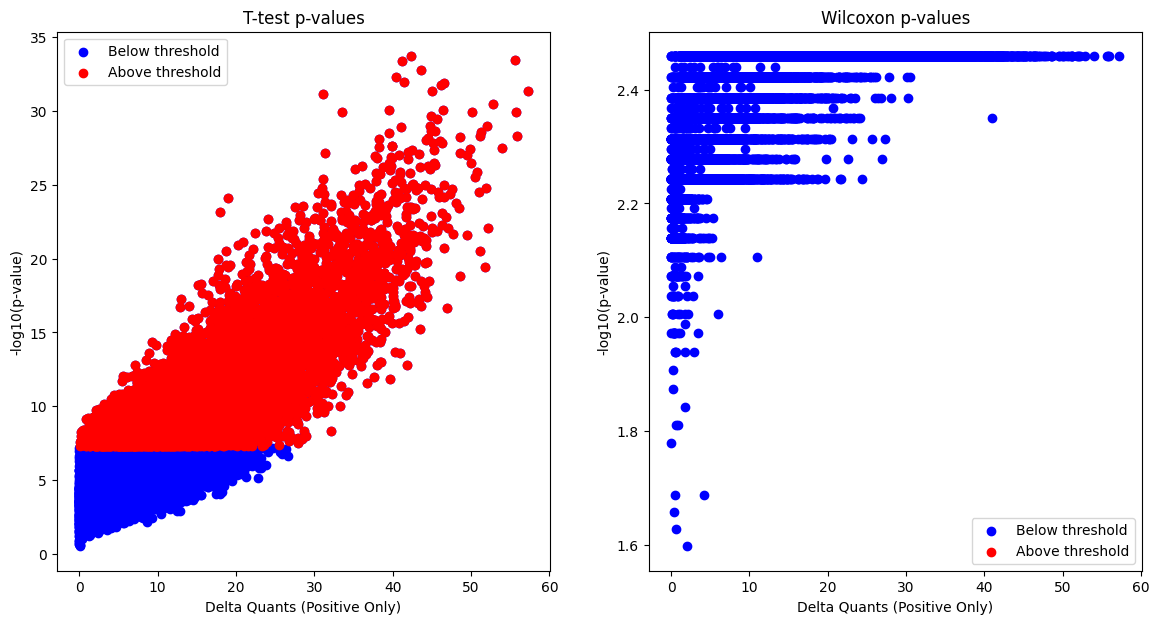

In [29]:
# Calculate -log10 of p-values
df['-log10_ttest'] = -np.log10(df['ttest'])
df['-log10_wilcoxon'] = -np.log10(df['wilcoxon'])

# Only include rows where delta_quants is positive
filtered_df = df[df['delta_quants'] > 0]

# Set the Bonferroni alpha threshold (e.g., 0.05)
# bonferroni_alpha = 0.05
bonferroni_alpha = pval / len(df)

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

# Create scatter plot for t-test
axes[0].scatter(filtered_df['delta_quants'], filtered_df['-log10_ttest'], c='blue', label='Below threshold')
above_threshold = filtered_df['ttest'] < bonferroni_alpha
axes[0].scatter(filtered_df['delta_quants'][above_threshold], filtered_df['-log10_ttest'][above_threshold], c='red', label='Above threshold')
axes[0].set_title('T-test p-values')
axes[0].set_xlabel('Delta Quants (Positive Only)')
axes[0].set_ylabel('-log10(p-value)')
axes[0].legend()

# Create scatter plot for Wilcoxon
axes[1].scatter(filtered_df['delta_quants'], filtered_df['-log10_wilcoxon'], c='blue', label='Below threshold')
above_threshold = filtered_df['wilcoxon'] < bonferroni_alpha
axes[1].scatter(filtered_df['delta_quants'][above_threshold], filtered_df['-log10_wilcoxon'][above_threshold], c='red', label='Above threshold')
axes[1].set_title('Wilcoxon p-values')
axes[1].set_xlabel('Delta Quants (Positive Only)')
axes[1].set_ylabel('-log10(p-value)')
axes[1].legend()

# Show plots
plt.show()

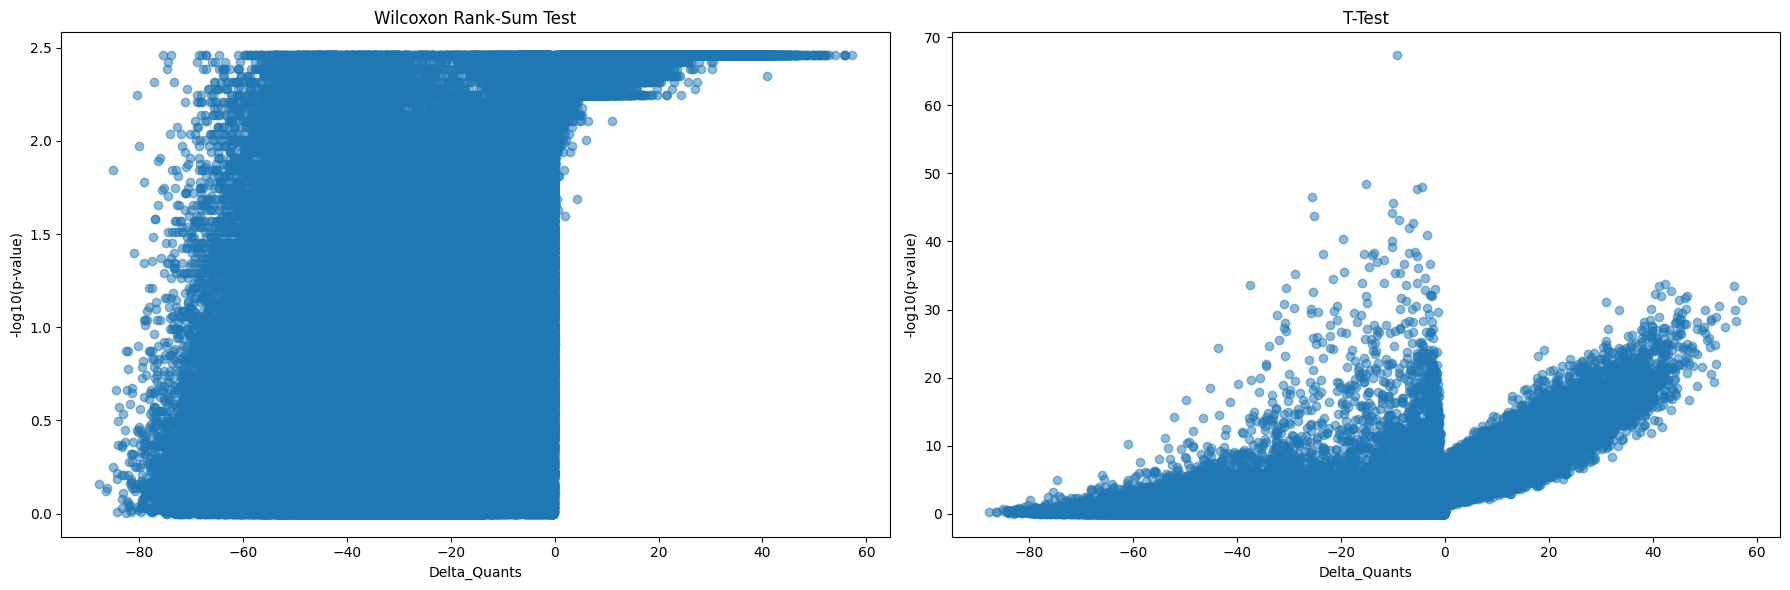

In [24]:


# Extract the relevant columns
df_plot = df[['delta_quants', 'wilcoxon', 'ttest']]

# Calculate -log10 of p-values
df_plot['-log10_wilcoxon'] = -np.log10(df_plot['wilcoxon'])
df_plot['-log10_ttest'] = -np.log10(df_plot['ttest'])
# df_plot['-log10_permutation'] = -np.log10(df_plot['permutation_pvalue'])

# Create scatter plots
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Wilcoxon
axes[0].scatter(df_plot['delta_quants'], df_plot['-log10_wilcoxon'], alpha=0.5)
axes[0].set_title('Wilcoxon Rank-Sum Test')
axes[0].set_xlabel('Delta_Quants')
axes[0].set_ylabel('-log10(p-value)')

# t-test
axes[1].scatter(df_plot['delta_quants'], df_plot['-log10_ttest'], alpha=0.5)
axes[1].set_title('T-Test')
axes[1].set_xlabel('Delta_Quants')
axes[1].set_ylabel('-log10(p-value)')

# Permutation Test
# axes[2].scatter(df_plot['delta_quants'], df_plot['-log10_permutation'], alpha=0.5)
# axes[2].set_title('Permutation Test')
# axes[2].set_xlabel('Delta_Quants')
# axes[2].set_ylabel('-log10(p-value)')

plt.tight_layout()
plt.show()


In [25]:
df

CD564159_Colon  CD563663_Colon  CD563419_Colon  \
chr_start_end                                                               
chr10_100000287_100001679       86.211765       83.576471       65.694118   
chr10_100005684_100006585       60.562500       55.612500       37.175000   
chr10_100006585_100007070       64.200000       71.714286       60.557143   
chr10_100008953_100010416        0.616129        0.913710        0.316935   
chr10_100011399_100012266       82.278788       88.127273       82.469697   
...                                   ...             ...             ...   
chr9_99906266_99907398           0.559091        0.663636        0.775000   
chr9_9991184_9991813            84.033333       81.133333       87.716667   
chr9_9992391_9993342            83.471429       87.728571       90.600000   
chr9_999890_1000381             86.600000       84.450000       89.950000   
chr9_99994034_99994556          93.771429       94.885714       92.428571   

                           CD565189_Colon  CD564242_Prostate  \
chr_start_end                                                  
chr10_100000287_100001679       65.847059          86.711765   
chr10_100005684_100006585       30.625000          63.200000   
chr10_100006585_100007070       50.385714          74.185714   
chr10_100008953_100010416        0.395161           0.389516   
chr10_100011399_100012266       80.009091          85.984848   
...                                   ...                ...   
chr9_99906266_99907398           0.794318           0.471591   
chr9_9991184_9991813            85.233333          86.900000   
chr9_9992391_9993342            85.757143          89.285714   
chr9_999890_1000381             79.750000          84.510000   
chr9_99994034_99994556          85.114286          94.528571   

                           CD563610_Prostate  CD563685_Prostate  \
chr_start_end                                                     
chr10_100000287_100001679          88.888235          88.041176   
chr10_100005684_100006585          54.012500          55.775000   
chr10_100006585_100007070          73.571429          81.585714   
chr10_100008953_100010416           0.418548           0.436290   
chr10_100011399_100012266          87.621212          85.421212   
...                                      ...                ...   
chr9_99906266_99907398              0.193182           0.478409   
chr9_9991184_9991813               76.083333          90.416667   
chr9_9992391_9993342               86.957143          91.700000   
chr9_999890_1000381                86.410000          87.800000   
chr9_99994034_99994556             82.857143          86.914286   

                           CD563267_Prostate  CD565017_Spleen  \
chr_start_end                                                   
chr10_100000287_100001679          88.670588        88.241176   
chr10_100005684_100006585          52.975000        50.275000   
chr10_100006585_100007070          75.571429        82.985714   
chr10_100008953_100010416           0.454032         0.843548   
chr10_100011399_100012266          82.400000        89.603030   
...                                      ...              ...   
chr9_99906266_99907398              0.723864         0.951136   
chr9_9991184_9991813               84.783333        77.983333   
chr9_9992391_9993342               91.500000        85.200000   
chr9_999890_1000381                86.110000        69.530000   
chr9_99994034_99994556             89.571429        92.057143   

                           CD563880_Spleen  ...    tg_mean    bg_mean  \
chr_start_end                               ...                         
chr10_100000287_100001679        80.764706  ...  75.984314  85.157711   
chr10_100005684_100006585        46.537500  ...  39.091667  59.277872   
chr10_100006585_100007070        69.014286  ...  68.304762  74.320077   
chr10_100008953_100010416         0.890323  ...   0.289247   0.744006   
chr10_100011399_100012266        91.

In [ ]:

observed_delta_quants_list = []
p_values_list = []
for dmr_index,row in df.iterrows():
#     print(dmr_index)
    observed_delta_quants, permuted_delta_quants, p_value = permutation_test(df, dmr_index, tg_names, bg_names)

    observed_delta_quants_list.append(observed_delta_quants)
    p_values_list.append(p_value)
    

df['permutation_delta_quants'] = observed_delta_quants_list
df['permutation_pvalue'] = p_values_list

In [ ]:


# Extract the relevant columns
df_plot = df[['delta_quants', 'wilcoxon', 'ttest', 'permutation_pvalue']]

# Calculate -log10 of p-values
df_plot['-log10_wilcoxon'] = -np.log10(df_plot['wilcoxon'])
df_plot['-log10_ttest'] = -np.log10(df_plot['ttest'])
df_plot['-log10_permutation'] = -np.log10(df_plot['permutation_pvalue'])

# Create scatter plots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Wilcoxon
axes[0].scatter(df_plot['delta_quants'], df_plot['-log10_wilcoxon'], alpha=0.5)
axes[0].set_title('Wilcoxon Rank-Sum Test')
axes[0].set_xlabel('Delta_Quants')
axes[0].set_ylabel('-log10(p-value)')

# t-test
axes[1].scatter(df_plot['delta_quants'], df_plot['-log10_ttest'], alpha=0.5)
axes[1].set_title('T-Test')
axes[1].set_xlabel('Delta_Quants')
axes[1].set_ylabel('-log10(p-value)')

# Permutation Test
axes[2].scatter(df_plot['delta_quants'], df_plot['-log10_permutation'], alpha=0.5)
axes[2].set_title('Permutation Test')
axes[2].set_xlabel('Delta_Quants')
axes[2].set_ylabel('-log10(p-value)')

plt.tight_layout()
plt.show()


### Demo of DMR for thesis

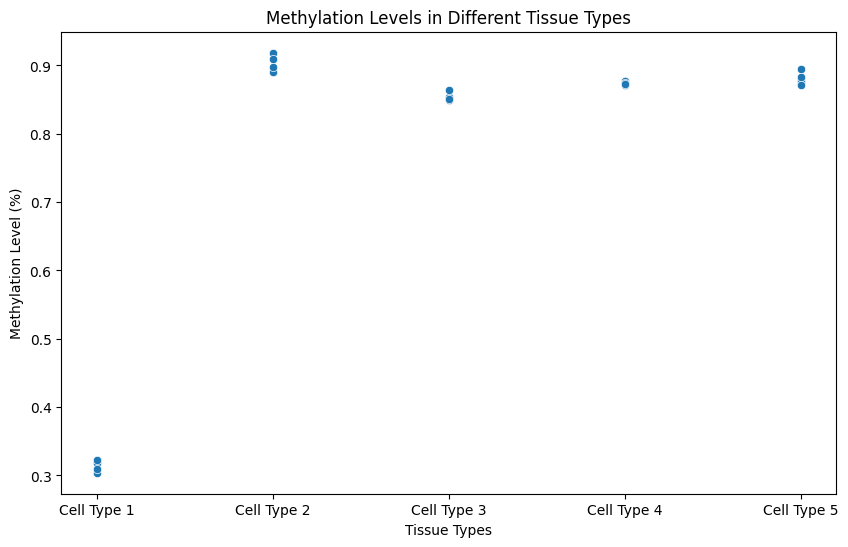

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Setting seed for reproducibility
np.random.seed(0)

# Number of tissue types and replicates
n_tissue_types = 5
n_replicates = 4

# Generate random methylation values
# Assuming different mean methylation levels for each tissue type
# mean_methylation_levels = np.linspace(20, 80, n_tissue_types)
mean_methylation_levels = [0.3,0.9,0.85,0.87,0.88]
std_dev = 0.01  # Standard deviation for the methylation values

methylation_data = []
tissue_labels = []

for i in range(n_tissue_types):
    # Generate methylation values for each replicate of a tissue type
    methylation_values = np.random.normal(mean_methylation_levels[i], std_dev, n_replicates)
    methylation_data.extend(methylation_values)
    tissue_labels.extend([f'Cell Type {i+1}'] * n_replicates)

# Create a scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=tissue_labels, y=methylation_data)
plt.xlabel('Tissue Types')
plt.ylabel('Methylation Level (%)')
plt.title('Methylation Levels in Different Tissue Types')
plt.show()


IndexError: list index out of range

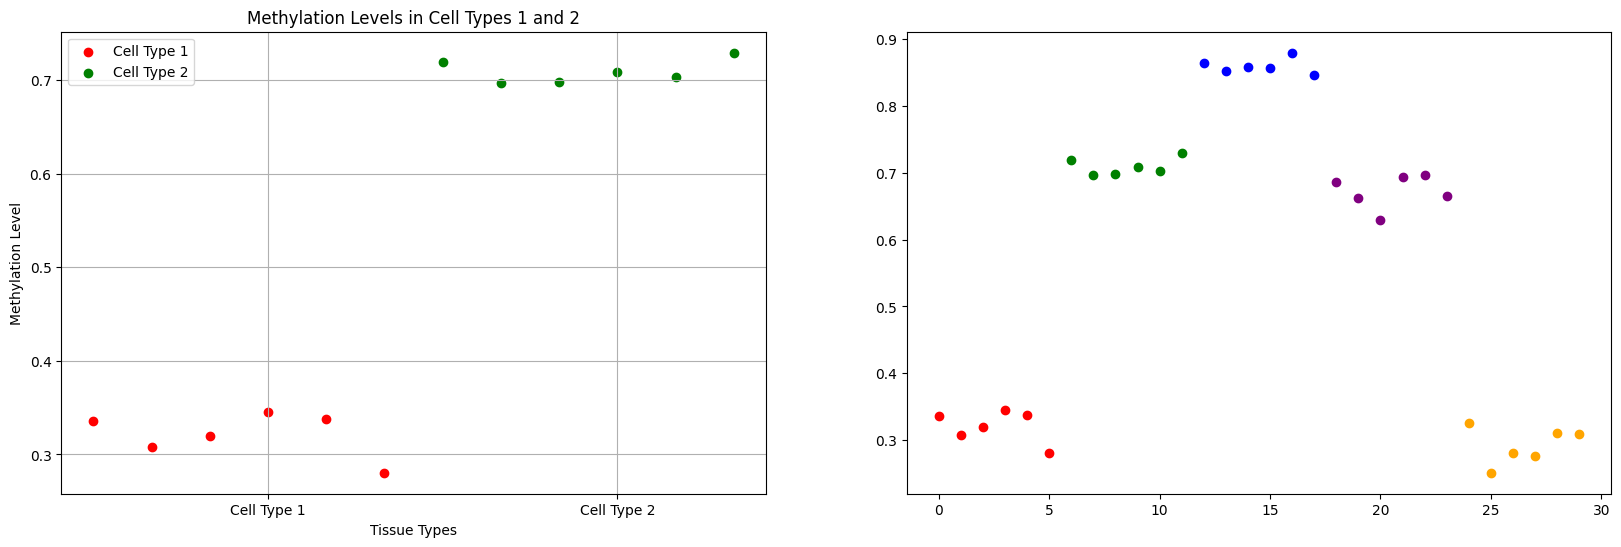

In [23]:
import numpy as np
import matplotlib.pyplot as plt

# Set the mean methylation levels and standard deviation
mean_methylation_levels = [0.3, 0.7, 0.85, 0.68,0.28,0.31,0.32,0.305, 0.88]
std_dev = 0.02  # Standard deviation

# Number of tissue types and replicates
n_tissue_types = 9
n_replicates = 6
colors = ['red', 'green', 'blue', 'purple', 'orange']  # Colors for each tissue type

# Initialize lists for methylation data and x-coordinates
methylation_data = []
x_coords = []

# Generate random methylation values
np.random.seed(0)
for i in range(n_tissue_types):
    methylation_values = np.random.normal(mean_methylation_levels[i], std_dev, n_replicates)
    methylation_data.extend(methylation_values)
    x_coords.extend(np.arange(i * n_replicates, (i + 1) * n_replicates))

# Create two plots side by side
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

# Plot for the first two cell types
for i in range(2):  # Looping through the first two cell types
    axes[0].scatter(x_coords[i*n_replicates:(i+1)*n_replicates], 
                    methylation_data[i*n_replicates:(i+1)*n_replicates], 
                    color=colors[i], label=f'Cell Type {i+1}')
axes[0].set_xticks(np.arange(n_replicates / 2, 2 * n_replicates, n_replicates))
axes[0].set_xticklabels(['Cell Type 1', 'Cell Type 2'])
axes[0].set_xlabel('Tissue Types')
axes[0].set_ylabel('Methylation Level')
axes[0].set_title('Methylation Levels in Cell Types 1 and 2')
axes[0].grid(True)
axes[0].legend()

# Plot for all five cell types
for i in range(n_tissue_types):
    axes[1].scatter(x_coords[i*n_replicates:(i+1)*n_replicates], 
                    methylation_data[i*n_replicates:(i+1)*n_replicates], 
                    color=colors[i], label=f'Cell Type {i+1}')
axes[1].set_xticks(np.arange(n_replicates / 2, n_tissue_types * n_replicates, n_replicates))
axes[1].set_xticklabels([f'Cell Type {i+1}' for i in range(n_tissue_types)])
axes[1].set_xlabel('Tissue Types')
axes[1].set_ylabel('Methylation Level')
axes[1].set_title('Methylation Levels in All Cell Types')
axes[1].grid(True)
axes[1].legend()

plt.show()


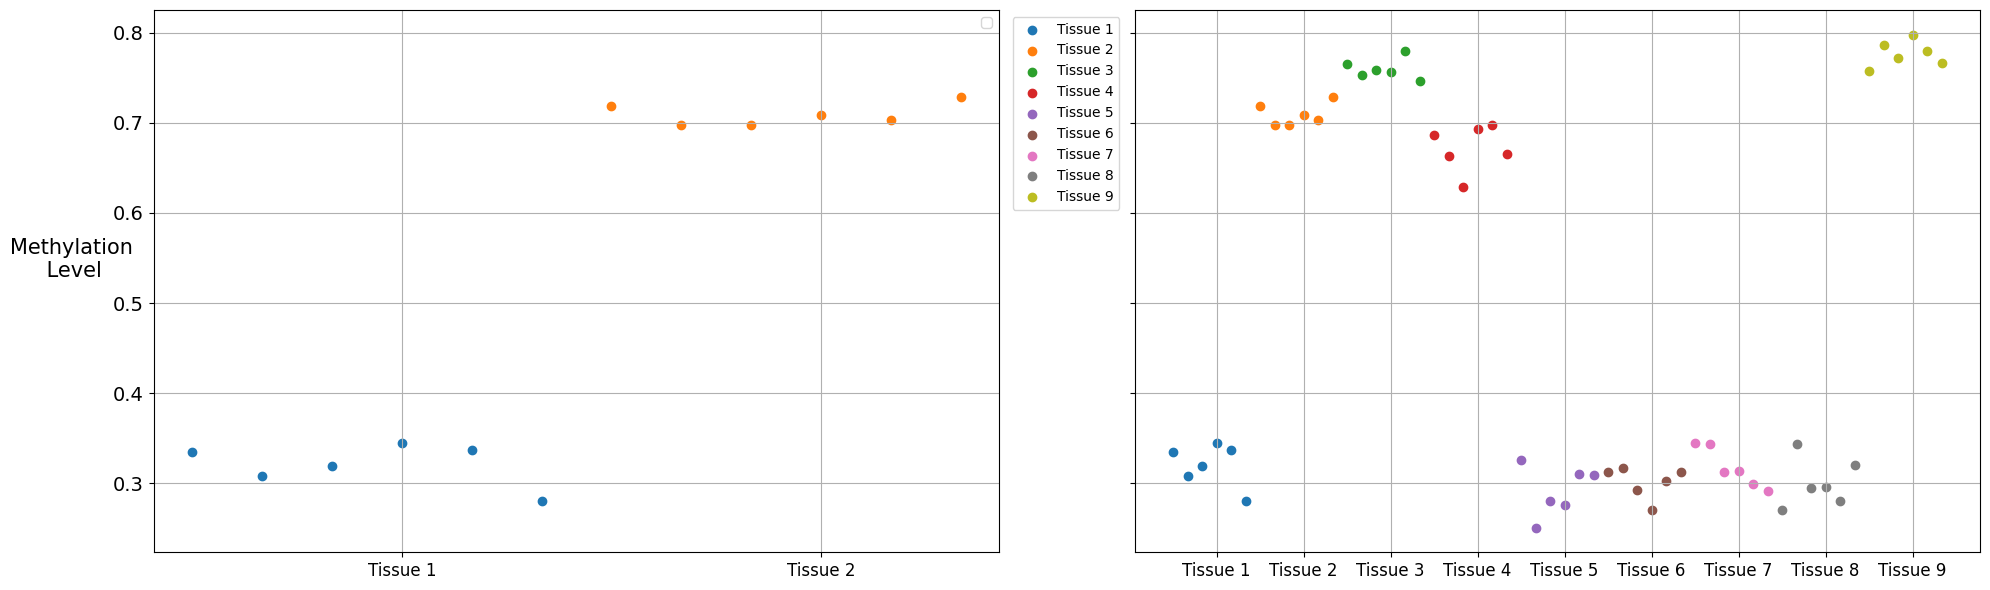

In [51]:
import numpy as np
import matplotlib.pyplot as plt

# Set the mean methylation levels and standard deviation
mean_methylation_levels = [0.3, 0.7, 0.75, 0.68, 0.28, 0.31, 0.32, 0.305, 0.79]
std_dev = 0.02  # Standard deviation

# Number of tissue types and replicates
n_tissue_types = 9
n_replicates = 6

# Using a colormap to generate distinct colors for each tissue type
cmap = plt.get_cmap('tab10')
colors = [cmap(i) for i in range(n_tissue_types)]

# Initialize lists for methylation data and x-coordinates
methylation_data = []
x_coords = []

# Generate random methylation values
np.random.seed(0)
for i in range(n_tissue_types):
    methylation_values = np.random.normal(mean_methylation_levels[i], std_dev, n_replicates)
    methylation_data.extend(methylation_values)
    x_coords.extend(np.arange(i * n_replicates, (i + 1) * n_replicates))

# Create two plots side by side
fig, axes = plt.subplots(1, 2, figsize=(20, 6),sharey=True)

# Plot for the first two cell types
for i in range(2):  # Looping through the first two cell types
    axes[0].scatter(x_coords[i*n_replicates:(i+1)*n_replicates], 
                    methylation_data[i*n_replicates:(i+1)*n_replicates], 
                    color=colors[i], label=f'Tissue {i+1}')
axes[0].set_xticks(np.arange(n_replicates / 2, 2 * n_replicates, n_replicates))
axes[0].set_xticklabels(['Tissue 1', 'Tissue 2'],fontsize=12)
# axes[0].set_xlabel('Tissue Types')
axes[0].set_ylabel('Methylation\n Level',rotation=0,labelpad=30,fontsize=15)
# axes[0].set_title('Methylation Levels in Tissues 1 and 2')
axes[0].grid(True)
axes[0].legend('')

# Plot for all nine cell types
for i in range(n_tissue_types):
    axes[1].scatter(x_coords[i*n_replicates:(i+1)*n_replicates], 
                    methylation_data[i*n_replicates:(i+1)*n_replicates], 
                    color=colors[i], label=f'Tissue {i+1}')
axes[1].set_xticks(np.arange(n_replicates / 2, n_tissue_types * n_replicates, n_replicates))
axes[1].set_xticklabels([f'Tissue {i+1}' for i in range(n_tissue_types)],fontsize=12)
# axes[1].set_xlabel('Tissue Types')
# axes[1].set_ylabel('Methylation\n Level',rotation=0,labelpad=30)
# axes[1].set_title('Methylation Levels in All Tissues')
axes[1].grid(True)
axes[1].legend(bbox_to_anchor=(-0.01,1))
plt.setp(axes[0].get_yticklabels(), fontsize=14)  # Adjust font size as needed
plt.tight_layout()


savedir = "/well/ludwig/users/dyp502/thesis/thesis_figures/taps_atlas/"
plt.savefig(savedir + f'taps_atlas.synthetic_DMR_example_context.png')

